# Introduction

trackintel documentation: https://trackintel.readthedocs.io/en/latest/modules/model.html#trackintel.Positionfixes

trackintel tutorial: https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb

In [ ]:
!pip install trackintel

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import timedelta
from matplotlib import pyplot as plt
from multiprocessing import Pool
from shapely.geometry import LineString
from shapely.geometry import Point

import trackintel as ti

In [3]:
cityA = pd.read_csv('cityA_kotae.csv')
cityA.head()

,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89


In [4]:
cityA.shape

(111535175, 5)

In [5]:
cityA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111535175 entries, 0 to 111535174
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 4.2 GB


`d`: Days since start of the data collection, ranges from 0-74 (the data is collected over 75 days)   
`t`: Ranges from 0-47 (the data is collected every 30 mins, there is 48 such periods in 1 day)

# Data Preprocessing

Limit the data to only the first month's data (30 days), i.e. `d` < 30.

In [6]:
cityA = cityA[cityA['d'] < 30]

In [7]:
cityA.shape

(43679653, 5)

In [8]:
# Save to a temporary file for later use
cityA.to_csv('cityA_filtered.csv', index=False)

Here, we define an arbitrary start date of the data collected.

In [9]:
# Define the start date
start_date = pd.to_datetime("2024-01-01")

In [10]:
def preprocess_data(data, start_date):
    # Create Point geometries
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)
    gdf.set_crs(epsg=3857, inplace=True)

    # Convert 'd' (days since start) to actual date
    gdf['date'] = start_date + pd.to_timedelta(gdf['d'], unit='D')
    
    # Convert 't' (30-minute intervals) to time of day
    gdf['time'] = pd.to_timedelta(gdf['t'] * 30, unit='m')  # Each 't' is multiplied by 30 minutes
    
    # Combine 'date' and 'time' into a single datetime column
    gdf['datetime'] = gdf['date'] + gdf['time']

    return gdf

In [11]:
def remove_consecutive_duplicates(sequence):
    """Remove consecutive duplicate coordinates from a sequence."""
    cleaned_sequence = [sequence[0]]  # Start with the first element
    for i in range(1, len(sequence)):
        if sequence[i] != sequence[i - 1]:  # Only add if different from the previous point
            cleaned_sequence.append(sequence[i])
    return cleaned_sequence

def preprocess_tripleg(dataset):
    """Preprocess each tripleg in the dataset by removing consecutive duplicates."""
    return [remove_consecutive_duplicates(sequence) for sequence in dataset]

In [12]:
def split_triplegs(triplegs, max_length):
    processed_triplegs = []
    for tripleg in triplegs:      
        # Split if the cleaned tripleg is too long
        if len(tripleg) > max_length:
            for i in range(0, len(tripleg), max_length):
                processed_triplegs.append(tripleg[i:i + max_length])
        else:
            processed_triplegs.append(tripleg)
    return processed_triplegs

# GSP Algorithm

In [13]:
class GSP:
    def __init__(self, sequences, min_support):
        self.sequences = sequences          # List of sequences with coordinate pairs
        self.min_support = min_support      # Minimum support threshold
        self.frequent_patterns = []         # Store all found frequent patterns

    def is_subsequence(self, candidate, sequence):
        candidate_index = 0  # Start with the first element of candidate
        for item in sequence:
            if item == candidate[candidate_index]:  # Check if current item matches the current candidate element
                candidate_index += 1  # Move to the next element in candidate
                if candidate_index == len(candidate):  # If we matched all elements in candidate, it's a subsequence
                    return True
        return False  # If we finish the loop without matching all of candidate, return False
    
    def count_support(self, candidates):
        """
        Count the support of each candidate in the sequences
        """
        support_count = defaultdict(int)
        for sequence in self.sequences:
            # Filter out sequences that are too short to contain any candidates of the current length
            if len(sequence) < len(next(iter(candidates))):  # All candidates are of the same length
                continue
                
            for candidate in candidates:
                if support_count[candidate] >= min_support: # Early stopping: stop counting if min_support is reached
                    continue
                    
                if self.is_subsequence(candidate, sequence):
                    support_count[candidate] += 1

        # Filter out candidates that meet minimum support threshold
        support_count = {seq: count for seq, count in support_count.items() if count >= self.min_support}
        return support_count

    def generate_candidates(self, prev_frequent_patterns, k):
        """Generate candidate sequences of a specified length by merging sequences with common prefixes/suffixes.
        Includes Apriori check to remove candidate sequences with any non-frequent subsequence.
        """
        candidates = set()
        for pattern1 in prev_frequent_patterns:
            for pattern2 in prev_frequent_patterns:
                if pattern1 == pattern2: # Don't merge the same sequences
                    continue
                # Merge two sequences if they share k-1 items
                if pattern1[1:] == pattern2[:-1]:  # Ensure that only relevant sequences are merged
                    candidate = pattern1 + (pattern2[-1],)
                    # Apriori check: Keep only if all (k-1) subsequences are frequent
                    if all(candidate[i:i+k-1] in prev_frequent_patterns for i in range(len(candidate) - k + 1)):
                        candidates.add(candidate)
                        
        return candidates

    def run(self):
        """
        Run the GSP algorithm
        """
        # Step 1: Find frequent 1-sequences (individual locations)
        all_items = set(item for sequence in self.sequences for item in sequence)
        initial_candidates = [(item,) for item in all_items]
        frequent_patterns = self.count_support(initial_candidates)
        
        # Add to result list
        self.frequent_patterns.extend(frequent_patterns.items())
        print("1-itemsets done!")
        
        k = 2  # Start with 2-sequences

        while frequent_patterns:
            # Step 2: Generate candidate k-sequences (those with infrequent subsequences are removed)
            candidates = self.generate_candidates(frequent_patterns.keys(), k)
            if not candidates: # Break if no new candidates are generated
                print(f"No new candidates generated. Stopping at {k-1}-itemsets")
                break
            
            # Step 3: Count support for each candidate (those that do not meet min_support are removed)
            frequent_patterns = self.count_support(candidates)
            
            # Add found frequent patterns to result list
            if frequent_patterns:
                self.frequent_patterns.extend(frequent_patterns.items())
                print(f"{k}-itemsets done!")
            
            # Move to the next level
            k += 1

        return self.frequent_patterns

In [25]:
# Define constants
chunk_size = 100000  # Number of rows to load per chunk
min_support = 10  # Minimum support for frequent patterns
gap_threshold_sp = 45  # Gap threshold for staypoint detection
gap_threshold_trip = 45 # Gap threshold for triplegs generation
dist_threshold = 10  # Distance threshold for staypoints
max_tripleg_length = 10 # Maximum length of each tripleg

In [27]:
# Dictionary to store patterns by chunk
all_frequent_patterns = defaultdict(list)

In [29]:
# Process data in chunks
for chunk in pd.read_csv('cityA_filtered.csv', chunksize=chunk_size):
    # Preprocess each chunk
    gdf_chunk = preprocess_data(chunk, start_date)
    
    # Generate position fixes and triplegs
    pfs_chunk = ti.io.read_positionfixes_gpd(gdf_chunk, tracked_at="datetime", user_id="uid", geom_col="geometry", tz='Asia/Tokyo')
    pfs_chunk, sp_chunk = pfs_chunk.as_positionfixes.generate_staypoints(gap_threshold=gap_threshold_sp, dist_threshold=dist_threshold, 
                                                                         print_progress=True)
    pfs_chunk, tpls_chunk = pfs_chunk.generate_triplegs(staypoints=sp_chunk, method='overlap_staypoints', gap_threshold=gap_threshold_trip)

    print(gdf_chunk[:5])
    
    # Convert triplegs to sequences
    tpls_chunk['tripleg_list'] = tpls_chunk['geom'].apply(lambda geom: list(geom.coords))
    tripleg_list = tpls_chunk['tripleg_list'].tolist()
    
    # Preprocess triplegs by removing consecutive duplicates
    processed_triplegs = preprocess_tripleg(tripleg_list)
    splitted_triplegs = split_triplegs(processed_triplegs, 10)
    
    # Apply GSP on each chunk and collect patterns
    gsp = GSP(splitted_triplegs, min_support)
    frequent_patterns_chunk = gsp.run()
    all_frequent_patterns.update(frequent_patterns_chunk)

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:18<00:00, 11.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

   uid  d   t   x   y               geometry       date            time  \
0    0  0   1  79  86  POINT (79.000 86.000) 2024-01-01 0 days 00:30:00   
1    0  0   2  79  86  POINT (79.000 86.000) 2024-01-01 0 days 01:00:00   
2    0  0   8  77  86  POINT (77.000 86.000) 2024-01-01 0 days 04:00:00   
3    0  0   9  77  86  POINT (77.000 86.000) 2024-01-01 0 days 04:30:00   
4    0  0  19  81  89  POINT (81.000 89.000) 2024-01-01 0 days 09:30:00   

             datetime  
0 2024-01-01 00:30:00  
1 2024-01-01 01:00:00  
2 2024-01-01 04:00:00  
3 2024-01-01 04:30:00  
4 2024-01-01 09:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:18<00:00, 11.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t    x   y                geometry       date  \
100000  207  23  25  174  86  POINT (174.000 86.000) 2024-01-24   
100001  207  23  27  174  86  POINT (174.000 86.000) 2024-01-24   
100002  207  23  32  179  86  POINT (179.000 86.000) 2024-01-24   
100003  207  23  33  182  85  POINT (182.000 85.000) 2024-01-24   
100004  207  23  37  181  87  POINT (181.000 87.000) 2024-01-24   

                  time            datetime  
100000 0 days 12:30:00 2024-01-24 12:30:00  
100001 0 days 13:30:00 2024-01-24 13:30:00  
100002 0 days 16:00:00 2024-01-24 16:00:00  
100003 0 days 16:30:00 2024-01-24 16:30:00  
100004 0 days 18:30:00 2024-01-24 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [00:18<00:00, 11.48it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid  d   t   x    y                geometry       date  \
200000  415  5  22  97  117  POINT (97.000 117.000) 2024-01-06   
200001  415  5  24  96  116  POINT (96.000 116.000) 2024-01-06   
200002  415  5  25  97  117  POINT (97.000 117.000) 2024-01-06   
200003  415  5  30  97  117  POINT (97.000 117.000) 2024-01-06   
200004  415  5  31  99  116  POINT (99.000 116.000) 2024-01-06   

                  time            datetime  
200000 0 days 11:00:00 2024-01-06 11:00:00  
200001 0 days 12:00:00 2024-01-06 12:00:00  
200002 0 days 12:30:00 2024-01-06 12:30:00  
200003 0 days 15:00:00 2024-01-06 15:00:00  
200004 0 days 15:30:00 2024-01-06 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 206/206 [00:18<00:00, 11.17it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t    x   y                geometry       date  \
300000  629  20  17  171  47  POINT (171.000 47.000) 2024-01-21   
300001  629  20  24  176  51  POINT (176.000 51.000) 2024-01-21   
300002  629  20  25  174  49  POINT (174.000 49.000) 2024-01-21   
300003  629  20  28  174  47  POINT (174.000 47.000) 2024-01-21   
300004  629  20  29  174  49  POINT (174.000 49.000) 2024-01-21   

                  time            datetime  
300000 0 days 08:30:00 2024-01-21 08:30:00  
300001 0 days 12:00:00 2024-01-21 12:00:00  
300002 0 days 12:30:00 2024-01-21 12:30:00  
300003 0 days 14:00:00 2024-01-21 14:00:00  
300004 0 days 14:30:00 2024-01-21 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:19<00:00, 10.86it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t    x   y                geometry       date  \
400000  834  25  24  170  83  POINT (170.000 83.000) 2024-01-26   
400001  834  25  25  173  81  POINT (173.000 81.000) 2024-01-26   
400002  834  25  26  168  83  POINT (168.000 83.000) 2024-01-26   
400003  834  25  30  168  82  POINT (168.000 82.000) 2024-01-26   
400004  834  25  31  168  83  POINT (168.000 83.000) 2024-01-26   

                  time            datetime  
400000 0 days 12:00:00 2024-01-26 12:00:00  
400001 0 days 12:30:00 2024-01-26 12:30:00  
400002 0 days 13:00:00 2024-01-26 13:00:00  
400003 0 days 15:00:00 2024-01-26 15:00:00  
400004 0 days 15:30:00 2024-01-26 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:17<00:00, 12.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid  d   t    x   y                geometry       date  \
500000  1045  7  38  111  72  POINT (111.000 72.000) 2024-01-08   
500001  1045  7  39  110  38  POINT (110.000 38.000) 2024-01-08   
500002  1045  8  24  110  38  POINT (110.000 38.000) 2024-01-09   
500003  1045  8  25  110  38  POINT (110.000 38.000) 2024-01-09   
500004  1045  8  27  109  39  POINT (109.000 39.000) 2024-01-09   

                  time            datetime  
500000 0 days 19:00:00 2024-01-08 19:00:00  
500001 0 days 19:30:00 2024-01-08 19:30:00  
500002 0 days 12:00:00 2024-01-09 12:00:00  
500003 0 days 12:30:00 2024-01-09 12:30:00  
500004 0 days 13:30:00 2024-01-09 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.65it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid   d   t   x    y                geometry       date  \
600000  1254  27  32  75  110  POINT (75.000 110.000) 2024-01-28   
600001  1254  27  36  84  112  POINT (84.000 112.000) 2024-01-28   
600002  1254  27  37  97  106  POINT (97.000 106.000) 2024-01-28   
600003  1254  28  12  88  116  POINT (88.000 116.000) 2024-01-29   
600004  1254  28  13  73  112  POINT (73.000 112.000) 2024-01-29   

                  time            datetime  
600000 0 days 16:00:00 2024-01-28 16:00:00  
600001 0 days 18:00:00 2024-01-28 18:00:00  
600002 0 days 18:30:00 2024-01-28 18:30:00  
600003 0 days 06:00:00 2024-01-29 06:00:00  
600004 0 days 06:30:00 2024-01-29 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:21<00:00,  9.76it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid  d   t   x    y                geometry       date  \
700000  1477  3  38  78  133  POINT (78.000 133.000) 2024-01-04   
700001  1477  3  39  55  136  POINT (55.000 136.000) 2024-01-04   
700002  1477  3  40  64  147  POINT (64.000 147.000) 2024-01-04   
700003  1477  3  41  65  148  POINT (65.000 148.000) 2024-01-04   
700004  1477  3  43  65  145  POINT (65.000 145.000) 2024-01-04   

                  time            datetime  
700000 0 days 19:00:00 2024-01-04 19:00:00  
700001 0 days 19:30:00 2024-01-04 19:30:00  
700002 0 days 20:00:00 2024-01-04 20:00:00  
700003 0 days 20:30:00 2024-01-04 20:30:00  
700004 0 days 21:30:00 2024-01-04 21:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:20<00:00, 10.40it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid  d   t    x    y                 geometry       date  \
800000  1685  9   5  101  115  POINT (101.000 115.000) 2024-01-10   
800001  1685  9  12  104  117  POINT (104.000 117.000) 2024-01-10   
800002  1685  9  13  105  114  POINT (105.000 114.000) 2024-01-10   
800003  1685  9  14  101  115  POINT (101.000 115.000) 2024-01-10   
800004  1685  9  15  101  115  POINT (101.000 115.000) 2024-01-10   

                  time            datetime  
800000 0 days 02:30:00 2024-01-10 02:30:00  
800001 0 days 06:00:00 2024-01-10 06:00:00  
800002 0 days 06:30:00 2024-01-10 06:30:00  
800003 0 days 07:00:00 2024-01-10 07:00:00  
800004 0 days 07:30:00 2024-01-10 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:20<00:00, 10.42it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid   d   t   x    y                geometry       date  \
900000  1898  25  14  81  103  POINT (81.000 103.000) 2024-01-26   
900001  1898  25  15  79  102  POINT (79.000 102.000) 2024-01-26   
900002  1898  25  16  79   97   POINT (79.000 97.000) 2024-01-26   
900003  1898  25  17  80   97   POINT (80.000 97.000) 2024-01-26   
900004  1898  25  18  72   85   POINT (72.000 85.000) 2024-01-26   

                  time            datetime  
900000 0 days 07:00:00 2024-01-26 07:00:00  
900001 0 days 07:30:00 2024-01-26 07:30:00  
900002 0 days 08:00:00 2024-01-26 08:00:00  
900003 0 days 08:30:00 2024-01-26 08:30:00  
900004 0 days 09:00:00 2024-01-26 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:19<00:00, 10.73it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
1000000  2109  15  24  135  79  POINT (135.000 79.000) 2024-01-16   
1000001  2109  15  25  135  79  POINT (135.000 79.000) 2024-01-16   
1000002  2109  15  26  135  78  POINT (135.000 78.000) 2024-01-16   
1000003  2109  15  32  135  79  POINT (135.000 79.000) 2024-01-16   
1000004  2109  15  35  135  79  POINT (135.000 79.000) 2024-01-16   

                   time            datetime  
1000000 0 days 12:00:00 2024-01-16 12:00:00  
1000001 0 days 12:30:00 2024-01-16 12:30:00  
1000002 0 days 13:00:00 2024-01-16 13:00:00  
1000003 0 days 16:00:00 2024-01-16 16:00:00  
1000004 0 days 17:30:00 2024-01-16 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:21<00:00,  9.85it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
1100000  2321  10  17  89  30  POINT (89.000 30.000) 2024-01-11   
1100001  2321  10  18  97  33  POINT (97.000 33.000) 2024-01-11   
1100002  2321  10  19  99  32  POINT (99.000 32.000) 2024-01-11   
1100003  2321  10  20  98  30  POINT (98.000 30.000) 2024-01-11   
1100004  2321  10  21  96  32  POINT (96.000 32.000) 2024-01-11   

                   time            datetime  
1100000 0 days 08:30:00 2024-01-11 08:30:00  
1100001 0 days 09:00:00 2024-01-11 09:00:00  
1100002 0 days 09:30:00 2024-01-11 09:30:00  
1100003 0 days 10:00:00 2024-01-11 10:00:00  
1100004 0 days 10:30:00 2024-01-11 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 206/206 [00:18<00:00, 11.09it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d  t    x    y                 geometry       date  \
1200000  2527  10  2  172  131  POINT (172.000 131.000) 2024-01-11   
1200001  2527  10  3  161   81   POINT (161.000 81.000) 2024-01-11   
1200002  2527  10  4  172   24   POINT (172.000 24.000) 2024-01-11   
1200003  2527  10  5  172   24   POINT (172.000 24.000) 2024-01-11   
1200004  2527  10  6  172   24   POINT (172.000 24.000) 2024-01-11   

                   time            datetime  
1200000 0 days 01:00:00 2024-01-11 01:00:00  
1200001 0 days 01:30:00 2024-01-11 01:30:00  
1200002 0 days 02:00:00 2024-01-11 02:00:00  
1200003 0 days 02:30:00 2024-01-11 02:30:00  
1200004 0 days 03:00:00 2024-01-11 03:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:19<00:00, 11.55it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
1300000  2733  25  31  70  81  POINT (70.000 81.000) 2024-01-26   
1300001  2733  25  32  71  83  POINT (71.000 83.000) 2024-01-26   
1300002  2733  25  34  71  82  POINT (71.000 82.000) 2024-01-26   
1300003  2733  25  35  75  73  POINT (75.000 73.000) 2024-01-26   
1300004  2733  25  36  77  66  POINT (77.000 66.000) 2024-01-26   

                   time            datetime  
1300000 0 days 15:30:00 2024-01-26 15:30:00  
1300001 0 days 16:00:00 2024-01-26 16:00:00  
1300002 0 days 17:00:00 2024-01-26 17:00:00  
1300003 0 days 17:30:00 2024-01-26 17:30:00  
1300004 0 days 18:00:00 2024-01-26 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:19<00:00, 10.90it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
1400000  2953  11  13  144  68  POINT (144.000 68.000) 2024-01-12   
1400001  2953  11  14  148  60  POINT (148.000 60.000) 2024-01-12   
1400002  2953  11  15  147  60  POINT (147.000 60.000) 2024-01-12   
1400003  2953  11  16  148  59  POINT (148.000 59.000) 2024-01-12   
1400004  2953  11  17  134  83  POINT (134.000 83.000) 2024-01-12   

                   time            datetime  
1400000 0 days 06:30:00 2024-01-12 06:30:00  
1400001 0 days 07:00:00 2024-01-12 07:00:00  
1400002 0 days 07:30:00 2024-01-12 07:30:00  
1400003 0 days 08:00:00 2024-01-12 08:00:00  
1400004 0 days 08:30:00 2024-01-12 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:19<00:00, 11.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
1500000  3168  18  35  127  101  POINT (127.000 101.000) 2024-01-19   
1500001  3168  18  36  129  100  POINT (129.000 100.000) 2024-01-19   
1500002  3168  19  12  124   94   POINT (124.000 94.000) 2024-01-20   
1500003  3168  19  13  112   82   POINT (112.000 82.000) 2024-01-20   
1500004  3168  19  14  111   82   POINT (111.000 82.000) 2024-01-20   

                   time            datetime  
1500000 0 days 17:30:00 2024-01-19 17:30:00  
1500001 0 days 18:00:00 2024-01-19 18:00:00  
1500002 0 days 06:00:00 2024-01-20 06:00:00  
1500003 0 days 06:30:00 2024-01-20 06:30:00  
1500004 0 days 07:00:00 2024-01-20 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:18<00:00, 11.29it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
1600000  3387  20  34  132   87   POINT (132.000 87.000) 2024-01-21   
1600001  3387  20  35  131  100  POINT (131.000 100.000) 2024-01-21   
1600002  3387  20  36  130  100  POINT (130.000 100.000) 2024-01-21   
1600003  3387  20  39  132  101  POINT (132.000 101.000) 2024-01-21   
1600004  3387  20  43  131  100  POINT (131.000 100.000) 2024-01-21   

                   time            datetime  
1600000 0 days 17:00:00 2024-01-21 17:00:00  
1600001 0 days 17:30:00 2024-01-21 17:30:00  
1600002 0 days 18:00:00 2024-01-21 18:00:00  
1600003 0 days 19:30:00 2024-01-21 19:30:00  
1600004 0 days 21:30:00 2024-01-21 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:19<00:00, 10.91it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
1700000  3597  14  26  178  51  POINT (178.000 51.000) 2024-01-15   
1700001  3597  14  27  149  81  POINT (149.000 81.000) 2024-01-15   
1700002  3597  14  28  151  82  POINT (151.000 82.000) 2024-01-15   
1700003  3597  14  29  155  82  POINT (155.000 82.000) 2024-01-15   
1700004  3597  14  30  153  82  POINT (153.000 82.000) 2024-01-15   

                   time            datetime  
1700000 0 days 13:00:00 2024-01-15 13:00:00  
1700001 0 days 13:30:00 2024-01-15 13:30:00  
1700002 0 days 14:00:00 2024-01-15 14:00:00  
1700003 0 days 14:30:00 2024-01-15 14:30:00  
1700004 0 days 15:00:00 2024-01-15 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:18<00:00, 11.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
1800000  3809  17  17  63  151  POINT (63.000 151.000) 2024-01-18   
1800001  3809  17  18  63  150  POINT (63.000 150.000) 2024-01-18   
1800002  3809  17  23  66  143  POINT (66.000 143.000) 2024-01-18   
1800003  3809  17  24  66  143  POINT (66.000 143.000) 2024-01-18   
1800004  3809  17  28  65  141  POINT (65.000 141.000) 2024-01-18   

                   time            datetime  
1800000 0 days 08:30:00 2024-01-18 08:30:00  
1800001 0 days 09:00:00 2024-01-18 09:00:00  
1800002 0 days 11:30:00 2024-01-18 11:30:00  
1800003 0 days 12:00:00 2024-01-18 12:00:00  
1800004 0 days 14:00:00 2024-01-18 14:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:18<00:00, 11.45it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
1900000  4013  13  20  135  114  POINT (135.000 114.000) 2024-01-14   
1900001  4013  13  21  135  114  POINT (135.000 114.000) 2024-01-14   
1900002  4013  13  40  137  113  POINT (137.000 113.000) 2024-01-14   
1900003  4013  13  41  154  108  POINT (154.000 108.000) 2024-01-14   
1900004  4013  14  16  148  110  POINT (148.000 110.000) 2024-01-15   

                   time            datetime  
1900000 0 days 10:00:00 2024-01-14 10:00:00  
1900001 0 days 10:30:00 2024-01-14 10:30:00  
1900002 0 days 20:00:00 2024-01-14 20:00:00  
1900003 0 days 20:30:00 2024-01-14 20:30:00  
1900004 0 days 08:00:00 2024-01-15 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:18<00:00, 11.89it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t   x   y               geometry       date  \
2000000  4227  2  30  15  11  POINT (15.000 11.000) 2024-01-03   
2000001  4227  2  31  17   9   POINT (17.000 9.000) 2024-01-03   
2000002  4227  2  32  17  10  POINT (17.000 10.000) 2024-01-03   
2000003  4227  2  33  17   9   POINT (17.000 9.000) 2024-01-03   
2000004  4227  2  34  15  10  POINT (15.000 10.000) 2024-01-03   

                   time            datetime  
2000000 0 days 15:00:00 2024-01-03 15:00:00  
2000001 0 days 15:30:00 2024-01-03 15:30:00  
2000002 0 days 16:00:00 2024-01-03 16:00:00  
2000003 0 days 16:30:00 2024-01-03 16:30:00  
2000004 0 days 17:00:00 2024-01-03 17:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:20<00:00, 11.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
2100000  4447  19  42   99  102   POINT (99.000 102.000) 2024-01-20   
2100001  4447  20   2  100  101  POINT (100.000 101.000) 2024-01-21   
2100002  4447  20   4  100   99   POINT (100.000 99.000) 2024-01-21   
2100003  4447  20   5   72  109   POINT (72.000 109.000) 2024-01-21   
2100004  4447  20  18   73  112   POINT (73.000 112.000) 2024-01-21   

                   time            datetime  
2100000 0 days 21:00:00 2024-01-20 21:00:00  
2100001 0 days 01:00:00 2024-01-21 01:00:00  
2100002 0 days 02:00:00 2024-01-21 02:00:00  
2100003 0 days 02:30:00 2024-01-21 02:30:00  
2100004 0 days 09:00:00 2024-01-21 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:19<00:00, 11.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
2200000  4669  26  37  139  100  POINT (139.000 100.000) 2024-01-27   
2200001  4669  26  45  139  100  POINT (139.000 100.000) 2024-01-27   
2200002  4669  26  46  139  100  POINT (139.000 100.000) 2024-01-27   
2200003  4669  26  47  140   99   POINT (140.000 99.000) 2024-01-27   
2200004  4669  27   0  140   99   POINT (140.000 99.000) 2024-01-28   

                   time            datetime  
2200000 0 days 18:30:00 2024-01-27 18:30:00  
2200001 0 days 22:30:00 2024-01-27 22:30:00  
2200002 0 days 23:00:00 2024-01-27 23:00:00  
2200003 0 days 23:30:00 2024-01-27 23:30:00  
2200004 0 days 00:00:00 2024-01-28 00:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:19<00:00, 10.62it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
2300000  4888  10  40  105  94  POINT (105.000 94.000) 2024-01-11   
2300001  4888  10  41  104  94  POINT (104.000 94.000) 2024-01-11   
2300002  4888  10  42  104  95  POINT (104.000 95.000) 2024-01-11   
2300003  4888  10  43  105  94  POINT (105.000 94.000) 2024-01-11   
2300004  4888  10  44  104  95  POINT (104.000 95.000) 2024-01-11   

                   time            datetime  
2300000 0 days 20:00:00 2024-01-11 20:00:00  
2300001 0 days 20:30:00 2024-01-11 20:30:00  
2300002 0 days 21:00:00 2024-01-11 21:00:00  
2300003 0 days 21:30:00 2024-01-11 21:30:00  
2300004 0 days 22:00:00 2024-01-11 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [00:19<00:00, 10.77it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
2400000  5097  22  28  158  64  POINT (158.000 64.000) 2024-01-23   
2400001  5097  22  29  158  63  POINT (158.000 63.000) 2024-01-23   
2400002  5097  22  30  151  55  POINT (151.000 55.000) 2024-01-23   
2400003  5097  22  31  147  54  POINT (147.000 54.000) 2024-01-23   
2400004  5097  22  32  152  65  POINT (152.000 65.000) 2024-01-23   

                   time            datetime  
2400000 0 days 14:00:00 2024-01-23 14:00:00  
2400001 0 days 14:30:00 2024-01-23 14:30:00  
2400002 0 days 15:00:00 2024-01-23 15:00:00  
2400003 0 days 15:30:00 2024-01-23 15:30:00  
2400004 0 days 16:00:00 2024-01-23 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:19<00:00, 10.88it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
2500000  5311  21  45  57  177  POINT (57.000 177.000) 2024-01-22   
2500001  5311  22  14  57  177  POINT (57.000 177.000) 2024-01-23   
2500002  5311  22  25  57  178  POINT (57.000 178.000) 2024-01-23   
2500003  5311  22  27  57  177  POINT (57.000 177.000) 2024-01-23   
2500004  5311  22  36  62  173  POINT (62.000 173.000) 2024-01-23   

                   time            datetime  
2500000 0 days 22:30:00 2024-01-22 22:30:00  
2500001 0 days 07:00:00 2024-01-23 07:00:00  
2500002 0 days 12:30:00 2024-01-23 12:30:00  
2500003 0 days 13:30:00 2024-01-23 13:30:00  
2500004 0 days 18:00:00 2024-01-23 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
2600000  5525  20  29  160  60  POINT (160.000 60.000) 2024-01-21   
2600001  5525  20  30  160  57  POINT (160.000 57.000) 2024-01-21   
2600002  5525  20  31  157  55  POINT (157.000 55.000) 2024-01-21   
2600003  5525  20  32  159  54  POINT (159.000 54.000) 2024-01-21   
2600004  5525  20  33  159  54  POINT (159.000 54.000) 2024-01-21   

                   time            datetime  
2600000 0 days 14:30:00 2024-01-21 14:30:00  
2600001 0 days 15:00:00 2024-01-21 15:00:00  
2600002 0 days 15:30:00 2024-01-21 15:30:00  
2600003 0 days 16:00:00 2024-01-21 16:00:00  
2600004 0 days 16:30:00 2024-01-21 16:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
No new candidates generated. Stopping at 5-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
2700000  5747  16  34  184  38  POINT (184.000 38.000) 2024-01-17   
2700001  5747  16  35  184  38  POINT (184.000 38.000) 2024-01-17   
2700002  5747  16  36  181  35  POINT (181.000 35.000) 2024-01-17   
2700003  5747  16  37  181  36  POINT (181.000 36.000) 2024-01-17   
2700004  5747  16  39  181  37  POINT (181.000 37.000) 2024-01-17   

                   time            datetime  
2700000 0 days 17:00:00 2024-01-17 17:00:00  
2700001 0 days 17:30:00 2024-01-17 17:30:00  
2700002 0 days 18:00:00 2024-01-17 18:00:00  
2700003 0 days 18:30:00 2024-01-17 18:30:00  
2700004 0 days 19:30:00 2024-01-17 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:19<00:00, 12.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
2800000  5966  28  22  148  78  POINT (148.000 78.000) 2024-01-29   
2800001  5966  28  39  148  77  POINT (148.000 77.000) 2024-01-29   
2800002  5966  28  40  148  78  POINT (148.000 78.000) 2024-01-29   
2800003  5966  29   7  175  78  POINT (175.000 78.000) 2024-01-30   
2800004  5966  29   8  179  80  POINT (179.000 80.000) 2024-01-30   

                   time            datetime  
2800000 0 days 11:00:00 2024-01-29 11:00:00  
2800001 0 days 19:30:00 2024-01-29 19:30:00  
2800002 0 days 20:00:00 2024-01-29 20:00:00  
2800003 0 days 03:30:00 2024-01-30 03:30:00  
2800004 0 days 04:00:00 2024-01-30 04:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:19<00:00, 10.81it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
2900000  6197  28  33  118  118  POINT (118.000 118.000) 2024-01-29   
2900001  6197  28  36  119  116  POINT (119.000 116.000) 2024-01-29   
2900002  6197  28  37  119  117  POINT (119.000 117.000) 2024-01-29   
2900003  6197  28  38  119  116  POINT (119.000 116.000) 2024-01-29   
2900004  6197  28  39  118  118  POINT (118.000 118.000) 2024-01-29   

                   time            datetime  
2900000 0 days 16:30:00 2024-01-29 16:30:00  
2900001 0 days 18:00:00 2024-01-29 18:00:00  
2900002 0 days 18:30:00 2024-01-29 18:30:00  
2900003 0 days 19:00:00 2024-01-29 19:00:00  
2900004 0 days 19:30:00 2024-01-29 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.36it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t    x    y                 geometry       date  \
3000000  6410  5  17   93  121   POINT (93.000 121.000) 2024-01-06   
3000001  6410  5  24  108  113  POINT (108.000 113.000) 2024-01-06   
3000002  6410  5  36   77  124   POINT (77.000 124.000) 2024-01-06   
3000003  6410  5  38   78  125   POINT (78.000 125.000) 2024-01-06   
3000004  6410  5  41   78  124   POINT (78.000 124.000) 2024-01-06   

                   time            datetime  
3000000 0 days 08:30:00 2024-01-06 08:30:00  
3000001 0 days 12:00:00 2024-01-06 12:00:00  
3000002 0 days 18:00:00 2024-01-06 18:00:00  
3000003 0 days 19:00:00 2024-01-06 19:00:00  
3000004 0 days 20:30:00 2024-01-06 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [00:18<00:00, 11.55it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t    x   y                geometry       date  \
3100000  6632  9  30  136  81  POINT (136.000 81.000) 2024-01-10   
3100001  6632  9  33  137  93  POINT (137.000 93.000) 2024-01-10   
3100002  6632  9  35  137  86  POINT (137.000 86.000) 2024-01-10   
3100003  6632  9  36  135  80  POINT (135.000 80.000) 2024-01-10   
3100004  6632  9  37  135  81  POINT (135.000 81.000) 2024-01-10   

                   time            datetime  
3100000 0 days 15:00:00 2024-01-10 15:00:00  
3100001 0 days 16:30:00 2024-01-10 16:30:00  
3100002 0 days 17:30:00 2024-01-10 17:30:00  
3100003 0 days 18:00:00 2024-01-10 18:00:00  
3100004 0 days 18:30:00 2024-01-10 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:19<00:00, 11.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
3200000  6848  14  35  196  35  POINT (196.000 35.000) 2024-01-15   
3200001  6848  15  13  193  31  POINT (193.000 31.000) 2024-01-16   
3200002  6848  15  14  173  23  POINT (173.000 23.000) 2024-01-16   
3200003  6848  15  18  174  25  POINT (174.000 25.000) 2024-01-16   
3200004  6848  15  19  182  52  POINT (182.000 52.000) 2024-01-16   

                   time            datetime  
3200000 0 days 17:30:00 2024-01-15 17:30:00  
3200001 0 days 06:30:00 2024-01-16 06:30:00  
3200002 0 days 07:00:00 2024-01-16 07:00:00  
3200003 0 days 09:00:00 2024-01-16 09:00:00  
3200004 0 days 09:30:00 2024-01-16 09:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 10.98it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
3300000  7066  28  38  102  105  POINT (102.000 105.000) 2024-01-29   
3300001  7066  28  40   96  109   POINT (96.000 109.000) 2024-01-29   
3300002  7066  28  41   88  116   POINT (88.000 116.000) 2024-01-29   
3300003  7066  28  42   69  134   POINT (69.000 134.000) 2024-01-29   
3300004  7066  28  44   69  134   POINT (69.000 134.000) 2024-01-29   

                   time            datetime  
3300000 0 days 19:00:00 2024-01-29 19:00:00  
3300001 0 days 20:00:00 2024-01-29 20:00:00  
3300002 0 days 20:30:00 2024-01-29 20:30:00  
3300003 0 days 21:00:00 2024-01-29 21:00:00  
3300004 0 days 22:00:00 2024-01-29 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:19<00:00, 10.84it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t    x   y                geometry       date  \
3400000  7286  2  40  119  97  POINT (119.000 97.000) 2024-01-03   
3400001  7286  2  41  119  97  POINT (119.000 97.000) 2024-01-03   
3400002  7286  2  42  119  97  POINT (119.000 97.000) 2024-01-03   
3400003  7286  2  44  119  97  POINT (119.000 97.000) 2024-01-03   
3400004  7286  2  45  119  97  POINT (119.000 97.000) 2024-01-03   

                   time            datetime  
3400000 0 days 20:00:00 2024-01-03 20:00:00  
3400001 0 days 20:30:00 2024-01-03 20:30:00  
3400002 0 days 21:00:00 2024-01-03 21:00:00  
3400003 0 days 22:00:00 2024-01-03 22:00:00  
3400004 0 days 22:30:00 2024-01-03 22:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 11.85it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
3500000  7495  18  42  117  100  POINT (117.000 100.000) 2024-01-19   
3500001  7495  19  13  116  101  POINT (116.000 101.000) 2024-01-20   
3500002  7495  19  14  122   93   POINT (122.000 93.000) 2024-01-20   
3500003  7495  19  15  135   82   POINT (135.000 82.000) 2024-01-20   
3500004  7495  19  16  135   76   POINT (135.000 76.000) 2024-01-20   

                   time            datetime  
3500000 0 days 21:00:00 2024-01-19 21:00:00  
3500001 0 days 06:30:00 2024-01-20 06:30:00  
3500002 0 days 07:00:00 2024-01-20 07:00:00  
3500003 0 days 07:30:00 2024-01-20 07:30:00  
3500004 0 days 08:00:00 2024-01-20 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:18<00:00, 11.56it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
3600000  7719  14  12  128  166  POINT (128.000 166.000) 2024-01-15   
3600001  7719  14  14  129  168  POINT (129.000 168.000) 2024-01-15   
3600002  7719  14  15  128  167  POINT (128.000 167.000) 2024-01-15   
3600003  7719  14  16  129  168  POINT (129.000 168.000) 2024-01-15   
3600004  7719  14  17  129  166  POINT (129.000 166.000) 2024-01-15   

                   time            datetime  
3600000 0 days 06:00:00 2024-01-15 06:00:00  
3600001 0 days 07:00:00 2024-01-15 07:00:00  
3600002 0 days 07:30:00 2024-01-15 07:30:00  
3600003 0 days 08:00:00 2024-01-15 08:00:00  
3600004 0 days 08:30:00 2024-01-15 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:19<00:00, 11.19it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t    x    y                 geometry       date  \
3700000  7938  3  44  106  110  POINT (106.000 110.000) 2024-01-04   
3700001  7938  3  46  106  111  POINT (106.000 111.000) 2024-01-04   
3700002  7938  4   0  106  110  POINT (106.000 110.000) 2024-01-05   
3700003  7938  4   1  106  110  POINT (106.000 110.000) 2024-01-05   
3700004  7938  4   2  106  111  POINT (106.000 111.000) 2024-01-05   

                   time            datetime  
3700000 0 days 22:00:00 2024-01-04 22:00:00  
3700001 0 days 23:00:00 2024-01-04 23:00:00  
3700002 0 days 00:00:00 2024-01-05 00:00:00  
3700003 0 days 00:30:00 2024-01-05 00:30:00  
3700004 0 days 01:00:00 2024-01-05 01:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:19<00:00, 11.14it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
3800000  8150  12  26  157  82  POINT (157.000 82.000) 2024-01-13   
3800001  8150  12  27  150  82  POINT (150.000 82.000) 2024-01-13   
3800002  8150  12  28  135  74  POINT (135.000 74.000) 2024-01-13   
3800003  8150  12  29  134  73  POINT (134.000 73.000) 2024-01-13   
3800004  8150  12  30  136  74  POINT (136.000 74.000) 2024-01-13   

                   time            datetime  
3800000 0 days 13:00:00 2024-01-13 13:00:00  
3800001 0 days 13:30:00 2024-01-13 13:30:00  
3800002 0 days 14:00:00 2024-01-13 14:00:00  
3800003 0 days 14:30:00 2024-01-13 14:30:00  
3800004 0 days 15:00:00 2024-01-13 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [00:19<00:00, 10.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d  t   x   y               geometry       date            time  \
3900000  8367  8  4  76  26  POINT (76.000 26.000) 2024-01-09 0 days 02:00:00   
3900001  8367  8  6  76  26  POINT (76.000 26.000) 2024-01-09 0 days 03:00:00   
3900002  8367  8  7  76  24  POINT (76.000 24.000) 2024-01-09 0 days 03:30:00   
3900003  8367  8  8  76  26  POINT (76.000 26.000) 2024-01-09 0 days 04:00:00   
3900004  8367  8  9  76  26  POINT (76.000 26.000) 2024-01-09 0 days 04:30:00   

                   datetime  
3900000 2024-01-09 02:00:00  
3900001 2024-01-09 03:00:00  
3900002 2024-01-09 03:30:00  
3900003 2024-01-09 04:00:00  
3900004 2024-01-09 04:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 12.09it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
4000000  8577  10  35  102  119  POINT (102.000 119.000) 2024-01-11   
4000001  8577  10  36  102  118  POINT (102.000 118.000) 2024-01-11   
4000002  8577  10  37   99  119   POINT (99.000 119.000) 2024-01-11   
4000003  8577  10  38   98  120   POINT (98.000 120.000) 2024-01-11   
4000004  8577  10  39  100  123  POINT (100.000 123.000) 2024-01-11   

                   time            datetime  
4000000 0 days 17:30:00 2024-01-11 17:30:00  
4000001 0 days 18:00:00 2024-01-11 18:00:00  
4000002 0 days 18:30:00 2024-01-11 18:30:00  
4000003 0 days 19:00:00 2024-01-11 19:00:00  
4000004 0 days 19:30:00 2024-01-11 19:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.86it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
4100000  8800  24  27  66  119  POINT (66.000 119.000) 2024-01-25   
4100001  8800  24  28  95  115  POINT (95.000 115.000) 2024-01-25   
4100002  8800  24  29  95  115  POINT (95.000 115.000) 2024-01-25   
4100003  8800  24  30  95  115  POINT (95.000 115.000) 2024-01-25   
4100004  8800  24  31  66  119  POINT (66.000 119.000) 2024-01-25   

                   time            datetime  
4100000 0 days 13:30:00 2024-01-25 13:30:00  
4100001 0 days 14:00:00 2024-01-25 14:00:00  
4100002 0 days 14:30:00 2024-01-25 14:30:00  
4100003 0 days 15:00:00 2024-01-25 15:00:00  
4100004 0 days 15:30:00 2024-01-25 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d  t   x    y                geometry       date  \
4200000  9020  19  3  94  119  POINT (94.000 119.000) 2024-01-20   
4200001  9020  19  4  93  120  POINT (93.000 120.000) 2024-01-20   
4200002  9020  19  5  93  120  POINT (93.000 120.000) 2024-01-20   
4200003  9020  19  6  94  119  POINT (94.000 119.000) 2024-01-20   
4200004  9020  19  7  93  120  POINT (93.000 120.000) 2024-01-20   

                   time            datetime  
4200000 0 days 01:30:00 2024-01-20 01:30:00  
4200001 0 days 02:00:00 2024-01-20 02:00:00  
4200002 0 days 02:30:00 2024-01-20 02:30:00  
4200003 0 days 03:00:00 2024-01-20 03:00:00  
4200004 0 days 03:30:00 2024-01-20 03:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:20<00:00, 11.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t    x   y                geometry       date  \
4300000  9240  9  31  128  69  POINT (128.000 69.000) 2024-01-10   
4300001  9240  9  41  130  63  POINT (130.000 63.000) 2024-01-10   
4300002  9240  9  43  128  80  POINT (128.000 80.000) 2024-01-10   
4300003  9240  9  44  125  82  POINT (125.000 82.000) 2024-01-10   
4300004  9240  9  45  110  83  POINT (110.000 83.000) 2024-01-10   

                   time            datetime  
4300000 0 days 15:30:00 2024-01-10 15:30:00  
4300001 0 days 20:30:00 2024-01-10 20:30:00  
4300002 0 days 21:30:00 2024-01-10 21:30:00  
4300003 0 days 22:00:00 2024-01-10 22:00:00  
4300004 0 days 22:30:00 2024-01-10 22:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:19<00:00, 11.12it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
4400000  9464  28  30  162  178  POINT (162.000 178.000) 2024-01-29   
4400001  9464  28  31  162  178  POINT (162.000 178.000) 2024-01-29   
4400002  9464  28  32  162  178  POINT (162.000 178.000) 2024-01-29   
4400003  9464  28  42  162  178  POINT (162.000 178.000) 2024-01-29   
4400004  9464  28  43  162  178  POINT (162.000 178.000) 2024-01-29   

                   time            datetime  
4400000 0 days 15:00:00 2024-01-29 15:00:00  
4400001 0 days 15:30:00 2024-01-29 15:30:00  
4400002 0 days 16:00:00 2024-01-29 16:00:00  
4400003 0 days 21:00:00 2024-01-29 21:00:00  
4400004 0 days 21:30:00 2024-01-29 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:18<00:00, 11.90it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
4500000  9682  16  25  166  80  POINT (166.000 80.000) 2024-01-17   
4500001  9682  16  26  165  82  POINT (165.000 82.000) 2024-01-17   
4500002  9682  16  27  168  80  POINT (168.000 80.000) 2024-01-17   
4500003  9682  16  28  164  79  POINT (164.000 79.000) 2024-01-17   
4500004  9682  16  29  165  81  POINT (165.000 81.000) 2024-01-17   

                   time            datetime  
4500000 0 days 12:30:00 2024-01-17 12:30:00  
4500001 0 days 13:00:00 2024-01-17 13:00:00  
4500002 0 days 13:30:00 2024-01-17 13:30:00  
4500003 0 days 14:00:00 2024-01-17 14:00:00  
4500004 0 days 14:30:00 2024-01-17 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:19<00:00, 11.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t    x   y                geometry       date  \
4600000  9900  6  22  171  94  POINT (171.000 94.000) 2024-01-07   
4600001  9900  6  23  161  86  POINT (161.000 86.000) 2024-01-07   
4600002  9900  6  24  173  92  POINT (173.000 92.000) 2024-01-07   
4600003  9900  6  25  172  94  POINT (172.000 94.000) 2024-01-07   
4600004  9900  6  26  172  94  POINT (172.000 94.000) 2024-01-07   

                   time            datetime  
4600000 0 days 11:00:00 2024-01-07 11:00:00  
4600001 0 days 11:30:00 2024-01-07 11:30:00  
4600002 0 days 12:00:00 2024-01-07 12:00:00  
4600003 0 days 12:30:00 2024-01-07 12:30:00  
4600004 0 days 13:00:00 2024-01-07 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:19<00:00, 11.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
4700000  10110  12   2  113  130  POINT (113.000 130.000) 2024-01-13   
4700001  10110  12   3  110  128  POINT (110.000 128.000) 2024-01-13   
4700002  10110  12   4  115  138  POINT (115.000 138.000) 2024-01-13   
4700003  10110  12  12  113  131  POINT (113.000 131.000) 2024-01-13   
4700004  10110  12  13  106  119  POINT (106.000 119.000) 2024-01-13   

                   time            datetime  
4700000 0 days 01:00:00 2024-01-13 01:00:00  
4700001 0 days 01:30:00 2024-01-13 01:30:00  
4700002 0 days 02:00:00 2024-01-13 02:00:00  
4700003 0 days 06:00:00 2024-01-13 06:00:00  
4700004 0 days 06:30:00 2024-01-13 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:20<00:00, 10.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
4800000  10325  27  16  179  43  POINT (179.000 43.000) 2024-01-28   
4800001  10325  27  19  179  43  POINT (179.000 43.000) 2024-01-28   
4800002  10325  27  20  176  24  POINT (176.000 24.000) 2024-01-28   
4800003  10325  27  23  177  21  POINT (177.000 21.000) 2024-01-28   
4800004  10325  27  27  176  21  POINT (176.000 21.000) 2024-01-28   

                   time            datetime  
4800000 0 days 08:00:00 2024-01-28 08:00:00  
4800001 0 days 09:30:00 2024-01-28 09:30:00  
4800002 0 days 10:00:00 2024-01-28 10:00:00  
4800003 0 days 11:30:00 2024-01-28 11:30:00  
4800004 0 days 13:30:00 2024-01-28 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:18<00:00, 11.64it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x    y                geometry       date  \
4900000  10536  8  38  50  175  POINT (50.000 175.000) 2024-01-09   
4900001  10536  8  40  50  174  POINT (50.000 174.000) 2024-01-09   
4900002  10536  8  41  49  175  POINT (49.000 175.000) 2024-01-09   
4900003  10536  8  45  49  175  POINT (49.000 175.000) 2024-01-09   
4900004  10536  8  46  50  174  POINT (50.000 174.000) 2024-01-09   

                   time            datetime  
4900000 0 days 19:00:00 2024-01-09 19:00:00  
4900001 0 days 20:00:00 2024-01-09 20:00:00  
4900002 0 days 20:30:00 2024-01-09 20:30:00  
4900003 0 days 22:30:00 2024-01-09 22:30:00  
4900004 0 days 23:00:00 2024-01-09 23:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 11.21it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
5000000  10758  21   7  123  83  POINT (123.000 83.000) 2024-01-22   
5000001  10758  21   8  123  83  POINT (123.000 83.000) 2024-01-22   
5000002  10758  21  16  130  85  POINT (130.000 85.000) 2024-01-22   
5000003  10758  21  17  119  88  POINT (119.000 88.000) 2024-01-22   
5000004  10758  21  18  117  88  POINT (117.000 88.000) 2024-01-22   

                   time            datetime  
5000000 0 days 03:30:00 2024-01-22 03:30:00  
5000001 0 days 04:00:00 2024-01-22 04:00:00  
5000002 0 days 08:00:00 2024-01-22 08:00:00  
5000003 0 days 08:30:00 2024-01-22 08:30:00  
5000004 0 days 09:00:00 2024-01-22 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:19<00:00, 11.30it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x    y                geometry       date  \
5100000  10975  2  35  82  133  POINT (82.000 133.000) 2024-01-03   
5100001  10975  2  37  88  134  POINT (88.000 134.000) 2024-01-03   
5100002  10975  2  38  88  136  POINT (88.000 136.000) 2024-01-03   
5100003  10975  2  39  89  138  POINT (89.000 138.000) 2024-01-03   
5100004  10975  2  40  91  142  POINT (91.000 142.000) 2024-01-03   

                   time            datetime  
5100000 0 days 17:30:00 2024-01-03 17:30:00  
5100001 0 days 18:30:00 2024-01-03 18:30:00  
5100002 0 days 19:00:00 2024-01-03 19:00:00  
5100003 0 days 19:30:00 2024-01-03 19:30:00  
5100004 0 days 20:00:00 2024-01-03 20:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:19<00:00, 11.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
5200000  11192  2  28  72  94  POINT (72.000 94.000) 2024-01-03   
5200001  11192  2  30  72  93  POINT (72.000 93.000) 2024-01-03   
5200002  11192  2  31  72  94  POINT (72.000 94.000) 2024-01-03   
5200003  11192  2  32  72  93  POINT (72.000 93.000) 2024-01-03   
5200004  11192  2  34  72  94  POINT (72.000 94.000) 2024-01-03   

                   time            datetime  
5200000 0 days 14:00:00 2024-01-03 14:00:00  
5200001 0 days 15:00:00 2024-01-03 15:00:00  
5200002 0 days 15:30:00 2024-01-03 15:30:00  
5200003 0 days 16:00:00 2024-01-03 16:00:00  
5200004 0 days 17:00:00 2024-01-03 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:18<00:00, 11.77it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
5300000  11413  24  44  172  148  POINT (172.000 148.000) 2024-01-25   
5300001  11413  25  13  185  165  POINT (185.000 165.000) 2024-01-26   
5300002  11413  25  14  193  192  POINT (193.000 192.000) 2024-01-26   
5300003  11413  25  15  193  195  POINT (193.000 195.000) 2024-01-26   
5300004  11413  25  16  172  148  POINT (172.000 148.000) 2024-01-26   

                   time            datetime  
5300000 0 days 22:00:00 2024-01-25 22:00:00  
5300001 0 days 06:30:00 2024-01-26 06:30:00  
5300002 0 days 07:00:00 2024-01-26 07:00:00  
5300003 0 days 07:30:00 2024-01-26 07:30:00  
5300004 0 days 08:00:00 2024-01-26 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.73it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
5400000  11635  14  40  145   98   POINT (145.000 98.000) 2024-01-15   
5400001  11635  14  42  151   98   POINT (151.000 98.000) 2024-01-15   
5400002  11635  14  43  144  109  POINT (144.000 109.000) 2024-01-15   
5400003  11635  14  44  144  113  POINT (144.000 113.000) 2024-01-15   
5400004  11635  14  45  149  114  POINT (149.000 114.000) 2024-01-15   

                   time            datetime  
5400000 0 days 20:00:00 2024-01-15 20:00:00  
5400001 0 days 21:00:00 2024-01-15 21:00:00  
5400002 0 days 21:30:00 2024-01-15 21:30:00  
5400003 0 days 22:00:00 2024-01-15 22:00:00  
5400004 0 days 22:30:00 2024-01-15 22:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
5500000  11858  18  31  81  80  POINT (81.000 80.000) 2024-01-19   
5500001  11858  18  36  74  84  POINT (74.000 84.000) 2024-01-19   
5500002  11858  18  39  75  84  POINT (75.000 84.000) 2024-01-19   
5500003  11858  18  40  74  84  POINT (74.000 84.000) 2024-01-19   
5500004  11858  19  15  76  83  POINT (76.000 83.000) 2024-01-20   

                   time            datetime  
5500000 0 days 15:30:00 2024-01-19 15:30:00  
5500001 0 days 18:00:00 2024-01-19 18:00:00  
5500002 0 days 19:30:00 2024-01-19 19:30:00  
5500003 0 days 20:00:00 2024-01-19 20:00:00  
5500004 0 days 07:30:00 2024-01-20 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:19<00:00, 11.30it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
5600000  12079  25  30  83  90  POINT (83.000 90.000) 2024-01-26   
5600001  12079  25  31  82  92  POINT (82.000 92.000) 2024-01-26   
5600002  12079  25  32  82  90  POINT (82.000 90.000) 2024-01-26   
5600003  12079  25  37  84  86  POINT (84.000 86.000) 2024-01-26   
5600004  12079  25  38  88  71  POINT (88.000 71.000) 2024-01-26   

                   time            datetime  
5600000 0 days 15:00:00 2024-01-26 15:00:00  
5600001 0 days 15:30:00 2024-01-26 15:30:00  
5600002 0 days 16:00:00 2024-01-26 16:00:00  
5600003 0 days 18:30:00 2024-01-26 18:30:00  
5600004 0 days 19:00:00 2024-01-26 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.30it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
5700000  12298  11  16   88   98    POINT (88.000 98.000) 2024-01-12   
5700001  12298  11  17  106  102  POINT (106.000 102.000) 2024-01-12   
5700002  12298  11  18  111   69   POINT (111.000 69.000) 2024-01-12   
5700003  12298  11  19  110   64   POINT (110.000 64.000) 2024-01-12   
5700004  12298  11  20  119   69   POINT (119.000 69.000) 2024-01-12   

                   time            datetime  
5700000 0 days 08:00:00 2024-01-12 08:00:00  
5700001 0 days 08:30:00 2024-01-12 08:30:00  
5700002 0 days 09:00:00 2024-01-12 09:00:00  
5700003 0 days 09:30:00 2024-01-12 09:30:00  
5700004 0 days 10:00:00 2024-01-12 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 11.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
5800000  12520  23  24  165  66  POINT (165.000 66.000) 2024-01-24   
5800001  12520  23  25  164  66  POINT (164.000 66.000) 2024-01-24   
5800002  12520  23  32  164  67  POINT (164.000 67.000) 2024-01-24   
5800003  12520  23  33  166  68  POINT (166.000 68.000) 2024-01-24   
5800004  12520  23  37  166  68  POINT (166.000 68.000) 2024-01-24   

                   time            datetime  
5800000 0 days 12:00:00 2024-01-24 12:00:00  
5800001 0 days 12:30:00 2024-01-24 12:30:00  
5800002 0 days 16:00:00 2024-01-24 16:00:00  
5800003 0 days 16:30:00 2024-01-24 16:30:00  
5800004 0 days 18:30:00 2024-01-24 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:19<00:00, 11.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x   y                geometry       date  \
5900000  12743  7  44  118  86  POINT (118.000 86.000) 2024-01-08   
5900001  12743  8  15  118  85  POINT (118.000 85.000) 2024-01-09   
5900002  12743  8  22  118  85  POINT (118.000 85.000) 2024-01-09   
5900003  12743  8  24  118  85  POINT (118.000 85.000) 2024-01-09   
5900004  12743  8  25  118  86  POINT (118.000 86.000) 2024-01-09   

                   time            datetime  
5900000 0 days 22:00:00 2024-01-08 22:00:00  
5900001 0 days 07:30:00 2024-01-09 07:30:00  
5900002 0 days 11:00:00 2024-01-09 11:00:00  
5900003 0 days 12:00:00 2024-01-09 12:00:00  
5900004 0 days 12:30:00 2024-01-09 12:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:18<00:00, 11.92it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
6000000  12955  15  14  139   90   POINT (139.000 90.000) 2024-01-16   
6000001  12955  15  15  127  105  POINT (127.000 105.000) 2024-01-16   
6000002  12955  15  16  122  112  POINT (122.000 112.000) 2024-01-16   
6000003  12955  15  20  118  119  POINT (118.000 119.000) 2024-01-16   
6000004  12955  15  22  116  121  POINT (116.000 121.000) 2024-01-16   

                   time            datetime  
6000000 0 days 07:00:00 2024-01-16 07:00:00  
6000001 0 days 07:30:00 2024-01-16 07:30:00  
6000002 0 days 08:00:00 2024-01-16 08:00:00  
6000003 0 days 10:00:00 2024-01-16 10:00:00  
6000004 0 days 11:00:00 2024-01-16 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.07it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x   y                geometry       date  \
6100000  13181  3  39  127  84  POINT (127.000 84.000) 2024-01-04   
6100001  13181  3  40  122  85  POINT (122.000 85.000) 2024-01-04   
6100002  13181  3  45  121  86  POINT (121.000 86.000) 2024-01-04   
6100003  13181  3  46  121  86  POINT (121.000 86.000) 2024-01-04   
6100004  13181  4  15  124  85  POINT (124.000 85.000) 2024-01-05   

                   time            datetime  
6100000 0 days 19:30:00 2024-01-04 19:30:00  
6100001 0 days 20:00:00 2024-01-04 20:00:00  
6100002 0 days 22:30:00 2024-01-04 22:30:00  
6100003 0 days 23:00:00 2024-01-04 23:00:00  
6100004 0 days 07:30:00 2024-01-05 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [00:19<00:00, 10.98it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
6200000  13409  21  34  174  116  POINT (174.000 116.000) 2024-01-22   
6200001  13409  21  35  169  122  POINT (169.000 122.000) 2024-01-22   
6200002  13409  21  36  164  130  POINT (164.000 130.000) 2024-01-22   
6200003  13409  22  15  167  124  POINT (167.000 124.000) 2024-01-23   
6200004  13409  22  16  167  123  POINT (167.000 123.000) 2024-01-23   

                   time            datetime  
6200000 0 days 17:00:00 2024-01-22 17:00:00  
6200001 0 days 17:30:00 2024-01-22 17:30:00  
6200002 0 days 18:00:00 2024-01-22 18:00:00  
6200003 0 days 07:30:00 2024-01-23 07:30:00  
6200004 0 days 08:00:00 2024-01-23 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.65it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d  t    x   y                geometry       date  \
6300000  13623  21  4  169  80  POINT (169.000 80.000) 2024-01-22   
6300001  13623  21  5  169  80  POINT (169.000 80.000) 2024-01-22   
6300002  13623  21  6  169  80  POINT (169.000 80.000) 2024-01-22   
6300003  13623  21  7  169  80  POINT (169.000 80.000) 2024-01-22   
6300004  13623  21  8  169  80  POINT (169.000 80.000) 2024-01-22   

                   time            datetime  
6300000 0 days 02:00:00 2024-01-22 02:00:00  
6300001 0 days 02:30:00 2024-01-22 02:30:00  
6300002 0 days 03:00:00 2024-01-22 03:00:00  
6300003 0 days 03:30:00 2024-01-22 03:30:00  
6300004 0 days 04:00:00 2024-01-22 04:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:18<00:00, 12.54it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
6400000  13852  23  45  174  26  POINT (174.000 26.000) 2024-01-24   
6400001  13852  23  46  173  24  POINT (173.000 24.000) 2024-01-24   
6400002  13852  24  15  173  26  POINT (173.000 26.000) 2024-01-25   
6400003  13852  24  16  170  26  POINT (170.000 26.000) 2024-01-25   
6400004  13852  24  24  170  26  POINT (170.000 26.000) 2024-01-25   

                   time            datetime  
6400000 0 days 22:30:00 2024-01-24 22:30:00  
6400001 0 days 23:00:00 2024-01-24 23:00:00  
6400002 0 days 07:30:00 2024-01-25 07:30:00  
6400003 0 days 08:00:00 2024-01-25 08:00:00  
6400004 0 days 12:00:00 2024-01-25 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [00:19<00:00, 10.90it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
6500000  14079  26  27  166   83   POINT (166.000 83.000) 2024-01-27   
6500001  14079  26  28  167   78   POINT (167.000 78.000) 2024-01-27   
6500002  14079  26  30  167   78   POINT (167.000 78.000) 2024-01-27   
6500003  14079  26  33  186  102  POINT (186.000 102.000) 2024-01-27   
6500004  14079  26  34  190   95   POINT (190.000 95.000) 2024-01-27   

                   time            datetime  
6500000 0 days 13:30:00 2024-01-27 13:30:00  
6500001 0 days 14:00:00 2024-01-27 14:00:00  
6500002 0 days 15:00:00 2024-01-27 15:00:00  
6500003 0 days 16:30:00 2024-01-27 16:30:00  
6500004 0 days 17:00:00 2024-01-27 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 11.28it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x   y                geometry       date  \
6600000  14287  7  45  171  22  POINT (171.000 22.000) 2024-01-08   
6600001  14287  7  46  171  22  POINT (171.000 22.000) 2024-01-08   
6600002  14287  7  47  176  25  POINT (176.000 25.000) 2024-01-08   
6600003  14287  8   1  186  23  POINT (186.000 23.000) 2024-01-09   
6600004  14287  8   2  191  22  POINT (191.000 22.000) 2024-01-09   

                   time            datetime  
6600000 0 days 22:30:00 2024-01-08 22:30:00  
6600001 0 days 23:00:00 2024-01-08 23:00:00  
6600002 0 days 23:30:00 2024-01-08 23:30:00  
6600003 0 days 00:30:00 2024-01-09 00:30:00  
6600004 0 days 01:00:00 2024-01-09 01:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:18<00:00, 12.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x    y                 geometry       date  \
6700000  14506  2   3  132  109  POINT (132.000 109.000) 2024-01-03   
6700001  14506  2   8  132  109  POINT (132.000 109.000) 2024-01-03   
6700002  14506  2   9  132  112  POINT (132.000 112.000) 2024-01-03   
6700003  14506  2  10  133  109  POINT (133.000 109.000) 2024-01-03   
6700004  14506  2  11  133  112  POINT (133.000 112.000) 2024-01-03   

                   time            datetime  
6700000 0 days 01:30:00 2024-01-03 01:30:00  
6700001 0 days 04:00:00 2024-01-03 04:00:00  
6700002 0 days 04:30:00 2024-01-03 04:30:00  
6700003 0 days 05:00:00 2024-01-03 05:00:00  
6700004 0 days 05:30:00 2024-01-03 05:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 11.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
6800000  14739  20  32  121  77  POINT (121.000 77.000) 2024-01-21   
6800001  14739  20  33  122  76  POINT (122.000 76.000) 2024-01-21   
6800002  14739  20  34  139  88  POINT (139.000 88.000) 2024-01-21   
6800003  14739  20  35  140  92  POINT (140.000 92.000) 2024-01-21   
6800004  14739  20  36  140  82  POINT (140.000 82.000) 2024-01-21   

                   time            datetime  
6800000 0 days 16:00:00 2024-01-21 16:00:00  
6800001 0 days 16:30:00 2024-01-21 16:30:00  
6800002 0 days 17:00:00 2024-01-21 17:00:00  
6800003 0 days 17:30:00 2024-01-21 17:30:00  
6800004 0 days 18:00:00 2024-01-21 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
6900000  14957  22  40  111   80   POINT (111.000 80.000) 2024-01-23   
6900001  14957  22  41  106  103  POINT (106.000 103.000) 2024-01-23   
6900002  14957  22  42   67  137   POINT (67.000 137.000) 2024-01-23   
6900003  14957  22  43   44  172   POINT (44.000 172.000) 2024-01-23   
6900004  14957  22  44   35  159   POINT (35.000 159.000) 2024-01-23   

                   time            datetime  
6900000 0 days 20:00:00 2024-01-23 20:00:00  
6900001 0 days 20:30:00 2024-01-23 20:30:00  
6900002 0 days 21:00:00 2024-01-23 21:00:00  
6900003 0 days 21:30:00 2024-01-23 21:30:00  
6900004 0 days 22:00:00 2024-01-23 22:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:19<00:00, 11.49it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
7000000  15178  23  25  185  80  POINT (185.000 80.000) 2024-01-24   
7000001  15178  23  26  185  79  POINT (185.000 79.000) 2024-01-24   
7000002  15178  23  28  185  79  POINT (185.000 79.000) 2024-01-24   
7000003  15178  23  30  185  79  POINT (185.000 79.000) 2024-01-24   
7000004  15178  23  31  185  79  POINT (185.000 79.000) 2024-01-24   

                   time            datetime  
7000000 0 days 12:30:00 2024-01-24 12:30:00  
7000001 0 days 13:00:00 2024-01-24 13:00:00  
7000002 0 days 14:00:00 2024-01-24 14:00:00  
7000003 0 days 15:00:00 2024-01-24 15:00:00  
7000004 0 days 15:30:00 2024-01-24 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:18<00:00, 12.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x   y                geometry       date  \
7100000  15402  7  27  142  50  POINT (142.000 50.000) 2024-01-08   
7100001  15402  7  29  141  51  POINT (141.000 51.000) 2024-01-08   
7100002  15402  7  30  140  51  POINT (140.000 51.000) 2024-01-08   
7100003  15402  7  31  141  51  POINT (141.000 51.000) 2024-01-08   
7100004  15402  7  33  141  51  POINT (141.000 51.000) 2024-01-08   

                   time            datetime  
7100000 0 days 13:30:00 2024-01-08 13:30:00  
7100001 0 days 14:30:00 2024-01-08 14:30:00  
7100002 0 days 15:00:00 2024-01-08 15:00:00  
7100003 0 days 15:30:00 2024-01-08 15:30:00  
7100004 0 days 16:30:00 2024-01-08 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:18<00:00, 11.76it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x    y                 geometry       date  \
7200000  15624  0  20  144  181  POINT (144.000 181.000) 2024-01-01   
7200001  15624  0  21  141  180  POINT (141.000 180.000) 2024-01-01   
7200002  15624  0  23  141  180  POINT (141.000 180.000) 2024-01-01   
7200003  15624  0  26  141  180  POINT (141.000 180.000) 2024-01-01   
7200004  15624  0  27  144  181  POINT (144.000 181.000) 2024-01-01   

                   time            datetime  
7200000 0 days 10:00:00 2024-01-01 10:00:00  
7200001 0 days 10:30:00 2024-01-01 10:30:00  
7200002 0 days 11:30:00 2024-01-01 11:30:00  
7200003 0 days 13:00:00 2024-01-01 13:00:00  
7200004 0 days 13:30:00 2024-01-01 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:18<00:00, 11.84it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x   y                geometry       date  \
7300000  15845  5   3  178  24  POINT (178.000 24.000) 2024-01-06   
7300001  15845  5   4  179  44  POINT (179.000 44.000) 2024-01-06   
7300002  15845  5   5  163  76  POINT (163.000 76.000) 2024-01-06   
7300003  15845  5  12  161  89  POINT (161.000 89.000) 2024-01-06   
7300004  15845  5  13  163  49  POINT (163.000 49.000) 2024-01-06   

                   time            datetime  
7300000 0 days 01:30:00 2024-01-06 01:30:00  
7300001 0 days 02:00:00 2024-01-06 02:00:00  
7300002 0 days 02:30:00 2024-01-06 02:30:00  
7300003 0 days 06:00:00 2024-01-06 06:00:00  
7300004 0 days 06:30:00 2024-01-06 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:19<00:00, 11.60it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d  t    x    y                 geometry       date  \
7400000  16065  26  2  100  115  POINT (100.000 115.000) 2024-01-27   
7400001  16065  26  3  100  115  POINT (100.000 115.000) 2024-01-27   
7400002  16065  26  4  100  115  POINT (100.000 115.000) 2024-01-27   
7400003  16065  26  5  100  114  POINT (100.000 114.000) 2024-01-27   
7400004  16065  26  6  100  114  POINT (100.000 114.000) 2024-01-27   

                   time            datetime  
7400000 0 days 01:00:00 2024-01-27 01:00:00  
7400001 0 days 01:30:00 2024-01-27 01:30:00  
7400002 0 days 02:00:00 2024-01-27 02:00:00  
7400003 0 days 02:30:00 2024-01-27 02:30:00  
7400004 0 days 03:00:00 2024-01-27 03:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:19<00:00, 11.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
7500000  16289  15  10  43  168  POINT (43.000 168.000) 2024-01-16   
7500001  16289  15  11  45  159  POINT (45.000 159.000) 2024-01-16   
7500002  16289  15  12  45  159  POINT (45.000 159.000) 2024-01-16   
7500003  16289  15  13  62  168  POINT (62.000 168.000) 2024-01-16   
7500004  16289  15  14  73  161  POINT (73.000 161.000) 2024-01-16   

                   time            datetime  
7500000 0 days 05:00:00 2024-01-16 05:00:00  
7500001 0 days 05:30:00 2024-01-16 05:30:00  
7500002 0 days 06:00:00 2024-01-16 06:00:00  
7500003 0 days 06:30:00 2024-01-16 06:30:00  
7500004 0 days 07:00:00 2024-01-16 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.91it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
7600000  16503  14  21  136   82   POINT (136.000 82.000) 2024-01-15   
7600001  16503  14  22  123  107  POINT (123.000 107.000) 2024-01-15   
7600002  16503  14  23   99  108   POINT (99.000 108.000) 2024-01-15   
7600003  16503  14  24   63  158   POINT (63.000 158.000) 2024-01-15   
7600004  16503  14  25   63  158   POINT (63.000 158.000) 2024-01-15   

                   time            datetime  
7600000 0 days 10:30:00 2024-01-15 10:30:00  
7600001 0 days 11:00:00 2024-01-15 11:00:00  
7600002 0 days 11:30:00 2024-01-15 11:30:00  
7600003 0 days 12:00:00 2024-01-15 12:00:00  
7600004 0 days 12:30:00 2024-01-15 12:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:18<00:00, 11.68it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
7700000  16730  17  37  132  67  POINT (132.000 67.000) 2024-01-18   
7700001  16730  17  38  148  80  POINT (148.000 80.000) 2024-01-18   
7700002  16730  17  39  149  83  POINT (149.000 83.000) 2024-01-18   
7700003  16730  17  40  149  83  POINT (149.000 83.000) 2024-01-18   
7700004  16730  17  43  149  83  POINT (149.000 83.000) 2024-01-18   

                   time            datetime  
7700000 0 days 18:30:00 2024-01-18 18:30:00  
7700001 0 days 19:00:00 2024-01-18 19:00:00  
7700002 0 days 19:30:00 2024-01-18 19:30:00  
7700003 0 days 20:00:00 2024-01-18 20:00:00  
7700004 0 days 21:30:00 2024-01-18 21:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
7800000  16948  1  29   1  43   POINT (1.000 43.000) 2024-01-02   
7800001  16948  1  30   1  43   POINT (1.000 43.000) 2024-01-02   
7800002  16948  1  33   1  43   POINT (1.000 43.000) 2024-01-02   
7800003  16948  1  34   1  43   POINT (1.000 43.000) 2024-01-02   
7800004  16948  1  37  79  25  POINT (79.000 25.000) 2024-01-02   

                   time            datetime  
7800000 0 days 14:30:00 2024-01-02 14:30:00  
7800001 0 days 15:00:00 2024-01-02 15:00:00  
7800002 0 days 16:30:00 2024-01-02 16:30:00  
7800003 0 days 17:00:00 2024-01-02 17:00:00  
7800004 0 days 18:30:00 2024-01-02 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 12.22it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
7900000  17177  25  46  112  25  POINT (112.000 25.000) 2024-01-26   
7900001  17177  26  15  111  24  POINT (111.000 24.000) 2024-01-27   
7900002  17177  26  16  112  25  POINT (112.000 25.000) 2024-01-27   
7900003  17177  26  22  113  26  POINT (113.000 26.000) 2024-01-27   
7900004  17177  26  23  113  39  POINT (113.000 39.000) 2024-01-27   

                   time            datetime  
7900000 0 days 23:00:00 2024-01-26 23:00:00  
7900001 0 days 07:30:00 2024-01-27 07:30:00  
7900002 0 days 08:00:00 2024-01-27 08:00:00  
7900003 0 days 11:00:00 2024-01-27 11:00:00  
7900004 0 days 11:30:00 2024-01-27 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.60it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
8000000  17401  22  24  191  42  POINT (191.000 42.000) 2024-01-23   
8000001  17401  22  25  185  42  POINT (185.000 42.000) 2024-01-23   
8000002  17401  22  30  184  41  POINT (184.000 41.000) 2024-01-23   
8000003  17401  22  31  191  42  POINT (191.000 42.000) 2024-01-23   
8000004  17401  22  32  187  37  POINT (187.000 37.000) 2024-01-23   

                   time            datetime  
8000000 0 days 12:00:00 2024-01-23 12:00:00  
8000001 0 days 12:30:00 2024-01-23 12:30:00  
8000002 0 days 15:00:00 2024-01-23 15:00:00  
8000003 0 days 15:30:00 2024-01-23 15:30:00  
8000004 0 days 16:00:00 2024-01-23 16:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
No new candidates generated. Stopping at 4-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.79it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x    y                 geometry       date  \
8100000  17629  0  37  156  113  POINT (156.000 113.000) 2024-01-01   
8100001  17629  0  41  155  113  POINT (155.000 113.000) 2024-01-01   
8100002  17629  0  43  155  113  POINT (155.000 113.000) 2024-01-01   
8100003  17629  0  46  156  113  POINT (156.000 113.000) 2024-01-01   
8100004  17629  0  47  156  113  POINT (156.000 113.000) 2024-01-01   

                   time            datetime  
8100000 0 days 18:30:00 2024-01-01 18:30:00  
8100001 0 days 20:30:00 2024-01-01 20:30:00  
8100002 0 days 21:30:00 2024-01-01 21:30:00  
8100003 0 days 23:00:00 2024-01-01 23:00:00  
8100004 0 days 23:30:00 2024-01-01 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:20<00:00, 10.76it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
8200000  17856  28  28  174  52  POINT (174.000 52.000) 2024-01-29   
8200001  17856  28  29  167  54  POINT (167.000 54.000) 2024-01-29   
8200002  17856  29  14  161  53  POINT (161.000 53.000) 2024-01-30   
8200003  17856  29  15  157  49  POINT (157.000 49.000) 2024-01-30   
8200004  17856  29  16  162  55  POINT (162.000 55.000) 2024-01-30   

                   time            datetime  
8200000 0 days 14:00:00 2024-01-29 14:00:00  
8200001 0 days 14:30:00 2024-01-29 14:30:00  
8200002 0 days 07:00:00 2024-01-30 07:00:00  
8200003 0 days 07:30:00 2024-01-30 07:30:00  
8200004 0 days 08:00:00 2024-01-30 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:18<00:00, 11.64it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
8300000  18078  25  12  151  96  POINT (151.000 96.000) 2024-01-26   
8300001  18078  25  16  147  90  POINT (147.000 90.000) 2024-01-26   
8300002  18078  25  17  148  93  POINT (148.000 93.000) 2024-01-26   
8300003  18078  25  18  147  87  POINT (147.000 87.000) 2024-01-26   
8300004  18078  25  27  147  88  POINT (147.000 88.000) 2024-01-26   

                   time            datetime  
8300000 0 days 06:00:00 2024-01-26 06:00:00  
8300001 0 days 08:00:00 2024-01-26 08:00:00  
8300002 0 days 08:30:00 2024-01-26 08:30:00  
8300003 0 days 09:00:00 2024-01-26 09:00:00  
8300004 0 days 13:30:00 2024-01-26 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 11.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
8400000  18297  18  36  196  18  POINT (196.000 18.000) 2024-01-19   
8400001  18297  18  37  194  28  POINT (194.000 28.000) 2024-01-19   
8400002  18297  18  38  188  38  POINT (188.000 38.000) 2024-01-19   
8400003  18297  18  39  189  37  POINT (189.000 37.000) 2024-01-19   
8400004  18297  18  40  197  15  POINT (197.000 15.000) 2024-01-19   

                   time            datetime  
8400000 0 days 18:00:00 2024-01-19 18:00:00  
8400001 0 days 18:30:00 2024-01-19 18:30:00  
8400002 0 days 19:00:00 2024-01-19 19:00:00  
8400003 0 days 19:30:00 2024-01-19 19:30:00  
8400004 0 days 20:00:00 2024-01-19 20:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:18<00:00, 12.07it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
8500000  18521  0  16  95  99  POINT (95.000 99.000) 2024-01-01   
8500001  18521  0  17  82  84  POINT (82.000 84.000) 2024-01-01   
8500002  18521  0  18  79  75  POINT (79.000 75.000) 2024-01-01   
8500003  18521  0  21  79  75  POINT (79.000 75.000) 2024-01-01   
8500004  18521  0  22  78  81  POINT (78.000 81.000) 2024-01-01   

                   time            datetime  
8500000 0 days 08:00:00 2024-01-01 08:00:00  
8500001 0 days 08:30:00 2024-01-01 08:30:00  
8500002 0 days 09:00:00 2024-01-01 09:00:00  
8500003 0 days 10:30:00 2024-01-01 10:30:00  
8500004 0 days 11:00:00 2024-01-01 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:18<00:00, 12.27it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
8600000  18749  18  34  164  87  POINT (164.000 87.000) 2024-01-19   
8600001  18749  18  36  164  85  POINT (164.000 85.000) 2024-01-19   
8600002  18749  18  37  163  85  POINT (163.000 85.000) 2024-01-19   
8600003  18749  18  38  164  87  POINT (164.000 87.000) 2024-01-19   
8600004  18749  18  42  165  81  POINT (165.000 81.000) 2024-01-19   

                   time            datetime  
8600000 0 days 17:00:00 2024-01-19 17:00:00  
8600001 0 days 18:00:00 2024-01-19 18:00:00  
8600002 0 days 18:30:00 2024-01-19 18:30:00  
8600003 0 days 19:00:00 2024-01-19 19:00:00  
8600004 0 days 21:00:00 2024-01-19 21:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.70it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
8700000  18970  29  26  165  51  POINT (165.000 51.000) 2024-01-30   
8700001  18970  29  35  166  51  POINT (166.000 51.000) 2024-01-30   
8700002  18970  29  37  166  51  POINT (166.000 51.000) 2024-01-30   
8700003  18971   0  18  156  76  POINT (156.000 76.000) 2024-01-01   
8700004  18971   0  19  116  19  POINT (116.000 19.000) 2024-01-01   

                   time            datetime  
8700000 0 days 13:00:00 2024-01-30 13:00:00  
8700001 0 days 17:30:00 2024-01-30 17:30:00  
8700002 0 days 18:30:00 2024-01-30 18:30:00  
8700003 0 days 09:00:00 2024-01-01 09:00:00  
8700004 0 days 09:30:00 2024-01-01 09:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:18<00:00, 11.81it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d  t   x  y              geometry       date            time  \
8800000  19193  14  4  82  4  POINT (82.000 4.000) 2024-01-15 0 days 02:00:00   
8800001  19193  14  5  82  3  POINT (82.000 3.000) 2024-01-15 0 days 02:30:00   
8800002  19193  14  6  82  4  POINT (82.000 4.000) 2024-01-15 0 days 03:00:00   
8800003  19193  14  7  82  4  POINT (82.000 4.000) 2024-01-15 0 days 03:30:00   
8800004  19193  14  8  82  4  POINT (82.000 4.000) 2024-01-15 0 days 04:00:00   

                   datetime  
8800000 2024-01-15 02:00:00  
8800001 2024-01-15 02:30:00  
8800002 2024-01-15 03:00:00  
8800003 2024-01-15 03:30:00  
8800004 2024-01-15 04:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.94it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
8900000  19414  15  37  130   92   POINT (130.000 92.000) 2024-01-16   
8900001  19414  15  38  124  106  POINT (124.000 106.000) 2024-01-16   
8900002  19414  15  39  113  109  POINT (113.000 109.000) 2024-01-16   
8900003  19414  15  40  111  109  POINT (111.000 109.000) 2024-01-16   
8900004  19414  15  42  111  109  POINT (111.000 109.000) 2024-01-16   

                   time            datetime  
8900000 0 days 18:30:00 2024-01-16 18:30:00  
8900001 0 days 19:00:00 2024-01-16 19:00:00  
8900002 0 days 19:30:00 2024-01-16 19:30:00  
8900003 0 days 20:00:00 2024-01-16 20:00:00  
8900004 0 days 21:00:00 2024-01-16 21:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:18<00:00, 12.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x    y                 geometry       date  \
9000000  19642  7  31  112  110  POINT (112.000 110.000) 2024-01-08   
9000001  19642  7  32  112  110  POINT (112.000 110.000) 2024-01-08   
9000002  19642  7  33  112  110  POINT (112.000 110.000) 2024-01-08   
9000003  19642  7  34  107  104  POINT (107.000 104.000) 2024-01-08   
9000004  19642  7  35  112  110  POINT (112.000 110.000) 2024-01-08   

                   time            datetime  
9000000 0 days 15:30:00 2024-01-08 15:30:00  
9000001 0 days 16:00:00 2024-01-08 16:00:00  
9000002 0 days 16:30:00 2024-01-08 16:30:00  
9000003 0 days 17:00:00 2024-01-08 17:00:00  
9000004 0 days 17:30:00 2024-01-08 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:19<00:00, 11.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
9100000  19871  10  16  54   7   POINT (54.000 7.000) 2024-01-11   
9100001  19871  10  17  54   1   POINT (54.000 1.000) 2024-01-11   
9100002  19871  10  19  55   7   POINT (55.000 7.000) 2024-01-11   
9100003  19871  10  20  55   7   POINT (55.000 7.000) 2024-01-11   
9100004  19871  10  21  87  24  POINT (87.000 24.000) 2024-01-11   

                   time            datetime  
9100000 0 days 08:00:00 2024-01-11 08:00:00  
9100001 0 days 08:30:00 2024-01-11 08:30:00  
9100002 0 days 09:30:00 2024-01-11 09:30:00  
9100003 0 days 10:00:00 2024-01-11 10:00:00  
9100004 0 days 10:30:00 2024-01-11 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:20<00:00, 10.96it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
9200000  20098  28  12  108  38  POINT (108.000 38.000) 2024-01-29   
9200001  20098  28  13  109  38  POINT (109.000 38.000) 2024-01-29   
9200002  20098  28  18  110  38  POINT (110.000 38.000) 2024-01-29   
9200003  20098  28  19  109  38  POINT (109.000 38.000) 2024-01-29   
9200004  20098  28  21  126  30  POINT (126.000 30.000) 2024-01-29   

                   time            datetime  
9200000 0 days 06:00:00 2024-01-29 06:00:00  
9200001 0 days 06:30:00 2024-01-29 06:30:00  
9200002 0 days 09:00:00 2024-01-29 09:00:00  
9200003 0 days 09:30:00 2024-01-29 09:30:00  
9200004 0 days 10:30:00 2024-01-29 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:18<00:00, 12.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
9300000  20326  18  36  180  45  POINT (180.000 45.000) 2024-01-19   
9300001  20326  19  23  155  45  POINT (155.000 45.000) 2024-01-20   
9300002  20326  19  24  152  52  POINT (152.000 52.000) 2024-01-20   
9300003  20326  19  25  149  65  POINT (149.000 65.000) 2024-01-20   
9300004  20326  19  26  152  88  POINT (152.000 88.000) 2024-01-20   

                   time            datetime  
9300000 0 days 18:00:00 2024-01-19 18:00:00  
9300001 0 days 11:30:00 2024-01-20 11:30:00  
9300002 0 days 12:00:00 2024-01-20 12:00:00  
9300003 0 days 12:30:00 2024-01-20 12:30:00  
9300004 0 days 13:00:00 2024-01-20 13:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:19<00:00, 12.27it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
9400000  20556  29  16  114  102  POINT (114.000 102.000) 2024-01-30   
9400001  20556  29  17  144   82   POINT (144.000 82.000) 2024-01-30   
9400002  20556  29  18  144   83   POINT (144.000 83.000) 2024-01-30   
9400003  20556  29  19  144   83   POINT (144.000 83.000) 2024-01-30   
9400004  20556  29  20  144   82   POINT (144.000 82.000) 2024-01-30   

                   time            datetime  
9400000 0 days 08:00:00 2024-01-30 08:00:00  
9400001 0 days 08:30:00 2024-01-30 08:30:00  
9400002 0 days 09:00:00 2024-01-30 09:00:00  
9400003 0 days 09:30:00 2024-01-30 09:30:00  
9400004 0 days 10:00:00 2024-01-30 10:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
6-itemsets done!
7-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:19<00:00, 11.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
9500000  20792  16   3  107  31  POINT (107.000 31.000) 2024-01-17   
9500001  20792  16   9  107  32  POINT (107.000 32.000) 2024-01-17   
9500002  20792  16  12  107  30  POINT (107.000 30.000) 2024-01-17   
9500003  20792  16  13  107  31  POINT (107.000 31.000) 2024-01-17   
9500004  20792  16  14  107  31  POINT (107.000 31.000) 2024-01-17   

                   time            datetime  
9500000 0 days 01:30:00 2024-01-17 01:30:00  
9500001 0 days 04:30:00 2024-01-17 04:30:00  
9500002 0 days 06:00:00 2024-01-17 06:00:00  
9500003 0 days 06:30:00 2024-01-17 06:30:00  
9500004 0 days 07:00:00 2024-01-17 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:19<00:00, 11.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
9600000  21015  13  33  151  91  POINT (151.000 91.000) 2024-01-14   
9600001  21015  13  34  154  97  POINT (154.000 97.000) 2024-01-14   
9600002  21015  13  35  152  92  POINT (152.000 92.000) 2024-01-14   
9600003  21015  13  36  149  86  POINT (149.000 86.000) 2024-01-14   
9600004  21015  13  42  152  92  POINT (152.000 92.000) 2024-01-14   

                   time            datetime  
9600000 0 days 16:30:00 2024-01-14 16:30:00  
9600001 0 days 17:00:00 2024-01-14 17:00:00  
9600002 0 days 17:30:00 2024-01-14 17:30:00  
9600003 0 days 18:00:00 2024-01-14 18:00:00  
9600004 0 days 21:00:00 2024-01-14 21:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:18<00:00, 12.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x    y                geometry       date  \
9700000  21239  4  47  52  174  POINT (52.000 174.000) 2024-01-05   
9700001  21239  5   0  52  174  POINT (52.000 174.000) 2024-01-06   
9700002  21239  5   2  52  175  POINT (52.000 175.000) 2024-01-06   
9700003  21239  5   3  52  175  POINT (52.000 175.000) 2024-01-06   
9700004  21239  5   5  52  175  POINT (52.000 175.000) 2024-01-06   

                   time            datetime  
9700000 0 days 23:30:00 2024-01-05 23:30:00  
9700001 0 days 00:00:00 2024-01-06 00:00:00  
9700002 0 days 01:00:00 2024-01-06 01:00:00  
9700003 0 days 01:30:00 2024-01-06 01:30:00  
9700004 0 days 02:30:00 2024-01-06 02:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.66it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
9800000  21463  21  23  181  73  POINT (181.000 73.000) 2024-01-22   
9800001  21463  21  24  181  73  POINT (181.000 73.000) 2024-01-22   
9800002  21463  21  29  180  74  POINT (180.000 74.000) 2024-01-22   
9800003  21463  21  30  181  73  POINT (181.000 73.000) 2024-01-22   
9800004  21463  21  31  181  73  POINT (181.000 73.000) 2024-01-22   

                   time            datetime  
9800000 0 days 11:30:00 2024-01-22 11:30:00  
9800001 0 days 12:00:00 2024-01-22 12:00:00  
9800002 0 days 14:30:00 2024-01-22 14:30:00  
9800003 0 days 15:00:00 2024-01-22 15:00:00  
9800004 0 days 15:30:00 2024-01-22 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.50it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
9900000  21691  14  22  126   91   POINT (126.000 91.000) 2024-01-15   
9900001  21691  14  25  126   71   POINT (126.000 71.000) 2024-01-15   
9900002  21691  14  31  124   74   POINT (124.000 74.000) 2024-01-15   
9900003  21691  14  35  134   75   POINT (134.000 75.000) 2024-01-15   
9900004  21691  14  37  175  119  POINT (175.000 119.000) 2024-01-15   

                   time            datetime  
9900000 0 days 11:00:00 2024-01-15 11:00:00  
9900001 0 days 12:30:00 2024-01-15 12:30:00  
9900002 0 days 15:30:00 2024-01-15 15:30:00  
9900003 0 days 17:30:00 2024-01-15 17:30:00  
9900004 0 days 18:30:00 2024-01-15 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:18<00:00, 12.48it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
10000000  21913  16  25  47  170  POINT (47.000 170.000) 2024-01-17   
10000001  21913  16  26  47  170  POINT (47.000 170.000) 2024-01-17   
10000002  21913  16  27  48  169  POINT (48.000 169.000) 2024-01-17   
10000003  21913  16  29  47  169  POINT (47.000 169.000) 2024-01-17   
10000004  21913  16  30  47  170  POINT (47.000 170.000) 2024-01-17   

                    time            datetime  
10000000 0 days 12:30:00 2024-01-17 12:30:00  
10000001 0 days 13:00:00 2024-01-17 13:00:00  
10000002 0 days 13:30:00 2024-01-17 13:30:00  
10000003 0 days 14:30:00 2024-01-17 14:30:00  
10000004 0 days 15:00:00 2024-01-17 15:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
6-itemsets done!
7-itemsets done!
No new candidates generated. Stopping at 7-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:18<00:00, 12.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
10100000  22144  20  32  182  67  POINT (182.000 67.000) 2024-01-21   
10100001  22144  20  33  182  67  POINT (182.000 67.000) 2024-01-21   
10100002  22144  20  34  182  67  POINT (182.000 67.000) 2024-01-21   
10100003  22144  20  35  182  67  POINT (182.000 67.000) 2024-01-21   
10100004  22144  20  38  184  63  POINT (184.000 63.000) 2024-01-21   

                    time            datetime  
10100000 0 days 16:00:00 2024-01-21 16:00:00  
10100001 0 days 16:30:00 2024-01-21 16:30:00  
10100002 0 days 17:00:00 2024-01-21 17:00:00  
10100003 0 days 17:30:00 2024-01-21 17:30:00  
10100004 0 days 19:00:00 2024-01-21 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:19<00:00, 11.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
10200000  22371  3  24  91  114  POINT (91.000 114.000) 2024-01-04   
10200001  22371  3  25  91  114  POINT (91.000 114.000) 2024-01-04   
10200002  22371  3  26  91  113  POINT (91.000 113.000) 2024-01-04   
10200003  22371  3  27  93  113  POINT (93.000 113.000) 2024-01-04   
10200004  22371  3  29  91  114  POINT (91.000 114.000) 2024-01-04   

                    time            datetime  
10200000 0 days 12:00:00 2024-01-04 12:00:00  
10200001 0 days 12:30:00 2024-01-04 12:30:00  
10200002 0 days 13:00:00 2024-01-04 13:00:00  
10200003 0 days 13:30:00 2024-01-04 13:30:00  
10200004 0 days 14:30:00 2024-01-04 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 11.06it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
10300000  22596  18  28  158  28  POINT (158.000 28.000) 2024-01-19   
10300001  22596  18  31  152  29  POINT (152.000 29.000) 2024-01-19   
10300002  22596  18  32  144  28  POINT (144.000 28.000) 2024-01-19   
10300003  22596  18  33  144  28  POINT (144.000 28.000) 2024-01-19   
10300004  22596  18  34  143  26  POINT (143.000 26.000) 2024-01-19   

                    time            datetime  
10300000 0 days 14:00:00 2024-01-19 14:00:00  
10300001 0 days 15:30:00 2024-01-19 15:30:00  
10300002 0 days 16:00:00 2024-01-19 16:00:00  
10300003 0 days 16:30:00 2024-01-19 16:30:00  
10300004 0 days 17:00:00 2024-01-19 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:19<00:00, 11.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
10400000  22815  15  30  182  33  POINT (182.000 33.000) 2024-01-16   
10400001  22815  15  31  178  33  POINT (178.000 33.000) 2024-01-16   
10400002  22815  15  33  178  34  POINT (178.000 34.000) 2024-01-16   
10400003  22815  15  35  183  34  POINT (183.000 34.000) 2024-01-16   
10400004  22815  15  36  190  36  POINT (190.000 36.000) 2024-01-16   

                    time            datetime  
10400000 0 days 15:00:00 2024-01-16 15:00:00  
10400001 0 days 15:30:00 2024-01-16 15:30:00  
10400002 0 days 16:30:00 2024-01-16 16:30:00  
10400003 0 days 17:30:00 2024-01-16 17:30:00  
10400004 0 days 18:00:00 2024-01-16 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.89it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
10500000  23040  17  20  173  64  POINT (173.000 64.000) 2024-01-18   
10500001  23040  17  23  179  66  POINT (179.000 66.000) 2024-01-18   
10500002  23040  17  24  189  68  POINT (189.000 68.000) 2024-01-18   
10500003  23040  17  25  188  69  POINT (188.000 69.000) 2024-01-18   
10500004  23040  17  26  179  64  POINT (179.000 64.000) 2024-01-18   

                    time            datetime  
10500000 0 days 10:00:00 2024-01-18 10:00:00  
10500001 0 days 11:30:00 2024-01-18 11:30:00  
10500002 0 days 12:00:00 2024-01-18 12:00:00  
10500003 0 days 12:30:00 2024-01-18 12:30:00  
10500004 0 days 13:00:00 2024-01-18 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:18<00:00, 12.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
10600000  23268  12  25  116  132  POINT (116.000 132.000) 2024-01-13   
10600001  23268  12  26  131  144  POINT (131.000 144.000) 2024-01-13   
10600002  23268  12  27  136  143  POINT (136.000 143.000) 2024-01-13   
10600003  23268  12  28  119  135  POINT (119.000 135.000) 2024-01-13   
10600004  23268  12  30  117  126  POINT (117.000 126.000) 2024-01-13   

                    time            datetime  
10600000 0 days 12:30:00 2024-01-13 12:30:00  
10600001 0 days 13:00:00 2024-01-13 13:00:00  
10600002 0 days 13:30:00 2024-01-13 13:30:00  
10600003 0 days 14:00:00 2024-01-13 14:00:00  
10600004 0 days 15:00:00 2024-01-13 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
10700000  23495  3  11  164  40  POINT (164.000 40.000) 2024-01-04   
10700001  23495  3  12  164  40  POINT (164.000 40.000) 2024-01-04   
10700002  23495  3  13  165  39  POINT (165.000 39.000) 2024-01-04   
10700003  23495  3  15  165  39  POINT (165.000 39.000) 2024-01-04   
10700004  23495  3  16  161  65  POINT (161.000 65.000) 2024-01-04   

                    time            datetime  
10700000 0 days 05:30:00 2024-01-04 05:30:00  
10700001 0 days 06:00:00 2024-01-04 06:00:00  
10700002 0 days 06:30:00 2024-01-04 06:30:00  
10700003 0 days 07:30:00 2024-01-04 07:30:00  
10700004 0 days 08:00:00 2024-01-04 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:18<00:00, 11.56it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
10800000  23722  28  31  80  19  POINT (80.000 19.000) 2024-01-29   
10800001  23722  28  32  69  13  POINT (69.000 13.000) 2024-01-29   
10800002  23722  28  33  69  13  POINT (69.000 13.000) 2024-01-29   
10800003  23722  28  34  72  18  POINT (72.000 18.000) 2024-01-29   
10800004  23722  28  35  81  26  POINT (81.000 26.000) 2024-01-29   

                    time            datetime  
10800000 0 days 15:30:00 2024-01-29 15:30:00  
10800001 0 days 16:00:00 2024-01-29 16:00:00  
10800002 0 days 16:30:00 2024-01-29 16:30:00  
10800003 0 days 17:00:00 2024-01-29 17:00:00  
10800004 0 days 17:30:00 2024-01-29 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:18<00:00, 11.45it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
10900000  23939  17  33  124  106  POINT (124.000 106.000) 2024-01-18   
10900001  23939  17  34  125  106  POINT (125.000 106.000) 2024-01-18   
10900002  23939  17  35  126   98   POINT (126.000 98.000) 2024-01-18   
10900003  23939  17  36  135   77   POINT (135.000 77.000) 2024-01-18   
10900004  23939  17  37  141   70   POINT (141.000 70.000) 2024-01-18   

                    time            datetime  
10900000 0 days 16:30:00 2024-01-18 16:30:00  
10900001 0 days 17:00:00 2024-01-18 17:00:00  
10900002 0 days 17:30:00 2024-01-18 17:30:00  
10900003 0 days 18:00:00 2024-01-18 18:00:00  
10900004 0 days 18:30:00 2024-01-18 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:20<00:00, 11.54it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
11000000  24151  17  14  24  112  POINT (24.000 112.000) 2024-01-18   
11000001  24151  17  15  26  122  POINT (26.000 122.000) 2024-01-18   
11000002  24151  17  16  28  140  POINT (28.000 140.000) 2024-01-18   
11000003  24151  17  17  31  149  POINT (31.000 149.000) 2024-01-18   
11000004  24151  17  18  32  149  POINT (32.000 149.000) 2024-01-18   

                    time            datetime  
11000000 0 days 07:00:00 2024-01-18 07:00:00  
11000001 0 days 07:30:00 2024-01-18 07:30:00  
11000002 0 days 08:00:00 2024-01-18 08:00:00  
11000003 0 days 08:30:00 2024-01-18 08:30:00  
11000004 0 days 09:00:00 2024-01-18 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
11100000  24384  28  18  116  43  POINT (116.000 43.000) 2024-01-29   
11100001  24384  28  19  121  42  POINT (121.000 42.000) 2024-01-29   
11100002  24384  28  20  126  42  POINT (126.000 42.000) 2024-01-29   
11100003  24384  28  21  118  40  POINT (118.000 40.000) 2024-01-29   
11100004  24384  28  32  118  39  POINT (118.000 39.000) 2024-01-29   

                    time            datetime  
11100000 0 days 09:00:00 2024-01-29 09:00:00  
11100001 0 days 09:30:00 2024-01-29 09:30:00  
11100002 0 days 10:00:00 2024-01-29 10:00:00  
11100003 0 days 10:30:00 2024-01-29 10:30:00  
11100004 0 days 16:00:00 2024-01-29 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.44it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
11200000  24612  28  25  178  58  POINT (178.000 58.000) 2024-01-29   
11200001  24612  28  42  180  57  POINT (180.000 57.000) 2024-01-29   
11200002  24612  28  43  198  63  POINT (198.000 63.000) 2024-01-29   
11200003  24612  28  44  198  63  POINT (198.000 63.000) 2024-01-29   
11200004  24612  28  47  199  62  POINT (199.000 62.000) 2024-01-29   

                    time            datetime  
11200000 0 days 12:30:00 2024-01-29 12:30:00  
11200001 0 days 21:00:00 2024-01-29 21:00:00  
11200002 0 days 21:30:00 2024-01-29 21:30:00  
11200003 0 days 22:00:00 2024-01-29 22:00:00  
11200004 0 days 23:30:00 2024-01-29 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
11300000  24833  3  13  178  43  POINT (178.000 43.000) 2024-01-04   
11300001  24833  3  14  176  36  POINT (176.000 36.000) 2024-01-04   
11300002  24833  3  15  177  36  POINT (177.000 36.000) 2024-01-04   
11300003  24833  3  17  177  36  POINT (177.000 36.000) 2024-01-04   
11300004  24833  3  18  177  36  POINT (177.000 36.000) 2024-01-04   

                    time            datetime  
11300000 0 days 06:30:00 2024-01-04 06:30:00  
11300001 0 days 07:00:00 2024-01-04 07:00:00  
11300002 0 days 07:30:00 2024-01-04 07:30:00  
11300003 0 days 08:30:00 2024-01-04 08:30:00  
11300004 0 days 09:00:00 2024-01-04 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.71it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
11400000  25048  18  35  144  136  POINT (144.000 136.000) 2024-01-19   
11400001  25048  19  14  143  138  POINT (143.000 138.000) 2024-01-20   
11400002  25048  19  15  145  119  POINT (145.000 119.000) 2024-01-20   
11400003  25048  19  16  144  136  POINT (144.000 136.000) 2024-01-20   
11400004  25048  19  17  119  137  POINT (119.000 137.000) 2024-01-20   

                    time            datetime  
11400000 0 days 17:30:00 2024-01-19 17:30:00  
11400001 0 days 07:00:00 2024-01-20 07:00:00  
11400002 0 days 07:30:00 2024-01-20 07:30:00  
11400003 0 days 08:00:00 2024-01-20 08:00:00  
11400004 0 days 08:30:00 2024-01-20 08:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.08it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
11500000  25279  2  23  147  59  POINT (147.000 59.000) 2024-01-03   
11500001  25279  2  24  146  61  POINT (146.000 61.000) 2024-01-03   
11500002  25279  2  26  146  59  POINT (146.000 59.000) 2024-01-03   
11500003  25279  2  29  146  61  POINT (146.000 61.000) 2024-01-03   
11500004  25279  2  31  145  61  POINT (145.000 61.000) 2024-01-03   

                    time            datetime  
11500000 0 days 11:30:00 2024-01-03 11:30:00  
11500001 0 days 12:00:00 2024-01-03 12:00:00  
11500002 0 days 13:00:00 2024-01-03 13:00:00  
11500003 0 days 14:30:00 2024-01-03 14:30:00  
11500004 0 days 15:30:00 2024-01-03 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 12.09it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
11600000  25507  4  22  117  94  POINT (117.000 94.000) 2024-01-05   
11600001  25507  4  24  120  99  POINT (120.000 99.000) 2024-01-05   
11600002  25507  4  25  121  99  POINT (121.000 99.000) 2024-01-05   
11600003  25507  4  28  120  98  POINT (120.000 98.000) 2024-01-05   
11600004  25507  4  30  121  99  POINT (121.000 99.000) 2024-01-05   

                    time            datetime  
11600000 0 days 11:00:00 2024-01-05 11:00:00  
11600001 0 days 12:00:00 2024-01-05 12:00:00  
11600002 0 days 12:30:00 2024-01-05 12:30:00  
11600003 0 days 14:00:00 2024-01-05 14:00:00  
11600004 0 days 15:00:00 2024-01-05 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 12.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
11700000  25731  25  45  183  54  POINT (183.000 54.000) 2024-01-26   
11700001  25731  25  46  183  52  POINT (183.000 52.000) 2024-01-26   
11700002  25731  25  47  182  53  POINT (182.000 53.000) 2024-01-26   
11700003  25731  26   1  181  56  POINT (181.000 56.000) 2024-01-27   
11700004  25731  26   2  194  66  POINT (194.000 66.000) 2024-01-27   

                    time            datetime  
11700000 0 days 22:30:00 2024-01-26 22:30:00  
11700001 0 days 23:00:00 2024-01-26 23:00:00  
11700002 0 days 23:30:00 2024-01-26 23:30:00  
11700003 0 days 00:30:00 2024-01-27 00:30:00  
11700004 0 days 01:00:00 2024-01-27 01:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:19<00:00, 11.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
11800000  25954  11  19  142  64  POINT (142.000 64.000) 2024-01-12   
11800001  25954  11  20  143  63  POINT (143.000 63.000) 2024-01-12   
11800002  25954  11  21  143  62  POINT (143.000 62.000) 2024-01-12   
11800003  25954  11  22  142  63  POINT (142.000 63.000) 2024-01-12   
11800004  25954  11  23  141  63  POINT (141.000 63.000) 2024-01-12   

                    time            datetime  
11800000 0 days 09:30:00 2024-01-12 09:30:00  
11800001 0 days 10:00:00 2024-01-12 10:00:00  
11800002 0 days 10:30:00 2024-01-12 10:30:00  
11800003 0 days 11:00:00 2024-01-12 11:00:00  
11800004 0 days 11:30:00 2024-01-12 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
11900000  26179  9   7  54  171  POINT (54.000 171.000) 2024-01-10   
11900001  26179  9   8  37  164  POINT (37.000 164.000) 2024-01-10   
11900002  26179  9   9  31  149  POINT (31.000 149.000) 2024-01-10   
11900003  26179  9  16  32  151  POINT (32.000 151.000) 2024-01-10   
11900004  26179  9  17  33  158  POINT (33.000 158.000) 2024-01-10   

                    time            datetime  
11900000 0 days 03:30:00 2024-01-10 03:30:00  
11900001 0 days 04:00:00 2024-01-10 04:00:00  
11900002 0 days 04:30:00 2024-01-10 04:30:00  
11900003 0 days 08:00:00 2024-01-10 08:00:00  
11900004 0 days 08:30:00 2024-01-10 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:18<00:00, 11.71it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
12000000  26409  27  31  147  69  POINT (147.000 69.000) 2024-01-28   
12000001  26409  27  32  147  69  POINT (147.000 69.000) 2024-01-28   
12000002  26409  28  12  147  69  POINT (147.000 69.000) 2024-01-29   
12000003  26409  28  13  147  69  POINT (147.000 69.000) 2024-01-29   
12000004  26409  28  14  146  69  POINT (146.000 69.000) 2024-01-29   

                    time            datetime  
12000000 0 days 15:30:00 2024-01-28 15:30:00  
12000001 0 days 16:00:00 2024-01-28 16:00:00  
12000002 0 days 06:00:00 2024-01-29 06:00:00  
12000003 0 days 06:30:00 2024-01-29 06:30:00  
12000004 0 days 07:00:00 2024-01-29 07:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:19<00:00, 11.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
12100000  26631  9  32  180  46  POINT (180.000 46.000) 2024-01-10   
12100001  26631  9  33  180  46  POINT (180.000 46.000) 2024-01-10   
12100002  26631  9  34  180  47  POINT (180.000 47.000) 2024-01-10   
12100003  26631  9  35  180  46  POINT (180.000 46.000) 2024-01-10   
12100004  26631  9  38  180  47  POINT (180.000 47.000) 2024-01-10   

                    time            datetime  
12100000 0 days 16:00:00 2024-01-10 16:00:00  
12100001 0 days 16:30:00 2024-01-10 16:30:00  
12100002 0 days 17:00:00 2024-01-10 17:00:00  
12100003 0 days 17:30:00 2024-01-10 17:30:00  
12100004 0 days 19:00:00 2024-01-10 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:18<00:00, 12.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
12200000  26851  11  22  63  176  POINT (63.000 176.000) 2024-01-12   
12200001  26851  11  26  52  180  POINT (52.000 180.000) 2024-01-12   
12200002  26851  11  27  49  184  POINT (49.000 184.000) 2024-01-12   
12200003  26851  11  32  59  188  POINT (59.000 188.000) 2024-01-12   
12200004  26851  11  33  54  183  POINT (54.000 183.000) 2024-01-12   

                    time            datetime  
12200000 0 days 11:00:00 2024-01-12 11:00:00  
12200001 0 days 13:00:00 2024-01-12 13:00:00  
12200002 0 days 13:30:00 2024-01-12 13:30:00  
12200003 0 days 16:00:00 2024-01-12 16:00:00  
12200004 0 days 16:30:00 2024-01-12 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:18<00:00, 12.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
12300000  27082  20  32  123  47  POINT (123.000 47.000) 2024-01-21   
12300001  27082  20  33  123  46  POINT (123.000 46.000) 2024-01-21   
12300002  27082  20  38  123  47  POINT (123.000 47.000) 2024-01-21   
12300003  27082  20  39  123  46  POINT (123.000 46.000) 2024-01-21   
12300004  27082  20  45  123  46  POINT (123.000 46.000) 2024-01-21   

                    time            datetime  
12300000 0 days 16:00:00 2024-01-21 16:00:00  
12300001 0 days 16:30:00 2024-01-21 16:30:00  
12300002 0 days 19:00:00 2024-01-21 19:00:00  
12300003 0 days 19:30:00 2024-01-21 19:30:00  
12300004 0 days 22:30:00 2024-01-21 22:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:19<00:00, 12.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
12400000  27309  21  22  94  25  POINT (94.000 25.000) 2024-01-22   
12400001  27309  21  23  94  26  POINT (94.000 26.000) 2024-01-22   
12400002  27309  21  24  94  25  POINT (94.000 25.000) 2024-01-22   
12400003  27309  21  25  91  19  POINT (91.000 19.000) 2024-01-22   
12400004  27309  21  27  88  17  POINT (88.000 17.000) 2024-01-22   

                    time            datetime  
12400000 0 days 11:00:00 2024-01-22 11:00:00  
12400001 0 days 11:30:00 2024-01-22 11:30:00  
12400002 0 days 12:00:00 2024-01-22 12:00:00  
12400003 0 days 12:30:00 2024-01-22 12:30:00  
12400004 0 days 13:30:00 2024-01-22 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:17<00:00, 12.93it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
12500000  27545  5  22  43  159  POINT (43.000 159.000) 2024-01-06   
12500001  27545  5  23  44  158  POINT (44.000 158.000) 2024-01-06   
12500002  27545  5  24  43  159  POINT (43.000 159.000) 2024-01-06   
12500003  27545  5  26  43  159  POINT (43.000 159.000) 2024-01-06   
12500004  27545  5  27  44  158  POINT (44.000 158.000) 2024-01-06   

                    time            datetime  
12500000 0 days 11:00:00 2024-01-06 11:00:00  
12500001 0 days 11:30:00 2024-01-06 11:30:00  
12500002 0 days 12:00:00 2024-01-06 12:00:00  
12500003 0 days 13:00:00 2024-01-06 13:00:00  
12500004 0 days 13:30:00 2024-01-06 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:18<00:00, 12.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
12600000  27771  16  34  85  90  POINT (85.000 90.000) 2024-01-17   
12600001  27771  16  38  84  91  POINT (84.000 91.000) 2024-01-17   
12600002  27771  16  39  85  90  POINT (85.000 90.000) 2024-01-17   
12600003  27771  16  46  84  91  POINT (84.000 91.000) 2024-01-17   
12600004  27771  16  47  84  91  POINT (84.000 91.000) 2024-01-17   

                    time            datetime  
12600000 0 days 17:00:00 2024-01-17 17:00:00  
12600001 0 days 19:00:00 2024-01-17 19:00:00  
12600002 0 days 19:30:00 2024-01-17 19:30:00  
12600003 0 days 23:00:00 2024-01-17 23:00:00  
12600004 0 days 23:30:00 2024-01-17 23:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
12700000  27998  24  19  117  83  POINT (117.000 83.000) 2024-01-25   
12700001  27998  24  20  116  82  POINT (116.000 82.000) 2024-01-25   
12700002  27998  24  21  117  83  POINT (117.000 83.000) 2024-01-25   
12700003  27998  24  22  118  80  POINT (118.000 80.000) 2024-01-25   
12700004  27998  24  23  121  70  POINT (121.000 70.000) 2024-01-25   

                    time            datetime  
12700000 0 days 09:30:00 2024-01-25 09:30:00  
12700001 0 days 10:00:00 2024-01-25 10:00:00  
12700002 0 days 10:30:00 2024-01-25 10:30:00  
12700003 0 days 11:00:00 2024-01-25 11:00:00  
12700004 0 days 11:30:00 2024-01-25 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:19<00:00, 11.32it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
12800000  28228  8  45  199  64  POINT (199.000 64.000) 2024-01-09   
12800001  28228  8  47  199  65  POINT (199.000 65.000) 2024-01-09   
12800002  28228  9   0  199  64  POINT (199.000 64.000) 2024-01-10   
12800003  28228  9   1  199  64  POINT (199.000 64.000) 2024-01-10   
12800004  28228  9   3  199  65  POINT (199.000 65.000) 2024-01-10   

                    time            datetime  
12800000 0 days 22:30:00 2024-01-09 22:30:00  
12800001 0 days 23:30:00 2024-01-09 23:30:00  
12800002 0 days 00:00:00 2024-01-10 00:00:00  
12800003 0 days 00:30:00 2024-01-10 00:30:00  
12800004 0 days 01:30:00 2024-01-10 01:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:18<00:00, 11.88it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
12900000  28454  19  15  132  105  POINT (132.000 105.000) 2024-01-20   
12900001  28454  19  16  133   98   POINT (133.000 98.000) 2024-01-20   
12900002  28454  19  17  136   84   POINT (136.000 84.000) 2024-01-20   
12900003  28454  19  18  135   85   POINT (135.000 85.000) 2024-01-20   
12900004  28454  19  20  135   87   POINT (135.000 87.000) 2024-01-20   

                    time            datetime  
12900000 0 days 07:30:00 2024-01-20 07:30:00  
12900001 0 days 08:00:00 2024-01-20 08:00:00  
12900002 0 days 08:30:00 2024-01-20 08:30:00  
12900003 0 days 09:00:00 2024-01-20 09:00:00  
12900004 0 days 10:00:00 2024-01-20 10:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:20<00:00, 11.26it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
13000000  28671  17  34  147  44  POINT (147.000 44.000) 2024-01-18   
13000001  28671  17  35  144  46  POINT (144.000 46.000) 2024-01-18   
13000002  28671  17  36  146  49  POINT (146.000 49.000) 2024-01-18   
13000003  28671  18  13  148  50  POINT (148.000 50.000) 2024-01-19   
13000004  28671  18  14  146  49  POINT (146.000 49.000) 2024-01-19   

                    time            datetime  
13000000 0 days 17:00:00 2024-01-18 17:00:00  
13000001 0 days 17:30:00 2024-01-18 17:30:00  
13000002 0 days 18:00:00 2024-01-18 18:00:00  
13000003 0 days 06:30:00 2024-01-19 06:30:00  
13000004 0 days 07:00:00 2024-01-19 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 12.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
13100000  28904  1  17  122   6   POINT (122.000 6.000) 2024-01-02   
13100001  28904  1  18  127   2   POINT (127.000 2.000) 2024-01-02   
13100002  28904  1  32  127   2   POINT (127.000 2.000) 2024-01-02   
13100003  28904  1  33  130   3   POINT (130.000 3.000) 2024-01-02   
13100004  28904  1  35  132  11  POINT (132.000 11.000) 2024-01-02   

                    time            datetime  
13100000 0 days 08:30:00 2024-01-02 08:30:00  
13100001 0 days 09:00:00 2024-01-02 09:00:00  
13100002 0 days 16:00:00 2024-01-02 16:00:00  
13100003 0 days 16:30:00 2024-01-02 16:30:00  
13100004 0 days 17:30:00 2024-01-02 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:17<00:00, 13.27it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
13200000  29126  25  16  119  28  POINT (119.000 28.000) 2024-01-26   
13200001  29126  25  17  118   7   POINT (118.000 7.000) 2024-01-26   
13200002  29126  25  18  118   7   POINT (118.000 7.000) 2024-01-26   
13200003  29126  25  19  112  31  POINT (112.000 31.000) 2024-01-26   
13200004  29126  25  20  125  30  POINT (125.000 30.000) 2024-01-26   

                    time            datetime  
13200000 0 days 08:00:00 2024-01-26 08:00:00  
13200001 0 days 08:30:00 2024-01-26 08:30:00  
13200002 0 days 09:00:00 2024-01-26 09:00:00  
13200003 0 days 09:30:00 2024-01-26 09:30:00  
13200004 0 days 10:00:00 2024-01-26 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:17<00:00, 13.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
13300000  29360  28  25  149  114  POINT (149.000 114.000) 2024-01-29   
13300001  29360  28  26  149  114  POINT (149.000 114.000) 2024-01-29   
13300002  29360  28  27  144  113  POINT (144.000 113.000) 2024-01-29   
13300003  29360  29  24  149  114  POINT (149.000 114.000) 2024-01-30   
13300004  29360  29  25  146  113  POINT (146.000 113.000) 2024-01-30   

                    time            datetime  
13300000 0 days 12:30:00 2024-01-29 12:30:00  
13300001 0 days 13:00:00 2024-01-29 13:00:00  
13300002 0 days 13:30:00 2024-01-29 13:30:00  
13300003 0 days 12:00:00 2024-01-30 12:00:00  
13300004 0 days 12:30:00 2024-01-30 12:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:17<00:00, 13.49it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x  y               geometry       date  \
13400000  29594  28   9  124  3  POINT (124.000 3.000) 2024-01-29   
13400001  29594  28  10  123  3  POINT (123.000 3.000) 2024-01-29   
13400002  29594  28  11  122  3  POINT (122.000 3.000) 2024-01-29   
13400003  29594  28  12  125  2  POINT (125.000 2.000) 2024-01-29   
13400004  29594  28  13  122  2  POINT (122.000 2.000) 2024-01-29   

                    time            datetime  
13400000 0 days 04:30:00 2024-01-29 04:30:00  
13400001 0 days 05:00:00 2024-01-29 05:00:00  
13400002 0 days 05:30:00 2024-01-29 05:30:00  
13400003 0 days 06:00:00 2024-01-29 06:00:00  
13400004 0 days 06:30:00 2024-01-29 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:17<00:00, 13.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
13500000  29827  14  19  132  79  POINT (132.000 79.000) 2024-01-15   
13500001  29827  14  20  133  79  POINT (133.000 79.000) 2024-01-15   
13500002  29827  14  21  134  79  POINT (134.000 79.000) 2024-01-15   
13500003  29827  14  23  133  79  POINT (133.000 79.000) 2024-01-15   
13500004  29827  14  24  133  78  POINT (133.000 78.000) 2024-01-15   

                    time            datetime  
13500000 0 days 09:30:00 2024-01-15 09:30:00  
13500001 0 days 10:00:00 2024-01-15 10:00:00  
13500002 0 days 10:30:00 2024-01-15 10:30:00  
13500003 0 days 11:30:00 2024-01-15 11:30:00  
13500004 0 days 12:00:00 2024-01-15 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:17<00:00, 12.89it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
13600000  30056  28  25  24  118  POINT (24.000 118.000) 2024-01-29   
13600001  30056  28  27  24  119  POINT (24.000 119.000) 2024-01-29   
13600002  30056  28  28  24  119  POINT (24.000 119.000) 2024-01-29   
13600003  30056  28  29  24  118  POINT (24.000 118.000) 2024-01-29   
13600004  30056  28  30  24  119  POINT (24.000 119.000) 2024-01-29   

                    time            datetime  
13600000 0 days 12:30:00 2024-01-29 12:30:00  
13600001 0 days 13:30:00 2024-01-29 13:30:00  
13600002 0 days 14:00:00 2024-01-29 14:00:00  
13600003 0 days 14:30:00 2024-01-29 14:30:00  
13600004 0 days 15:00:00 2024-01-29 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:17<00:00, 13.71it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
13700000  30282  5  14  123  73  POINT (123.000 73.000) 2024-01-06   
13700001  30282  5  15  124  74  POINT (124.000 74.000) 2024-01-06   
13700002  30282  5  16  123  73  POINT (123.000 73.000) 2024-01-06   
13700003  30282  5  17  123  73  POINT (123.000 73.000) 2024-01-06   
13700004  30282  5  20  123  72  POINT (123.000 72.000) 2024-01-06   

                    time            datetime  
13700000 0 days 07:00:00 2024-01-06 07:00:00  
13700001 0 days 07:30:00 2024-01-06 07:30:00  
13700002 0 days 08:00:00 2024-01-06 08:00:00  
13700003 0 days 08:30:00 2024-01-06 08:30:00  
13700004 0 days 10:00:00 2024-01-06 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:17<00:00, 13.19it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
13800000  30516  8  31  164  133  POINT (164.000 133.000) 2024-01-09   
13800001  30516  8  32  174  123  POINT (174.000 123.000) 2024-01-09   
13800002  30516  8  33  177  123  POINT (177.000 123.000) 2024-01-09   
13800003  30516  8  34  160  132  POINT (160.000 132.000) 2024-01-09   
13800004  30516  8  37  166  143  POINT (166.000 143.000) 2024-01-09   

                    time            datetime  
13800000 0 days 15:30:00 2024-01-09 15:30:00  
13800001 0 days 16:00:00 2024-01-09 16:00:00  
13800002 0 days 16:30:00 2024-01-09 16:30:00  
13800003 0 days 17:00:00 2024-01-09 17:00:00  
13800004 0 days 18:30:00 2024-01-09 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:16<00:00, 13.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
13900000  30748  11  41  160  97  POINT (160.000 97.000) 2024-01-12   
13900001  30748  11  43  160  97  POINT (160.000 97.000) 2024-01-12   
13900002  30748  12   2  160  96  POINT (160.000 96.000) 2024-01-13   
13900003  30748  12   4  160  97  POINT (160.000 97.000) 2024-01-13   
13900004  30748  12  16  160  89  POINT (160.000 89.000) 2024-01-13   

                    time            datetime  
13900000 0 days 20:30:00 2024-01-12 20:30:00  
13900001 0 days 21:30:00 2024-01-12 21:30:00  
13900002 0 days 01:00:00 2024-01-13 01:00:00  
13900003 0 days 02:00:00 2024-01-13 02:00:00  
13900004 0 days 08:00:00 2024-01-13 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:17<00:00, 12.42it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
14000000  30975  15   1  125  110  POINT (125.000 110.000) 2024-01-16   
14000001  30975  15   2  125  109  POINT (125.000 109.000) 2024-01-16   
14000002  30975  15   6  124  110  POINT (124.000 110.000) 2024-01-16   
14000003  30975  15   9  125  109  POINT (125.000 109.000) 2024-01-16   
14000004  30975  15  16  124  110  POINT (124.000 110.000) 2024-01-16   

                    time            datetime  
14000000 0 days 00:30:00 2024-01-16 00:30:00  
14000001 0 days 01:00:00 2024-01-16 01:00:00  
14000002 0 days 03:00:00 2024-01-16 03:00:00  
14000003 0 days 04:30:00 2024-01-16 04:30:00  
14000004 0 days 08:00:00 2024-01-16 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:17<00:00, 13.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
14100000  31196  29  32  112  127  POINT (112.000 127.000) 2024-01-30   
14100001  31196  29  33  108   96   POINT (108.000 96.000) 2024-01-30   
14100002  31196  29  34  109   96   POINT (109.000 96.000) 2024-01-30   
14100003  31196  29  35  124   85   POINT (124.000 85.000) 2024-01-30   
14100004  31196  29  36  133   83   POINT (133.000 83.000) 2024-01-30   

                    time            datetime  
14100000 0 days 16:00:00 2024-01-30 16:00:00  
14100001 0 days 16:30:00 2024-01-30 16:30:00  
14100002 0 days 17:00:00 2024-01-30 17:00:00  
14100003 0 days 17:30:00 2024-01-30 17:30:00  
14100004 0 days 18:00:00 2024-01-30 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
14200000  31426  2  13  96  138  POINT (96.000 138.000) 2024-01-03   
14200001  31426  2  14  95  136  POINT (95.000 136.000) 2024-01-03   
14200002  31426  2  15  84  136  POINT (84.000 136.000) 2024-01-03   
14200003  31426  2  16  71  135  POINT (71.000 135.000) 2024-01-03   
14200004  31426  2  17  72  136  POINT (72.000 136.000) 2024-01-03   

                    time            datetime  
14200000 0 days 06:30:00 2024-01-03 06:30:00  
14200001 0 days 07:00:00 2024-01-03 07:00:00  
14200002 0 days 07:30:00 2024-01-03 07:30:00  
14200003 0 days 08:00:00 2024-01-03 08:00:00  
14200004 0 days 08:30:00 2024-01-03 08:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:16<00:00, 13.78it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
14300000  31658  20  42  96  132  POINT (96.000 132.000) 2024-01-21   
14300001  31658  20  43  95  132  POINT (95.000 132.000) 2024-01-21   
14300002  31658  20  44  95  132  POINT (95.000 132.000) 2024-01-21   
14300003  31658  20  47  96  132  POINT (96.000 132.000) 2024-01-21   
14300004  31658  21   0  96  132  POINT (96.000 132.000) 2024-01-22   

                    time            datetime  
14300000 0 days 21:00:00 2024-01-21 21:00:00  
14300001 0 days 21:30:00 2024-01-21 21:30:00  
14300002 0 days 22:00:00 2024-01-21 22:00:00  
14300003 0 days 23:30:00 2024-01-21 23:30:00  
14300004 0 days 00:00:00 2024-01-22 00:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:17<00:00, 12.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
14400000  31888  0  26  132  83  POINT (132.000 83.000) 2024-01-01   
14400001  31888  0  27  132  83  POINT (132.000 83.000) 2024-01-01   
14400002  31888  0  28  132  83  POINT (132.000 83.000) 2024-01-01   
14400003  31888  0  29  132  83  POINT (132.000 83.000) 2024-01-01   
14400004  31888  0  31  132  83  POINT (132.000 83.000) 2024-01-01   

                    time            datetime  
14400000 0 days 13:00:00 2024-01-01 13:00:00  
14400001 0 days 13:30:00 2024-01-01 13:30:00  
14400002 0 days 14:00:00 2024-01-01 14:00:00  
14400003 0 days 14:30:00 2024-01-01 14:30:00  
14400004 0 days 15:30:00 2024-01-01 15:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
No new candidates generated. Stopping at 4-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:20<00:00, 11.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
14500000  32117  5  15  116  132  POINT (116.000 132.000) 2024-01-06   
14500001  32117  5  16  116  135  POINT (116.000 135.000) 2024-01-06   
14500002  32117  5  17  111  123  POINT (111.000 123.000) 2024-01-06   
14500003  32117  5  18  107  117  POINT (107.000 117.000) 2024-01-06   
14500004  32117  5  19  107  118  POINT (107.000 118.000) 2024-01-06   

                    time            datetime  
14500000 0 days 07:30:00 2024-01-06 07:30:00  
14500001 0 days 08:00:00 2024-01-06 08:00:00  
14500002 0 days 08:30:00 2024-01-06 08:30:00  
14500003 0 days 09:00:00 2024-01-06 09:00:00  
14500004 0 days 09:30:00 2024-01-06 09:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:17<00:00, 12.66it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
14600000  32345  24  35  152  83  POINT (152.000 83.000) 2024-01-25   
14600001  32345  26  15  152  83  POINT (152.000 83.000) 2024-01-27   
14600002  32345  26  16  152  82  POINT (152.000 82.000) 2024-01-27   
14600003  32345  26  17  151  83  POINT (151.000 83.000) 2024-01-27   
14600004  32345  26  18  151  83  POINT (151.000 83.000) 2024-01-27   

                    time            datetime  
14600000 0 days 17:30:00 2024-01-25 17:30:00  
14600001 0 days 07:30:00 2024-01-27 07:30:00  
14600002 0 days 08:00:00 2024-01-27 08:00:00  
14600003 0 days 08:30:00 2024-01-27 08:30:00  
14600004 0 days 09:00:00 2024-01-27 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 12.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
14700000  32571  9  15  168  18  POINT (168.000 18.000) 2024-01-10   
14700001  32571  9  16  169  27  POINT (169.000 27.000) 2024-01-10   
14700002  32571  9  17  169  28  POINT (169.000 28.000) 2024-01-10   
14700003  32571  9  18  166   2   POINT (166.000 2.000) 2024-01-10   
14700004  32571  9  20  167   3   POINT (167.000 3.000) 2024-01-10   

                    time            datetime  
14700000 0 days 07:30:00 2024-01-10 07:30:00  
14700001 0 days 08:00:00 2024-01-10 08:00:00  
14700002 0 days 08:30:00 2024-01-10 08:30:00  
14700003 0 days 09:00:00 2024-01-10 09:00:00  
14700004 0 days 10:00:00 2024-01-10 10:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.77it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
14800000  32810  19  30  104  126  POINT (104.000 126.000) 2024-01-20   
14800001  32810  19  32  135  144  POINT (135.000 144.000) 2024-01-20   
14800002  32810  19  33  126  137  POINT (126.000 137.000) 2024-01-20   
14800003  32810  19  34  108  124  POINT (108.000 124.000) 2024-01-20   
14800004  32810  19  36   92  117   POINT (92.000 117.000) 2024-01-20   

                    time            datetime  
14800000 0 days 15:00:00 2024-01-20 15:00:00  
14800001 0 days 16:00:00 2024-01-20 16:00:00  
14800002 0 days 16:30:00 2024-01-20 16:30:00  
14800003 0 days 17:00:00 2024-01-20 17:00:00  
14800004 0 days 18:00:00 2024-01-20 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:17<00:00, 12.85it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
14900000  33039  2  30  179   89   POINT (179.000 89.000) 2024-01-03   
14900001  33039  2  31  168  103  POINT (168.000 103.000) 2024-01-03   
14900002  33039  2  32  164  106  POINT (164.000 106.000) 2024-01-03   
14900003  33039  2  33  164  106  POINT (164.000 106.000) 2024-01-03   
14900004  33039  2  34  177   98   POINT (177.000 98.000) 2024-01-03   

                    time            datetime  
14900000 0 days 15:00:00 2024-01-03 15:00:00  
14900001 0 days 15:30:00 2024-01-03 15:30:00  
14900002 0 days 16:00:00 2024-01-03 16:00:00  
14900003 0 days 16:30:00 2024-01-03 16:30:00  
14900004 0 days 17:00:00 2024-01-03 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.27it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d  t   x    y                geometry       date  \
15000000  33262  17  3  36  173  POINT (36.000 173.000) 2024-01-18   
15000001  33262  17  4  36  173  POINT (36.000 173.000) 2024-01-18   
15000002  33262  17  6  36  173  POINT (36.000 173.000) 2024-01-18   
15000003  33262  17  8  38  173  POINT (38.000 173.000) 2024-01-18   
15000004  33262  17  9  37  173  POINT (37.000 173.000) 2024-01-18   

                    time            datetime  
15000000 0 days 01:30:00 2024-01-18 01:30:00  
15000001 0 days 02:00:00 2024-01-18 02:00:00  
15000002 0 days 03:00:00 2024-01-18 03:00:00  
15000003 0 days 04:00:00 2024-01-18 04:00:00  
15000004 0 days 04:30:00 2024-01-18 04:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:19<00:00, 12.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
15100000  33493  20  14  116  36  POINT (116.000 36.000) 2024-01-21   
15100001  33493  20  15  114  19  POINT (114.000 19.000) 2024-01-21   
15100002  33493  20  16  114  19  POINT (114.000 19.000) 2024-01-21   
15100003  33493  20  19  113  20  POINT (113.000 20.000) 2024-01-21   
15100004  33493  20  20  113  18  POINT (113.000 18.000) 2024-01-21   

                    time            datetime  
15100000 0 days 07:00:00 2024-01-21 07:00:00  
15100001 0 days 07:30:00 2024-01-21 07:30:00  
15100002 0 days 08:00:00 2024-01-21 08:00:00  
15100003 0 days 09:30:00 2024-01-21 09:30:00  
15100004 0 days 10:00:00 2024-01-21 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:19<00:00, 11.78it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
15200000  33723  15  35  45  94  POINT (45.000 94.000) 2024-01-16   
15200001  33723  15  36  45  94  POINT (45.000 94.000) 2024-01-16   
15200002  33723  15  37  45  94  POINT (45.000 94.000) 2024-01-16   
15200003  33723  15  38  45  94  POINT (45.000 94.000) 2024-01-16   
15200004  33723  15  40  44  92  POINT (44.000 92.000) 2024-01-16   

                    time            datetime  
15200000 0 days 17:30:00 2024-01-16 17:30:00  
15200001 0 days 18:00:00 2024-01-16 18:00:00  
15200002 0 days 18:30:00 2024-01-16 18:30:00  
15200003 0 days 19:00:00 2024-01-16 19:00:00  
15200004 0 days 20:00:00 2024-01-16 20:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:17<00:00, 13.09it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
15300000  33948  4  15  134  82  POINT (134.000 82.000) 2024-01-05   
15300001  33948  4  16  135  83  POINT (135.000 83.000) 2024-01-05   
15300002  33948  4  18  135  83  POINT (135.000 83.000) 2024-01-05   
15300003  33948  4  19  135  83  POINT (135.000 83.000) 2024-01-05   
15300004  33948  4  20  135  83  POINT (135.000 83.000) 2024-01-05   

                    time            datetime  
15300000 0 days 07:30:00 2024-01-05 07:30:00  
15300001 0 days 08:00:00 2024-01-05 08:00:00  
15300002 0 days 09:00:00 2024-01-05 09:00:00  
15300003 0 days 09:30:00 2024-01-05 09:30:00  
15300004 0 days 10:00:00 2024-01-05 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:17<00:00, 13.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
15400000  34181  22  31  100  33  POINT (100.000 33.000) 2024-01-23   
15400001  34181  22  32  100  33  POINT (100.000 33.000) 2024-01-23   
15400002  34181  22  33  100  33  POINT (100.000 33.000) 2024-01-23   
15400003  34181  22  34  100  33  POINT (100.000 33.000) 2024-01-23   
15400004  34181  22  35  104  35  POINT (104.000 35.000) 2024-01-23   

                    time            datetime  
15400000 0 days 15:30:00 2024-01-23 15:30:00  
15400001 0 days 16:00:00 2024-01-23 16:00:00  
15400002 0 days 16:30:00 2024-01-23 16:30:00  
15400003 0 days 17:00:00 2024-01-23 17:00:00  
15400004 0 days 17:30:00 2024-01-23 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:17<00:00, 13.28it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
15500000  34417  21  43  184  15  POINT (184.000 15.000) 2024-01-22   
15500001  34417  21  44  185  16  POINT (185.000 16.000) 2024-01-22   
15500002  34417  22   2  184  15  POINT (184.000 15.000) 2024-01-23   
15500003  34417  22  10  185  16  POINT (185.000 16.000) 2024-01-23   
15500004  34417  22  11  184  15  POINT (184.000 15.000) 2024-01-23   

                    time            datetime  
15500000 0 days 21:30:00 2024-01-22 21:30:00  
15500001 0 days 22:00:00 2024-01-22 22:00:00  
15500002 0 days 01:00:00 2024-01-23 01:00:00  
15500003 0 days 05:00:00 2024-01-23 05:00:00  
15500004 0 days 05:30:00 2024-01-23 05:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:17<00:00, 13.13it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
15600000  34647  6  25  118  131  POINT (118.000 131.000) 2024-01-07   
15600001  34647  6  26  122  110  POINT (122.000 110.000) 2024-01-07   
15600002  34647  6  27  124  105  POINT (124.000 105.000) 2024-01-07   
15600003  34647  6  28  118  131  POINT (118.000 131.000) 2024-01-07   
15600004  34647  6  29  111  132  POINT (111.000 132.000) 2024-01-07   

                    time            datetime  
15600000 0 days 12:30:00 2024-01-07 12:30:00  
15600001 0 days 13:00:00 2024-01-07 13:00:00  
15600002 0 days 13:30:00 2024-01-07 13:30:00  
15600003 0 days 14:00:00 2024-01-07 14:00:00  
15600004 0 days 14:30:00 2024-01-07 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:19<00:00, 12.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
15700000  34879  8  24  135  98  POINT (135.000 98.000) 2024-01-09   
15700001  34879  8  25  139  99  POINT (139.000 99.000) 2024-01-09   
15700002  34879  8  29  139  99  POINT (139.000 99.000) 2024-01-09   
15700003  34879  8  35  136  99  POINT (136.000 99.000) 2024-01-09   
15700004  34879  8  36  138  97  POINT (138.000 97.000) 2024-01-09   

                    time            datetime  
15700000 0 days 12:00:00 2024-01-09 12:00:00  
15700001 0 days 12:30:00 2024-01-09 12:30:00  
15700002 0 days 14:30:00 2024-01-09 14:30:00  
15700003 0 days 17:30:00 2024-01-09 17:30:00  
15700004 0 days 18:00:00 2024-01-09 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:18<00:00, 12.54it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
15800000  35112  27  11  143  117  POINT (143.000 117.000) 2024-01-28   
15800001  35112  27  15  143  118  POINT (143.000 118.000) 2024-01-28   
15800002  35112  27  24  143  118  POINT (143.000 118.000) 2024-01-28   
15800003  35112  27  25  143  118  POINT (143.000 118.000) 2024-01-28   
15800004  35112  27  26  143  117  POINT (143.000 117.000) 2024-01-28   

                    time            datetime  
15800000 0 days 05:30:00 2024-01-28 05:30:00  
15800001 0 days 07:30:00 2024-01-28 07:30:00  
15800002 0 days 12:00:00 2024-01-28 12:00:00  
15800003 0 days 12:30:00 2024-01-28 12:30:00  
15800004 0 days 13:00:00 2024-01-28 13:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
15900000  35342  14  28  73  163  POINT (73.000 163.000) 2024-01-15   
15900001  35342  14  29  73  163  POINT (73.000 163.000) 2024-01-15   
15900002  35342  14  30  72  163  POINT (72.000 163.000) 2024-01-15   
15900003  35342  14  31  73  163  POINT (73.000 163.000) 2024-01-15   
15900004  35342  14  32  73  163  POINT (73.000 163.000) 2024-01-15   

                    time            datetime  
15900000 0 days 14:00:00 2024-01-15 14:00:00  
15900001 0 days 14:30:00 2024-01-15 14:30:00  
15900002 0 days 15:00:00 2024-01-15 15:00:00  
15900003 0 days 15:30:00 2024-01-15 15:30:00  
15900004 0 days 16:00:00 2024-01-15 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:18<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
16000000  35574  18  23  100  94  POINT (100.000 94.000) 2024-01-19   
16000001  35574  18  24  100  94  POINT (100.000 94.000) 2024-01-19   
16000002  35574  18  25  102  93  POINT (102.000 93.000) 2024-01-19   
16000003  35574  18  26  106  90  POINT (106.000 90.000) 2024-01-19   
16000004  35574  18  27  104  91  POINT (104.000 91.000) 2024-01-19   

                    time            datetime  
16000000 0 days 11:30:00 2024-01-19 11:30:00  
16000001 0 days 12:00:00 2024-01-19 12:00:00  
16000002 0 days 12:30:00 2024-01-19 12:30:00  
16000003 0 days 13:00:00 2024-01-19 13:00:00  
16000004 0 days 13:30:00 2024-01-19 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.26it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
16100000  35810  10  14  132  64  POINT (132.000 64.000) 2024-01-11   
16100001  35810  10  15  132  77  POINT (132.000 77.000) 2024-01-11   
16100002  35810  10  16  132  83  POINT (132.000 83.000) 2024-01-11   
16100003  35810  10  17  132  83  POINT (132.000 83.000) 2024-01-11   
16100004  35810  10  18  132  84  POINT (132.000 84.000) 2024-01-11   

                    time            datetime  
16100000 0 days 07:00:00 2024-01-11 07:00:00  
16100001 0 days 07:30:00 2024-01-11 07:30:00  
16100002 0 days 08:00:00 2024-01-11 08:00:00  
16100003 0 days 08:30:00 2024-01-11 08:30:00  
16100004 0 days 09:00:00 2024-01-11 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:17<00:00, 12.78it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
16200000  36041  24  39  126  126  POINT (126.000 126.000) 2024-01-25   
16200001  36041  24  44  124  125  POINT (124.000 125.000) 2024-01-25   
16200002  36041  24  45  124  122  POINT (124.000 122.000) 2024-01-25   
16200003  36041  26  30  125  128  POINT (125.000 128.000) 2024-01-27   
16200004  36041  26  31  124  128  POINT (124.000 128.000) 2024-01-27   

                    time            datetime  
16200000 0 days 19:30:00 2024-01-25 19:30:00  
16200001 0 days 22:00:00 2024-01-25 22:00:00  
16200002 0 days 22:30:00 2024-01-25 22:30:00  
16200003 0 days 15:00:00 2024-01-27 15:00:00  
16200004 0 days 15:30:00 2024-01-27 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.64it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
16300000  36274  17  39  86  106  POINT (86.000 106.000) 2024-01-18   
16300001  36274  18  15  93  114  POINT (93.000 114.000) 2024-01-19   
16300002  36274  18  16  93  112  POINT (93.000 112.000) 2024-01-19   
16300003  36274  18  17  91  117  POINT (91.000 117.000) 2024-01-19   
16300004  36274  18  18  85  125  POINT (85.000 125.000) 2024-01-19   

                    time            datetime  
16300000 0 days 19:30:00 2024-01-18 19:30:00  
16300001 0 days 07:30:00 2024-01-19 07:30:00  
16300002 0 days 08:00:00 2024-01-19 08:00:00  
16300003 0 days 08:30:00 2024-01-19 08:30:00  
16300004 0 days 09:00:00 2024-01-19 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:18<00:00, 12.38it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
16400000  36505  4  28  124  94  POINT (124.000 94.000) 2024-01-05   
16400001  36505  4  34  125  93  POINT (125.000 93.000) 2024-01-05   
16400002  36505  4  35  111  58  POINT (111.000 58.000) 2024-01-05   
16400003  36505  4  36  107  47  POINT (107.000 47.000) 2024-01-05   
16400004  36505  4  37  105  20  POINT (105.000 20.000) 2024-01-05   

                    time            datetime  
16400000 0 days 14:00:00 2024-01-05 14:00:00  
16400001 0 days 17:00:00 2024-01-05 17:00:00  
16400002 0 days 17:30:00 2024-01-05 17:30:00  
16400003 0 days 18:00:00 2024-01-05 18:00:00  
16400004 0 days 18:30:00 2024-01-05 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:19<00:00, 11.91it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
16500000  36734  10  22  75  10  POINT (75.000 10.000) 2024-01-11   
16500001  36734  10  23  74  13  POINT (74.000 13.000) 2024-01-11   
16500002  36734  10  24  76  11  POINT (76.000 11.000) 2024-01-11   
16500003  36734  10  25  77  11  POINT (77.000 11.000) 2024-01-11   
16500004  36734  10  27  75  10  POINT (75.000 10.000) 2024-01-11   

                    time            datetime  
16500000 0 days 11:00:00 2024-01-11 11:00:00  
16500001 0 days 11:30:00 2024-01-11 11:30:00  
16500002 0 days 12:00:00 2024-01-11 12:00:00  
16500003 0 days 12:30:00 2024-01-11 12:30:00  
16500004 0 days 13:30:00 2024-01-11 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:18<00:00, 12.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
16600000  36967  28  38  125  127  POINT (125.000 127.000) 2024-01-29   
16600001  36967  28  44  121  135  POINT (121.000 135.000) 2024-01-29   
16600002  36967  28  45  120  139  POINT (120.000 139.000) 2024-01-29   
16600003  36967  29  16  120  139  POINT (120.000 139.000) 2024-01-30   
16600004  36967  29  18  124  138  POINT (124.000 138.000) 2024-01-30   

                    time            datetime  
16600000 0 days 19:00:00 2024-01-29 19:00:00  
16600001 0 days 22:00:00 2024-01-29 22:00:00  
16600002 0 days 22:30:00 2024-01-29 22:30:00  
16600003 0 days 08:00:00 2024-01-30 08:00:00  
16600004 0 days 09:00:00 2024-01-30 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:19<00:00, 12.28it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                geometry       date  \
16700000  37197  3  36   96   96   POINT (96.000 96.000) 2024-01-04   
16700001  37197  3  37   77   96   POINT (77.000 96.000) 2024-01-04   
16700002  37197  3  38   71  104  POINT (71.000 104.000) 2024-01-04   
16700003  37197  4  12   88  109  POINT (88.000 109.000) 2024-01-05   
16700004  37197  4  13  111   88  POINT (111.000 88.000) 2024-01-05   

                    time            datetime  
16700000 0 days 18:00:00 2024-01-04 18:00:00  
16700001 0 days 18:30:00 2024-01-04 18:30:00  
16700002 0 days 19:00:00 2024-01-04 19:00:00  
16700003 0 days 06:00:00 2024-01-05 06:00:00  
16700004 0 days 06:30:00 2024-01-05 06:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:18<00:00, 12.03it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
16800000  37432  14  30  68  167  POINT (68.000 167.000) 2024-01-15   
16800001  37432  14  31  66  173  POINT (66.000 173.000) 2024-01-15   
16800002  37432  14  32  69  169  POINT (69.000 169.000) 2024-01-15   
16800003  37432  14  33  68  168  POINT (68.000 168.000) 2024-01-15   
16800004  37432  14  35  67  172  POINT (67.000 172.000) 2024-01-15   

                    time            datetime  
16800000 0 days 15:00:00 2024-01-15 15:00:00  
16800001 0 days 15:30:00 2024-01-15 15:30:00  
16800002 0 days 16:00:00 2024-01-15 16:00:00  
16800003 0 days 16:30:00 2024-01-15 16:30:00  
16800004 0 days 17:30:00 2024-01-15 17:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
No new candidates generated. Stopping at 4-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:19<00:00, 12.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
16900000  37657  2  23  73   98   POINT (73.000 98.000) 2024-01-03   
16900001  37657  2  24  72   96   POINT (72.000 96.000) 2024-01-03   
16900002  37657  2  27  72   97   POINT (72.000 97.000) 2024-01-03   
16900003  37657  2  28  72  100  POINT (72.000 100.000) 2024-01-03   
16900004  37657  2  29  71   94   POINT (71.000 94.000) 2024-01-03   

                    time            datetime  
16900000 0 days 11:30:00 2024-01-03 11:30:00  
16900001 0 days 12:00:00 2024-01-03 12:00:00  
16900002 0 days 13:30:00 2024-01-03 13:30:00  
16900003 0 days 14:00:00 2024-01-03 14:00:00  
16900004 0 days 14:30:00 2024-01-03 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:18<00:00, 12.79it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
17000000  37893  13  36  121  70  POINT (121.000 70.000) 2024-01-14   
17000001  37893  13  37  123  80  POINT (123.000 80.000) 2024-01-14   
17000002  37893  13  38  123  82  POINT (123.000 82.000) 2024-01-14   
17000003  37893  13  39  124  81  POINT (124.000 81.000) 2024-01-14   
17000004  37893  13  43  123  80  POINT (123.000 80.000) 2024-01-14   

                    time            datetime  
17000000 0 days 18:00:00 2024-01-14 18:00:00  
17000001 0 days 18:30:00 2024-01-14 18:30:00  
17000002 0 days 19:00:00 2024-01-14 19:00:00  
17000003 0 days 19:30:00 2024-01-14 19:30:00  
17000004 0 days 21:30:00 2024-01-14 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.44it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x   y               geometry       date  \
17100000  38131  4  23  89  25  POINT (89.000 25.000) 2024-01-05   
17100001  38131  4  24  88  24  POINT (88.000 24.000) 2024-01-05   
17100002  38131  4  25  88  24  POINT (88.000 24.000) 2024-01-05   
17100003  38131  4  26  76  11  POINT (76.000 11.000) 2024-01-05   
17100004  38131  4  27  90  25  POINT (90.000 25.000) 2024-01-05   

                    time            datetime  
17100000 0 days 11:30:00 2024-01-05 11:30:00  
17100001 0 days 12:00:00 2024-01-05 12:00:00  
17100002 0 days 12:30:00 2024-01-05 12:30:00  
17100003 0 days 13:00:00 2024-01-05 13:00:00  
17100004 0 days 13:30:00 2024-01-05 13:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
17200000  38370  11  17  143  113  POINT (143.000 113.000) 2024-01-12   
17200001  38370  11  18  144  112  POINT (144.000 112.000) 2024-01-12   
17200002  38370  11  19  144  113  POINT (144.000 113.000) 2024-01-12   
17200003  38370  11  20  143  108  POINT (143.000 108.000) 2024-01-12   
17200004  38370  11  22  138  109  POINT (138.000 109.000) 2024-01-12   

                    time            datetime  
17200000 0 days 08:30:00 2024-01-12 08:30:00  
17200001 0 days 09:00:00 2024-01-12 09:00:00  
17200002 0 days 09:30:00 2024-01-12 09:30:00  
17200003 0 days 10:00:00 2024-01-12 10:00:00  
17200004 0 days 11:00:00 2024-01-12 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.43it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
17300000  38598  3  13  129  69  POINT (129.000 69.000) 2024-01-04   
17300001  38598  3  17  129  71  POINT (129.000 71.000) 2024-01-04   
17300002  38598  3  19  129  71  POINT (129.000 71.000) 2024-01-04   
17300003  38598  3  20  129  74  POINT (129.000 74.000) 2024-01-04   
17300004  38598  3  25  132  86  POINT (132.000 86.000) 2024-01-04   

                    time            datetime  
17300000 0 days 06:30:00 2024-01-04 06:30:00  
17300001 0 days 08:30:00 2024-01-04 08:30:00  
17300002 0 days 09:30:00 2024-01-04 09:30:00  
17300003 0 days 10:00:00 2024-01-04 10:00:00  
17300004 0 days 12:30:00 2024-01-04 12:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.70it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
17400000  38832  0  15  79  133  POINT (79.000 133.000) 2024-01-01   
17400001  38832  0  16  78  133  POINT (78.000 133.000) 2024-01-01   
17400002  38832  0  17  79  133  POINT (79.000 133.000) 2024-01-01   
17400003  38832  0  18  78  133  POINT (78.000 133.000) 2024-01-01   
17400004  38832  0  21  82  132  POINT (82.000 132.000) 2024-01-01   

                    time            datetime  
17400000 0 days 07:30:00 2024-01-01 07:30:00  
17400001 0 days 08:00:00 2024-01-01 08:00:00  
17400002 0 days 08:30:00 2024-01-01 08:30:00  
17400003 0 days 09:00:00 2024-01-01 09:00:00  
17400004 0 days 10:30:00 2024-01-01 10:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:18<00:00, 12.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
17500000  39068  1  12  164  75  POINT (164.000 75.000) 2024-01-02   
17500001  39068  1  13  144  77  POINT (144.000 77.000) 2024-01-02   
17500002  39068  1  14  132  82  POINT (132.000 82.000) 2024-01-02   
17500003  39068  1  15  130  87  POINT (130.000 87.000) 2024-01-02   
17500004  39068  1  16  131  86  POINT (131.000 86.000) 2024-01-02   

                    time            datetime  
17500000 0 days 06:00:00 2024-01-02 06:00:00  
17500001 0 days 06:30:00 2024-01-02 06:30:00  
17500002 0 days 07:00:00 2024-01-02 07:00:00  
17500003 0 days 07:30:00 2024-01-02 07:30:00  
17500004 0 days 08:00:00 2024-01-02 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:19<00:00, 12.48it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
17600000  39302  5  44  77  101  POINT (77.000 101.000) 2024-01-06   
17600001  39302  5  45  77  102  POINT (77.000 102.000) 2024-01-06   
17600002  39302  5  46  78  101  POINT (78.000 101.000) 2024-01-06   
17600003  39302  6  11  79  101  POINT (79.000 101.000) 2024-01-07   
17600004  39302  6  13  78  101  POINT (78.000 101.000) 2024-01-07   

                    time            datetime  
17600000 0 days 22:00:00 2024-01-06 22:00:00  
17600001 0 days 22:30:00 2024-01-06 22:30:00  
17600002 0 days 23:00:00 2024-01-06 23:00:00  
17600003 0 days 05:30:00 2024-01-07 05:30:00  
17600004 0 days 06:30:00 2024-01-07 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:17<00:00, 12.91it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
17700000  39544  20  27  160   65   POINT (160.000 65.000) 2024-01-21   
17700001  39544  20  28  124   85   POINT (124.000 85.000) 2024-01-21   
17700002  39544  20  29  105  107  POINT (105.000 107.000) 2024-01-21   
17700003  39544  20  30  126   78   POINT (126.000 78.000) 2024-01-21   
17700004  39544  20  32  124   79   POINT (124.000 79.000) 2024-01-21   

                    time            datetime  
17700000 0 days 13:30:00 2024-01-21 13:30:00  
17700001 0 days 14:00:00 2024-01-21 14:00:00  
17700002 0 days 14:30:00 2024-01-21 14:30:00  
17700003 0 days 15:00:00 2024-01-21 15:00:00  
17700004 0 days 16:00:00 2024-01-21 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:19<00:00, 12.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t  x   y              geometry       date  \
17800000  39778  16  17  1  48  POINT (1.000 48.000) 2024-01-17   
17800001  39778  16  21  1  49  POINT (1.000 49.000) 2024-01-17   
17800002  39778  16  22  1  49  POINT (1.000 49.000) 2024-01-17   
17800003  39778  16  23  1  49  POINT (1.000 49.000) 2024-01-17   
17800004  39778  16  24  1  48  POINT (1.000 48.000) 2024-01-17   

                    time            datetime  
17800000 0 days 08:30:00 2024-01-17 08:30:00  
17800001 0 days 10:30:00 2024-01-17 10:30:00  
17800002 0 days 11:00:00 2024-01-17 11:00:00  
17800003 0 days 11:30:00 2024-01-17 11:30:00  
17800004 0 days 12:00:00 2024-01-17 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.99it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
17900000  40009  19  42  85  134  POINT (85.000 134.000) 2024-01-20   
17900001  40009  20  11  84  132  POINT (84.000 132.000) 2024-01-21   
17900002  40009  20  12  83  132  POINT (83.000 132.000) 2024-01-21   
17900003  40009  20  16  85  132  POINT (85.000 132.000) 2024-01-21   
17900004  40009  20  17  83  130  POINT (83.000 130.000) 2024-01-21   

                    time            datetime  
17900000 0 days 21:00:00 2024-01-20 21:00:00  
17900001 0 days 05:30:00 2024-01-21 05:30:00  
17900002 0 days 06:00:00 2024-01-21 06:00:00  
17900003 0 days 08:00:00 2024-01-21 08:00:00  
17900004 0 days 08:30:00 2024-01-21 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:18<00:00, 12.88it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
18000000  40239  4  18  84  119  POINT (84.000 119.000) 2024-01-05   
18000001  40239  4  19  84  119  POINT (84.000 119.000) 2024-01-05   
18000002  40239  4  21  84  118  POINT (84.000 118.000) 2024-01-05   
18000003  40239  4  22  84  118  POINT (84.000 118.000) 2024-01-05   
18000004  40239  4  23  82  119  POINT (82.000 119.000) 2024-01-05   

                    time            datetime  
18000000 0 days 09:00:00 2024-01-05 09:00:00  
18000001 0 days 09:30:00 2024-01-05 09:30:00  
18000002 0 days 10:30:00 2024-01-05 10:30:00  
18000003 0 days 11:00:00 2024-01-05 11:00:00  
18000004 0 days 11:30:00 2024-01-05 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:17<00:00, 13.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
18100000  40476  29  15  138  73  POINT (138.000 73.000) 2024-01-30   
18100001  40476  29  16  137  72  POINT (137.000 72.000) 2024-01-30   
18100002  40476  29  18  138  73  POINT (138.000 73.000) 2024-01-30   
18100003  40476  29  21  137  72  POINT (137.000 72.000) 2024-01-30   
18100004  40476  29  23  135  69  POINT (135.000 69.000) 2024-01-30   

                    time            datetime  
18100000 0 days 07:30:00 2024-01-30 07:30:00  
18100001 0 days 08:00:00 2024-01-30 08:00:00  
18100002 0 days 09:00:00 2024-01-30 09:00:00  
18100003 0 days 10:30:00 2024-01-30 10:30:00  
18100004 0 days 11:30:00 2024-01-30 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.43it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
18200000  40704  10  37  142  74  POINT (142.000 74.000) 2024-01-11   
18200001  40704  10  38  149  70  POINT (149.000 70.000) 2024-01-11   
18200002  40704  10  39  182  64  POINT (182.000 64.000) 2024-01-11   
18200003  40704  10  40  188  61  POINT (188.000 61.000) 2024-01-11   
18200004  40704  10  41  188  60  POINT (188.000 60.000) 2024-01-11   

                    time            datetime  
18200000 0 days 18:30:00 2024-01-11 18:30:00  
18200001 0 days 19:00:00 2024-01-11 19:00:00  
18200002 0 days 19:30:00 2024-01-11 19:30:00  
18200003 0 days 20:00:00 2024-01-11 20:00:00  
18200004 0 days 20:30:00 2024-01-11 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:19<00:00, 11.65it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x  y              geometry       date  \
18300000  40938  14  35  74  7  POINT (74.000 7.000) 2024-01-15   
18300001  40938  14  36  75  7  POINT (75.000 7.000) 2024-01-15   
18300002  40938  14  37  75  7  POINT (75.000 7.000) 2024-01-15   
18300003  40938  14  40  74  7  POINT (74.000 7.000) 2024-01-15   
18300004  40938  14  41  75  6  POINT (75.000 6.000) 2024-01-15   

                    time            datetime  
18300000 0 days 17:30:00 2024-01-15 17:30:00  
18300001 0 days 18:00:00 2024-01-15 18:00:00  
18300002 0 days 18:30:00 2024-01-15 18:30:00  
18300003 0 days 20:00:00 2024-01-15 20:00:00  
18300004 0 days 20:30:00 2024-01-15 20:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 11.06it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
18400000  41170  2  17  83  112  POINT (83.000 112.000) 2024-01-03   
18400001  41170  2  18  82   99   POINT (82.000 99.000) 2024-01-03   
18400002  41170  2  19  88  105  POINT (88.000 105.000) 2024-01-03   
18400003  41170  2  21  87  102  POINT (87.000 102.000) 2024-01-03   
18400004  41170  2  22  84  112  POINT (84.000 112.000) 2024-01-03   

                    time            datetime  
18400000 0 days 08:30:00 2024-01-03 08:30:00  
18400001 0 days 09:00:00 2024-01-03 09:00:00  
18400002 0 days 09:30:00 2024-01-03 09:30:00  
18400003 0 days 10:30:00 2024-01-03 10:30:00  
18400004 0 days 11:00:00 2024-01-03 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:18<00:00, 12.65it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
18500000  41388  9  34  181  84  POINT (181.000 84.000) 2024-01-10   
18500001  41388  9  35  179  81  POINT (179.000 81.000) 2024-01-10   
18500002  41388  9  37  179  81  POINT (179.000 81.000) 2024-01-10   
18500003  41388  9  39  178  81  POINT (178.000 81.000) 2024-01-10   
18500004  41388  9  40  179  81  POINT (179.000 81.000) 2024-01-10   

                    time            datetime  
18500000 0 days 17:00:00 2024-01-10 17:00:00  
18500001 0 days 17:30:00 2024-01-10 17:30:00  
18500002 0 days 18:30:00 2024-01-10 18:30:00  
18500003 0 days 19:30:00 2024-01-10 19:30:00  
18500004 0 days 20:00:00 2024-01-10 20:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
18600000  41623  21  45   93  138   POINT (93.000 138.000) 2024-01-22   
18600001  41623  22  14   94  138   POINT (94.000 138.000) 2024-01-23   
18600002  41623  22  16   96  133   POINT (96.000 133.000) 2024-01-23   
18600003  41623  22  17  106  130  POINT (106.000 130.000) 2024-01-23   
18600004  41623  22  18  106  132  POINT (106.000 132.000) 2024-01-23   

                    time            datetime  
18600000 0 days 22:30:00 2024-01-22 22:30:00  
18600001 0 days 07:00:00 2024-01-23 07:00:00  
18600002 0 days 08:00:00 2024-01-23 08:00:00  
18600003 0 days 08:30:00 2024-01-23 08:30:00  
18600004 0 days 09:00:00 2024-01-23 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:18<00:00, 13.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
18700000  41854  23  22  134  74  POINT (134.000 74.000) 2024-01-24   
18700001  41854  23  23  134  73  POINT (134.000 73.000) 2024-01-24   
18700002  41854  23  24  134  73  POINT (134.000 73.000) 2024-01-24   
18700003  41854  23  31  135  71  POINT (135.000 71.000) 2024-01-24   
18700004  41854  23  32  134  80  POINT (134.000 80.000) 2024-01-24   

                    time            datetime  
18700000 0 days 11:00:00 2024-01-24 11:00:00  
18700001 0 days 11:30:00 2024-01-24 11:30:00  
18700002 0 days 12:00:00 2024-01-24 12:00:00  
18700003 0 days 15:30:00 2024-01-24 15:30:00  
18700004 0 days 16:00:00 2024-01-24 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:19<00:00, 12.19it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d  t    x   y                geometry       date  \
18800000  42094  19  2  146  93  POINT (146.000 93.000) 2024-01-20   
18800001  42094  19  3  146  93  POINT (146.000 93.000) 2024-01-20   
18800002  42094  19  4  146  94  POINT (146.000 94.000) 2024-01-20   
18800003  42094  19  5  146  93  POINT (146.000 93.000) 2024-01-20   
18800004  42094  19  6  146  93  POINT (146.000 93.000) 2024-01-20   

                    time            datetime  
18800000 0 days 01:00:00 2024-01-20 01:00:00  
18800001 0 days 01:30:00 2024-01-20 01:30:00  
18800002 0 days 02:00:00 2024-01-20 02:00:00  
18800003 0 days 02:30:00 2024-01-20 02:30:00  
18800004 0 days 03:00:00 2024-01-20 03:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:19<00:00, 12.60it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
18900000  42328  3  26  153  81  POINT (153.000 81.000) 2024-01-04   
18900001  42328  3  27  153  80  POINT (153.000 80.000) 2024-01-04   
18900002  42328  3  28  153  80  POINT (153.000 80.000) 2024-01-04   
18900003  42328  3  30  153  81  POINT (153.000 81.000) 2024-01-04   
18900004  42328  3  31  153  81  POINT (153.000 81.000) 2024-01-04   

                    time            datetime  
18900000 0 days 13:00:00 2024-01-04 13:00:00  
18900001 0 days 13:30:00 2024-01-04 13:30:00  
18900002 0 days 14:00:00 2024-01-04 14:00:00  
18900003 0 days 15:00:00 2024-01-04 15:00:00  
18900004 0 days 15:30:00 2024-01-04 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:19<00:00, 11.90it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d  t   x    y                geometry       date  \
19000000  42573  21  2  83  136  POINT (83.000 136.000) 2024-01-22   
19000001  42573  21  3  91  138  POINT (91.000 138.000) 2024-01-22   
19000002  42573  21  4  91  138  POINT (91.000 138.000) 2024-01-22   
19000003  42573  21  5  91  138  POINT (91.000 138.000) 2024-01-22   
19000004  42573  21  7  91  138  POINT (91.000 138.000) 2024-01-22   

                    time            datetime  
19000000 0 days 01:00:00 2024-01-22 01:00:00  
19000001 0 days 01:30:00 2024-01-22 01:30:00  
19000002 0 days 02:00:00 2024-01-22 02:00:00  
19000003 0 days 02:30:00 2024-01-22 02:30:00  
19000004 0 days 03:30:00 2024-01-22 03:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:19<00:00, 12.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
19100000  42806  25  21  93  120  POINT (93.000 120.000) 2024-01-26   
19100001  42806  25  22  94  119  POINT (94.000 119.000) 2024-01-26   
19100002  42806  25  24  93  120  POINT (93.000 120.000) 2024-01-26   
19100003  42806  25  25  93  120  POINT (93.000 120.000) 2024-01-26   
19100004  42806  25  31  99  124  POINT (99.000 124.000) 2024-01-26   

                    time            datetime  
19100000 0 days 10:30:00 2024-01-26 10:30:00  
19100001 0 days 11:00:00 2024-01-26 11:00:00  
19100002 0 days 12:00:00 2024-01-26 12:00:00  
19100003 0 days 12:30:00 2024-01-26 12:30:00  
19100004 0 days 15:30:00 2024-01-26 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
19200000  43038  7  11  174  45  POINT (174.000 45.000) 2024-01-08   
19200001  43038  7  15  174  45  POINT (174.000 45.000) 2024-01-08   
19200002  43038  7  18  174  46  POINT (174.000 46.000) 2024-01-08   
19200003  43038  7  19  177  49  POINT (177.000 49.000) 2024-01-08   
19200004  43038  7  30  174  45  POINT (174.000 45.000) 2024-01-08   

                    time            datetime  
19200000 0 days 05:30:00 2024-01-08 05:30:00  
19200001 0 days 07:30:00 2024-01-08 07:30:00  
19200002 0 days 09:00:00 2024-01-08 09:00:00  
19200003 0 days 09:30:00 2024-01-08 09:30:00  
19200004 0 days 15:00:00 2024-01-08 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:19<00:00, 12.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
19300000  43276  15  30  100  112  POINT (100.000 112.000) 2024-01-16   
19300001  43276  15  40   97  113   POINT (97.000 113.000) 2024-01-16   
19300002  43276  15  41   96  117   POINT (96.000 117.000) 2024-01-16   
19300003  43276  15  42   95  118   POINT (95.000 118.000) 2024-01-16   
19300004  43276  15  43   95  118   POINT (95.000 118.000) 2024-01-16   

                    time            datetime  
19300000 0 days 15:00:00 2024-01-16 15:00:00  
19300001 0 days 20:00:00 2024-01-16 20:00:00  
19300002 0 days 20:30:00 2024-01-16 20:30:00  
19300003 0 days 21:00:00 2024-01-16 21:00:00  
19300004 0 days 21:30:00 2024-01-16 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
19400000  43512  1  47  107   91   POINT (107.000 91.000) 2024-01-02   
19400001  43512  2  10  107   91   POINT (107.000 91.000) 2024-01-03   
19400002  43512  2  14  107   90   POINT (107.000 90.000) 2024-01-03   
19400003  43512  2  15  152   99   POINT (152.000 99.000) 2024-01-03   
19400004  43512  2  16  159  104  POINT (159.000 104.000) 2024-01-03   

                    time            datetime  
19400000 0 days 23:30:00 2024-01-02 23:30:00  
19400001 0 days 05:00:00 2024-01-03 05:00:00  
19400002 0 days 07:00:00 2024-01-03 07:00:00  
19400003 0 days 07:30:00 2024-01-03 07:30:00  
19400004 0 days 08:00:00 2024-01-03 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:19<00:00, 12.34it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x   y               geometry       date  \
19500000  43744  3  25  70  82  POINT (70.000 82.000) 2024-01-04   
19500001  43744  3  26  70  82  POINT (70.000 82.000) 2024-01-04   
19500002  43744  3  27  71  82  POINT (71.000 82.000) 2024-01-04   
19500003  43744  3  28  74  83  POINT (74.000 83.000) 2024-01-04   
19500004  43744  3  30  72  86  POINT (72.000 86.000) 2024-01-04   

                    time            datetime  
19500000 0 days 12:30:00 2024-01-04 12:30:00  
19500001 0 days 13:00:00 2024-01-04 13:00:00  
19500002 0 days 13:30:00 2024-01-04 13:30:00  
19500003 0 days 14:00:00 2024-01-04 14:00:00  
19500004 0 days 15:00:00 2024-01-04 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:18<00:00, 12.80it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
19600000  43982  13  29  157  98  POINT (157.000 98.000) 2024-01-14   
19600001  43982  13  30  156  97  POINT (156.000 97.000) 2024-01-14   
19600002  43982  13  31  154  98  POINT (154.000 98.000) 2024-01-14   
19600003  43982  13  32  144  94  POINT (144.000 94.000) 2024-01-14   
19600004  43982  13  33  143  94  POINT (143.000 94.000) 2024-01-14   

                    time            datetime  
19600000 0 days 14:30:00 2024-01-14 14:30:00  
19600001 0 days 15:00:00 2024-01-14 15:00:00  
19600002 0 days 15:30:00 2024-01-14 15:30:00  
19600003 0 days 16:00:00 2024-01-14 16:00:00  
19600004 0 days 16:30:00 2024-01-14 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:19<00:00, 12.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
19700000  44224  19  24  173  24  POINT (173.000 24.000) 2024-01-20   
19700001  44224  19  25  173  24  POINT (173.000 24.000) 2024-01-20   
19700002  44224  19  27  173  24  POINT (173.000 24.000) 2024-01-20   
19700003  44224  19  29  173  24  POINT (173.000 24.000) 2024-01-20   
19700004  44224  19  34  188  49  POINT (188.000 49.000) 2024-01-20   

                    time            datetime  
19700000 0 days 12:00:00 2024-01-20 12:00:00  
19700001 0 days 12:30:00 2024-01-20 12:30:00  
19700002 0 days 13:30:00 2024-01-20 13:30:00  
19700003 0 days 14:30:00 2024-01-20 14:30:00  
19700004 0 days 17:00:00 2024-01-20 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.55it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
19800000  44467  8  40  172  138  POINT (172.000 138.000) 2024-01-09   
19800001  44467  8  41  172  138  POINT (172.000 138.000) 2024-01-09   
19800002  44467  8  42  174  142  POINT (174.000 142.000) 2024-01-09   
19800003  44467  8  43  170  155  POINT (170.000 155.000) 2024-01-09   
19800004  44467  8  44  169  175  POINT (169.000 175.000) 2024-01-09   

                    time            datetime  
19800000 0 days 20:00:00 2024-01-09 20:00:00  
19800001 0 days 20:30:00 2024-01-09 20:30:00  
19800002 0 days 21:00:00 2024-01-09 21:00:00  
19800003 0 days 21:30:00 2024-01-09 21:30:00  
19800004 0 days 22:00:00 2024-01-09 22:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.50it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
19900000  44695  4  16  141  64  POINT (141.000 64.000) 2024-01-05   
19900001  44695  4  17  137  66  POINT (137.000 66.000) 2024-01-05   
19900002  44695  4  18  137  66  POINT (137.000 66.000) 2024-01-05   
19900003  44695  4  19  136  65  POINT (136.000 65.000) 2024-01-05   
19900004  44695  4  20  137  66  POINT (137.000 66.000) 2024-01-05   

                    time            datetime  
19900000 0 days 08:00:00 2024-01-05 08:00:00  
19900001 0 days 08:30:00 2024-01-05 08:30:00  
19900002 0 days 09:00:00 2024-01-05 09:00:00  
19900003 0 days 09:30:00 2024-01-05 09:30:00  
19900004 0 days 10:00:00 2024-01-05 10:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:18<00:00, 13.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
20000000  44923  27  12  169  23  POINT (169.000 23.000) 2024-01-28   
20000001  44923  27  20  174  11  POINT (174.000 11.000) 2024-01-28   
20000002  44923  27  22  169  23  POINT (169.000 23.000) 2024-01-28   
20000003  44923  27  24  169  24  POINT (169.000 24.000) 2024-01-28   
20000004  44923  27  27  171  27  POINT (171.000 27.000) 2024-01-28   

                    time            datetime  
20000000 0 days 06:00:00 2024-01-28 06:00:00  
20000001 0 days 10:00:00 2024-01-28 10:00:00  
20000002 0 days 11:00:00 2024-01-28 11:00:00  
20000003 0 days 12:00:00 2024-01-28 12:00:00  
20000004 0 days 13:30:00 2024-01-28 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:17<00:00, 13.70it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
20100000  45169  5  42  140  120  POINT (140.000 120.000) 2024-01-06   
20100001  45169  6  12  140  121  POINT (140.000 121.000) 2024-01-07   
20100002  45169  6  13  130  134  POINT (130.000 134.000) 2024-01-07   
20100003  45169  6  14  127  135  POINT (127.000 135.000) 2024-01-07   
20100004  45169  6  15  130  134  POINT (130.000 134.000) 2024-01-07   

                    time            datetime  
20100000 0 days 21:00:00 2024-01-06 21:00:00  
20100001 0 days 06:00:00 2024-01-07 06:00:00  
20100002 0 days 06:30:00 2024-01-07 06:30:00  
20100003 0 days 07:00:00 2024-01-07 07:00:00  
20100004 0 days 07:30:00 2024-01-07 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:18<00:00, 12.55it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
20200000  45409  21  35  134  87  POINT (134.000 87.000) 2024-01-22   
20200001  45409  21  36  134  86  POINT (134.000 86.000) 2024-01-22   
20200002  45409  21  37  134  86  POINT (134.000 86.000) 2024-01-22   
20200003  45409  21  38  134  86  POINT (134.000 86.000) 2024-01-22   
20200004  45409  21  39  134  87  POINT (134.000 87.000) 2024-01-22   

                    time            datetime  
20200000 0 days 17:30:00 2024-01-22 17:30:00  
20200001 0 days 18:00:00 2024-01-22 18:00:00  
20200002 0 days 18:30:00 2024-01-22 18:30:00  
20200003 0 days 19:00:00 2024-01-22 19:00:00  
20200004 0 days 19:30:00 2024-01-22 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
20300000  45645  3  31  171  63  POINT (171.000 63.000) 2024-01-04   
20300001  45645  3  32  169  61  POINT (169.000 61.000) 2024-01-04   
20300002  45645  3  33  166  58  POINT (166.000 58.000) 2024-01-04   
20300003  45645  3  34  164  60  POINT (164.000 60.000) 2024-01-04   
20300004  45645  3  36  170  62  POINT (170.000 62.000) 2024-01-04   

                    time            datetime  
20300000 0 days 15:30:00 2024-01-04 15:30:00  
20300001 0 days 16:00:00 2024-01-04 16:00:00  
20300002 0 days 16:30:00 2024-01-04 16:30:00  
20300003 0 days 17:00:00 2024-01-04 17:00:00  
20300004 0 days 18:00:00 2024-01-04 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.49it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
20400000  45874  25  39  169  130  POINT (169.000 130.000) 2024-01-26   
20400001  45874  25  40  151   96   POINT (151.000 96.000) 2024-01-26   
20400002  45874  25  41  137   70   POINT (137.000 70.000) 2024-01-26   
20400003  45874  26  11  136   75   POINT (136.000 75.000) 2024-01-27   
20400004  45874  26  12  149   93   POINT (149.000 93.000) 2024-01-27   

                    time            datetime  
20400000 0 days 19:30:00 2024-01-26 19:30:00  
20400001 0 days 20:00:00 2024-01-26 20:00:00  
20400002 0 days 20:30:00 2024-01-26 20:30:00  
20400003 0 days 05:30:00 2024-01-27 05:30:00  
20400004 0 days 06:00:00 2024-01-27 06:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.54it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
20500000  46106  15  13  174  151  POINT (174.000 151.000) 2024-01-16   
20500001  46106  15  15  172  153  POINT (172.000 153.000) 2024-01-16   
20500002  46106  15  17  175  152  POINT (175.000 152.000) 2024-01-16   
20500003  46106  15  18  175  152  POINT (175.000 152.000) 2024-01-16   
20500004  46106  15  20  178  155  POINT (178.000 155.000) 2024-01-16   

                    time            datetime  
20500000 0 days 06:30:00 2024-01-16 06:30:00  
20500001 0 days 07:30:00 2024-01-16 07:30:00  
20500002 0 days 08:30:00 2024-01-16 08:30:00  
20500003 0 days 09:00:00 2024-01-16 09:00:00  
20500004 0 days 10:00:00 2024-01-16 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.56it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
20600000  46338  2  16  173  68  POINT (173.000 68.000) 2024-01-03   
20600001  46338  2  18  174  70  POINT (174.000 70.000) 2024-01-03   
20600002  46338  2  21  174  68  POINT (174.000 68.000) 2024-01-03   
20600003  46338  2  23  174  70  POINT (174.000 70.000) 2024-01-03   
20600004  46338  2  24  173  68  POINT (173.000 68.000) 2024-01-03   

                    time            datetime  
20600000 0 days 08:00:00 2024-01-03 08:00:00  
20600001 0 days 09:00:00 2024-01-03 09:00:00  
20600002 0 days 10:30:00 2024-01-03 10:30:00  
20600003 0 days 11:30:00 2024-01-03 11:30:00  
20600004 0 days 12:00:00 2024-01-03 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:17<00:00, 12.96it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
20700000  46572  13   6  111  37  POINT (111.000 37.000) 2024-01-14   
20700001  46572  13  14  111  36  POINT (111.000 36.000) 2024-01-14   
20700002  46572  13  15  112  37  POINT (112.000 37.000) 2024-01-14   
20700003  46572  13  16  111  36  POINT (111.000 36.000) 2024-01-14   
20700004  46572  13  17  116  35  POINT (116.000 35.000) 2024-01-14   

                    time            datetime  
20700000 0 days 03:00:00 2024-01-14 03:00:00  
20700001 0 days 07:00:00 2024-01-14 07:00:00  
20700002 0 days 07:30:00 2024-01-14 07:30:00  
20700003 0 days 08:00:00 2024-01-14 08:00:00  
20700004 0 days 08:30:00 2024-01-14 08:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:17<00:00, 13.14it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
20800000  46804  17  22  116  83  POINT (116.000 83.000) 2024-01-18   
20800001  46804  17  23  116  82  POINT (116.000 82.000) 2024-01-18   
20800002  46804  17  24  115  83  POINT (115.000 83.000) 2024-01-18   
20800003  46804  17  25  118  85  POINT (118.000 85.000) 2024-01-18   
20800004  46804  17  26  119  87  POINT (119.000 87.000) 2024-01-18   

                    time            datetime  
20800000 0 days 11:00:00 2024-01-18 11:00:00  
20800001 0 days 11:30:00 2024-01-18 11:30:00  
20800002 0 days 12:00:00 2024-01-18 12:00:00  
20800003 0 days 12:30:00 2024-01-18 12:30:00  
20800004 0 days 13:00:00 2024-01-18 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:17<00:00, 13.98it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
20900000  47040  18  23  190  51  POINT (190.000 51.000) 2024-01-19   
20900001  47040  18  25  190  50  POINT (190.000 50.000) 2024-01-19   
20900002  47040  18  27  191  49  POINT (191.000 49.000) 2024-01-19   
20900003  47040  18  28  189  50  POINT (189.000 50.000) 2024-01-19   
20900004  47040  18  29  190  67  POINT (190.000 67.000) 2024-01-19   

                    time            datetime  
20900000 0 days 11:30:00 2024-01-19 11:30:00  
20900001 0 days 12:30:00 2024-01-19 12:30:00  
20900002 0 days 13:30:00 2024-01-19 13:30:00  
20900003 0 days 14:00:00 2024-01-19 14:00:00  
20900004 0 days 14:30:00 2024-01-19 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:18<00:00, 12.68it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
21000000  47285  5  28  138  85  POINT (138.000 85.000) 2024-01-06   
21000001  47285  5  29  138  85  POINT (138.000 85.000) 2024-01-06   
21000002  47285  5  30  138  85  POINT (138.000 85.000) 2024-01-06   
21000003  47285  5  31  138  47  POINT (138.000 47.000) 2024-01-06   
21000004  47285  5  33  138  85  POINT (138.000 85.000) 2024-01-06   

                    time            datetime  
21000000 0 days 14:00:00 2024-01-06 14:00:00  
21000001 0 days 14:30:00 2024-01-06 14:30:00  
21000002 0 days 15:00:00 2024-01-06 15:00:00  
21000003 0 days 15:30:00 2024-01-06 15:30:00  
21000004 0 days 16:30:00 2024-01-06 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:18<00:00, 12.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
21100000  47518  1  41  110  131  POINT (110.000 131.000) 2024-01-02   
21100001  47518  1  42  110  131  POINT (110.000 131.000) 2024-01-02   
21100002  47518  2  14  111  132  POINT (111.000 132.000) 2024-01-03   
21100003  47518  2  15  111  133  POINT (111.000 133.000) 2024-01-03   
21100004  47518  2  29  111  133  POINT (111.000 133.000) 2024-01-03   

                    time            datetime  
21100000 0 days 20:30:00 2024-01-02 20:30:00  
21100001 0 days 21:00:00 2024-01-02 21:00:00  
21100002 0 days 07:00:00 2024-01-03 07:00:00  
21100003 0 days 07:30:00 2024-01-03 07:30:00  
21100004 0 days 14:30:00 2024-01-03 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:18<00:00, 13.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
21200000  47752  7  20  122   77   POINT (122.000 77.000) 2024-01-08   
21200001  47752  7  24  123   76   POINT (123.000 76.000) 2024-01-08   
21200002  47752  7  25  109   93   POINT (109.000 93.000) 2024-01-08   
21200003  47752  7  26  106  105  POINT (106.000 105.000) 2024-01-08   
21200004  47752  7  27  107  106  POINT (107.000 106.000) 2024-01-08   

                    time            datetime  
21200000 0 days 10:00:00 2024-01-08 10:00:00  
21200001 0 days 12:00:00 2024-01-08 12:00:00  
21200002 0 days 12:30:00 2024-01-08 12:30:00  
21200003 0 days 13:00:00 2024-01-08 13:00:00  
21200004 0 days 13:30:00 2024-01-08 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.05it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
21300000  47997  29  25  191  188  POINT (191.000 188.000) 2024-01-30   
21300001  47997  29  26  175  138  POINT (175.000 138.000) 2024-01-30   
21300002  47997  29  27  119  147  POINT (119.000 147.000) 2024-01-30   
21300003  47997  29  28   87  129   POINT (87.000 129.000) 2024-01-30   
21300004  47997  29  31   87  130   POINT (87.000 130.000) 2024-01-30   

                    time            datetime  
21300000 0 days 12:30:00 2024-01-30 12:30:00  
21300001 0 days 13:00:00 2024-01-30 13:00:00  
21300002 0 days 13:30:00 2024-01-30 13:30:00  
21300003 0 days 14:00:00 2024-01-30 14:00:00  
21300004 0 days 15:30:00 2024-01-30 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:18<00:00, 13.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x  y              geometry       date  \
21400000  48241  16  30  90  3  POINT (90.000 3.000) 2024-01-17   
21400001  48241  16  34  90  3  POINT (90.000 3.000) 2024-01-17   
21400002  48241  16  35  90  3  POINT (90.000 3.000) 2024-01-17   
21400003  48241  16  37  90  3  POINT (90.000 3.000) 2024-01-17   
21400004  48241  16  39  90  1  POINT (90.000 1.000) 2024-01-17   

                    time            datetime  
21400000 0 days 15:00:00 2024-01-17 15:00:00  
21400001 0 days 17:00:00 2024-01-17 17:00:00  
21400002 0 days 17:30:00 2024-01-17 17:30:00  
21400003 0 days 18:30:00 2024-01-17 18:30:00  
21400004 0 days 19:30:00 2024-01-17 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:18<00:00, 13.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
21500000  48482  5  17  192  48  POINT (192.000 48.000) 2024-01-06   
21500001  48482  5  22  194  48  POINT (194.000 48.000) 2024-01-06   
21500002  48482  5  23  193  48  POINT (193.000 48.000) 2024-01-06   
21500003  48482  5  24  193  49  POINT (193.000 49.000) 2024-01-06   
21500004  48482  5  26  194  48  POINT (194.000 48.000) 2024-01-06   

                    time            datetime  
21500000 0 days 08:30:00 2024-01-06 08:30:00  
21500001 0 days 11:00:00 2024-01-06 11:00:00  
21500002 0 days 11:30:00 2024-01-06 11:30:00  
21500003 0 days 12:00:00 2024-01-06 12:00:00  
21500004 0 days 13:00:00 2024-01-06 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:18<00:00, 12.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
21600000  48724  28  23  118  84  POINT (118.000 84.000) 2024-01-29   
21600001  48724  28  26  119  87  POINT (119.000 87.000) 2024-01-29   
21600002  48724  28  27  111  97  POINT (111.000 97.000) 2024-01-29   
21600003  48724  28  28  110  94  POINT (110.000 94.000) 2024-01-29   
21600004  48724  28  29  112  94  POINT (112.000 94.000) 2024-01-29   

                    time            datetime  
21600000 0 days 11:30:00 2024-01-29 11:30:00  
21600001 0 days 13:00:00 2024-01-29 13:00:00  
21600002 0 days 13:30:00 2024-01-29 13:30:00  
21600003 0 days 14:00:00 2024-01-29 14:00:00  
21600004 0 days 14:30:00 2024-01-29 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:18<00:00, 13.06it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y               geometry       date  \
21700000  48953  29  13   81   4   POINT (81.000 4.000) 2024-01-30   
21700001  48953  29  15   80   4   POINT (80.000 4.000) 2024-01-30   
21700002  48953  29  16  101   4  POINT (101.000 4.000) 2024-01-30   
21700003  48953  29  17   96   4   POINT (96.000 4.000) 2024-01-30   
21700004  48953  29  18   77  10  POINT (77.000 10.000) 2024-01-30   

                    time            datetime  
21700000 0 days 06:30:00 2024-01-30 06:30:00  
21700001 0 days 07:30:00 2024-01-30 07:30:00  
21700002 0 days 08:00:00 2024-01-30 08:00:00  
21700003 0 days 08:30:00 2024-01-30 08:30:00  
21700004 0 days 09:00:00 2024-01-30 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
21800000  49191  4  28  49  184  POINT (49.000 184.000) 2024-01-05   
21800001  49191  4  38  48  184  POINT (48.000 184.000) 2024-01-05   
21800002  49191  4  39  48  184  POINT (48.000 184.000) 2024-01-05   
21800003  49191  4  40  48  185  POINT (48.000 185.000) 2024-01-05   
21800004  49191  4  41  48  185  POINT (48.000 185.000) 2024-01-05   

                    time            datetime  
21800000 0 days 14:00:00 2024-01-05 14:00:00  
21800001 0 days 19:00:00 2024-01-05 19:00:00  
21800002 0 days 19:30:00 2024-01-05 19:30:00  
21800003 0 days 20:00:00 2024-01-05 20:00:00  
21800004 0 days 20:30:00 2024-01-05 20:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:19<00:00, 12.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
21900000  49426  27  16  126  80  POINT (126.000 80.000) 2024-01-28   
21900001  49426  27  30  126  80  POINT (126.000 80.000) 2024-01-28   
21900002  49426  27  31  126  70  POINT (126.000 70.000) 2024-01-28   
21900003  49426  27  33  124  69  POINT (124.000 69.000) 2024-01-28   
21900004  49426  27  41  124  69  POINT (124.000 69.000) 2024-01-28   

                    time            datetime  
21900000 0 days 08:00:00 2024-01-28 08:00:00  
21900001 0 days 15:00:00 2024-01-28 15:00:00  
21900002 0 days 15:30:00 2024-01-28 15:30:00  
21900003 0 days 16:30:00 2024-01-28 16:30:00  
21900004 0 days 20:30:00 2024-01-28 20:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:19<00:00, 12.40it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
22000000  49666  0  31  165  80  POINT (165.000 80.000) 2024-01-01   
22000001  49666  0  32  160  90  POINT (160.000 90.000) 2024-01-01   
22000002  49666  0  33  170  94  POINT (170.000 94.000) 2024-01-01   
22000003  49666  0  34  166  89  POINT (166.000 89.000) 2024-01-01   
22000004  49666  0  40  164  87  POINT (164.000 87.000) 2024-01-01   

                    time            datetime  
22000000 0 days 15:30:00 2024-01-01 15:30:00  
22000001 0 days 16:00:00 2024-01-01 16:00:00  
22000002 0 days 16:30:00 2024-01-01 16:30:00  
22000003 0 days 17:00:00 2024-01-01 17:00:00  
22000004 0 days 20:00:00 2024-01-01 20:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 12.70it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
22100000  49902  9  33  170  34  POINT (170.000 34.000) 2024-01-10   
22100001  49902  9  34  173  38  POINT (173.000 38.000) 2024-01-10   
22100002  49902  9  36  172  36  POINT (172.000 36.000) 2024-01-10   
22100003  49902  9  37  172  38  POINT (172.000 38.000) 2024-01-10   
22100004  49902  9  38  173  37  POINT (173.000 37.000) 2024-01-10   

                    time            datetime  
22100000 0 days 16:30:00 2024-01-10 16:30:00  
22100001 0 days 17:00:00 2024-01-10 17:00:00  
22100002 0 days 18:00:00 2024-01-10 18:00:00  
22100003 0 days 18:30:00 2024-01-10 18:30:00  
22100004 0 days 19:00:00 2024-01-10 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:19<00:00, 12.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
22200000  50141  29  34  135   77   POINT (135.000 77.000) 2024-01-30   
22200001  50141  29  35  149   97   POINT (149.000 97.000) 2024-01-30   
22200002  50141  29  36  165  126  POINT (165.000 126.000) 2024-01-30   
22200003  50142   0  17  181   46   POINT (181.000 46.000) 2024-01-01   
22200004  50142   0  18  181   44   POINT (181.000 44.000) 2024-01-01   

                    time            datetime  
22200000 0 days 17:00:00 2024-01-30 17:00:00  
22200001 0 days 17:30:00 2024-01-30 17:30:00  
22200002 0 days 18:00:00 2024-01-30 18:00:00  
22200003 0 days 08:30:00 2024-01-01 08:30:00  
22200004 0 days 09:00:00 2024-01-01 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.30it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
22300000  50373  22  22  185  102  POINT (185.000 102.000) 2024-01-23   
22300001  50373  22  24  186  103  POINT (186.000 103.000) 2024-01-23   
22300002  50373  22  25  182  101  POINT (182.000 101.000) 2024-01-23   
22300003  50373  22  26  189   59   POINT (189.000 59.000) 2024-01-23   
22300004  50373  22  27  190   54   POINT (190.000 54.000) 2024-01-23   

                    time            datetime  
22300000 0 days 11:00:00 2024-01-23 11:00:00  
22300001 0 days 12:00:00 2024-01-23 12:00:00  
22300002 0 days 12:30:00 2024-01-23 12:30:00  
22300003 0 days 13:00:00 2024-01-23 13:00:00  
22300004 0 days 13:30:00 2024-01-23 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:19<00:00, 12.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
22400000  50606  18  24  142  91  POINT (142.000 91.000) 2024-01-19   
22400001  50606  18  25  122  68  POINT (122.000 68.000) 2024-01-19   
22400002  50606  18  26  111  44  POINT (111.000 44.000) 2024-01-19   
22400003  50606  18  27   99  29   POINT (99.000 29.000) 2024-01-19   
22400004  50606  18  28   85  19   POINT (85.000 19.000) 2024-01-19   

                    time            datetime  
22400000 0 days 12:00:00 2024-01-19 12:00:00  
22400001 0 days 12:30:00 2024-01-19 12:30:00  
22400002 0 days 13:00:00 2024-01-19 13:00:00  
22400003 0 days 13:30:00 2024-01-19 13:30:00  
22400004 0 days 14:00:00 2024-01-19 14:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:17<00:00, 13.03it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
22500000  50845  4  36  149  105  POINT (149.000 105.000) 2024-01-05   
22500001  50845  4  37  179   92   POINT (179.000 92.000) 2024-01-05   
22500002  50845  5  13  179   90   POINT (179.000 90.000) 2024-01-06   
22500003  50845  5  14  156  106  POINT (156.000 106.000) 2024-01-06   
22500004  50845  5  15  147  104  POINT (147.000 104.000) 2024-01-06   

                    time            datetime  
22500000 0 days 18:00:00 2024-01-05 18:00:00  
22500001 0 days 18:30:00 2024-01-05 18:30:00  
22500002 0 days 06:30:00 2024-01-06 06:30:00  
22500003 0 days 07:00:00 2024-01-06 07:00:00  
22500004 0 days 07:30:00 2024-01-06 07:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:19<00:00, 12.29it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
22600000  51075  24  22  127  77  POINT (127.000 77.000) 2024-01-25   
22600001  51075  24  23  128  77  POINT (128.000 77.000) 2024-01-25   
22600002  51075  24  24  128  77  POINT (128.000 77.000) 2024-01-25   
22600003  51075  24  26  127  77  POINT (127.000 77.000) 2024-01-25   
22600004  51075  24  27  127  77  POINT (127.000 77.000) 2024-01-25   

                    time            datetime  
22600000 0 days 11:00:00 2024-01-25 11:00:00  
22600001 0 days 11:30:00 2024-01-25 11:30:00  
22600002 0 days 12:00:00 2024-01-25 12:00:00  
22600003 0 days 13:00:00 2024-01-25 13:00:00  
22600004 0 days 13:30:00 2024-01-25 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:19<00:00, 12.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
22700000  51313  2  45  178  15  POINT (178.000 15.000) 2024-01-03   
22700001  51313  3  13  178  16  POINT (178.000 16.000) 2024-01-04   
22700002  51313  3  14  175  17  POINT (175.000 17.000) 2024-01-04   
22700003  51313  3  16  133  78  POINT (133.000 78.000) 2024-01-04   
22700004  51313  3  19  111  80  POINT (111.000 80.000) 2024-01-04   

                    time            datetime  
22700000 0 days 22:30:00 2024-01-03 22:30:00  
22700001 0 days 06:30:00 2024-01-04 06:30:00  
22700002 0 days 07:00:00 2024-01-04 07:00:00  
22700003 0 days 08:00:00 2024-01-04 08:00:00  
22700004 0 days 09:30:00 2024-01-04 09:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:23<00:00, 10.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
22800000  51555  2  39  149  88  POINT (149.000 88.000) 2024-01-03   
22800001  51555  2  42  149  88  POINT (149.000 88.000) 2024-01-03   
22800002  51555  2  43  149  88  POINT (149.000 88.000) 2024-01-03   
22800003  51555  2  44  148  69  POINT (148.000 69.000) 2024-01-03   
22800004  51555  2  45  162  62  POINT (162.000 62.000) 2024-01-03   

                    time            datetime  
22800000 0 days 19:30:00 2024-01-03 19:30:00  
22800001 0 days 21:00:00 2024-01-03 21:00:00  
22800002 0 days 21:30:00 2024-01-03 21:30:00  
22800003 0 days 22:00:00 2024-01-03 22:00:00  
22800004 0 days 22:30:00 2024-01-03 22:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:19<00:00, 12.62it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
22900000  51787  11  40   73  85   POINT (73.000 85.000) 2024-01-12   
22900001  51787  12  16   73  83   POINT (73.000 83.000) 2024-01-13   
22900002  51787  12  17   79  81   POINT (79.000 81.000) 2024-01-13   
22900003  51787  12  18  112  83  POINT (112.000 83.000) 2024-01-13   
22900004  51787  12  25  111  82  POINT (111.000 82.000) 2024-01-13   

                    time            datetime  
22900000 0 days 20:00:00 2024-01-12 20:00:00  
22900001 0 days 08:00:00 2024-01-13 08:00:00  
22900002 0 days 08:30:00 2024-01-13 08:30:00  
22900003 0 days 09:00:00 2024-01-13 09:00:00  
22900004 0 days 12:30:00 2024-01-13 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:18<00:00, 12.72it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
23000000  52027  20  18  112  87  POINT (112.000 87.000) 2024-01-21   
23000001  52027  20  19  113  84  POINT (113.000 84.000) 2024-01-21   
23000002  52027  20  20  113  84  POINT (113.000 84.000) 2024-01-21   
23000003  52027  20  21  113  84  POINT (113.000 84.000) 2024-01-21   
23000004  52027  20  23  114  84  POINT (114.000 84.000) 2024-01-21   

                    time            datetime  
23000000 0 days 09:00:00 2024-01-21 09:00:00  
23000001 0 days 09:30:00 2024-01-21 09:30:00  
23000002 0 days 10:00:00 2024-01-21 10:00:00  
23000003 0 days 10:30:00 2024-01-21 10:30:00  
23000004 0 days 11:30:00 2024-01-21 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 12.96it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
23100000  52263  17  15  163  63  POINT (163.000 63.000) 2024-01-18   
23100001  52263  17  16  163  63  POINT (163.000 63.000) 2024-01-18   
23100002  52263  17  25  163  63  POINT (163.000 63.000) 2024-01-18   
23100003  52263  17  35  162  62  POINT (162.000 62.000) 2024-01-18   
23100004  52263  17  36  135  77  POINT (135.000 77.000) 2024-01-18   

                    time            datetime  
23100000 0 days 07:30:00 2024-01-18 07:30:00  
23100001 0 days 08:00:00 2024-01-18 08:00:00  
23100002 0 days 12:30:00 2024-01-18 12:30:00  
23100003 0 days 17:30:00 2024-01-18 17:30:00  
23100004 0 days 18:00:00 2024-01-18 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:18<00:00, 13.68it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
23200000  52507  15  17  125  83  POINT (125.000 83.000) 2024-01-16   
23200001  52507  15  19  126  83  POINT (126.000 83.000) 2024-01-16   
23200002  52507  15  23  125  83  POINT (125.000 83.000) 2024-01-16   
23200003  52507  15  45  126  83  POINT (126.000 83.000) 2024-01-16   
23200004  52507  15  46  182  51  POINT (182.000 51.000) 2024-01-16   

                    time            datetime  
23200000 0 days 08:30:00 2024-01-16 08:30:00  
23200001 0 days 09:30:00 2024-01-16 09:30:00  
23200002 0 days 11:30:00 2024-01-16 11:30:00  
23200003 0 days 22:30:00 2024-01-16 22:30:00  
23200004 0 days 23:00:00 2024-01-16 23:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:18<00:00, 12.96it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
23300000  52760  27  20  124  69  POINT (124.000 69.000) 2024-01-28   
23300001  52760  28  19  125  55  POINT (125.000 55.000) 2024-01-29   
23300002  52760  28  20  123  47  POINT (123.000 47.000) 2024-01-29   
23300003  52760  28  21  135  29  POINT (135.000 29.000) 2024-01-29   
23300004  52760  28  22  146  20  POINT (146.000 20.000) 2024-01-29   

                    time            datetime  
23300000 0 days 10:00:00 2024-01-28 10:00:00  
23300001 0 days 09:30:00 2024-01-29 09:30:00  
23300002 0 days 10:00:00 2024-01-29 10:00:00  
23300003 0 days 10:30:00 2024-01-29 10:30:00  
23300004 0 days 11:00:00 2024-01-29 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:19<00:00, 12.38it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x   y               geometry       date  \
23400000  53005  5  15  72  93  POINT (72.000 93.000) 2024-01-06   
23400001  53005  5  16  72  93  POINT (72.000 93.000) 2024-01-06   
23400002  53005  5  17  72  94  POINT (72.000 94.000) 2024-01-06   
23400003  53005  5  18  72  94  POINT (72.000 94.000) 2024-01-06   
23400004  53005  5  20  72  93  POINT (72.000 93.000) 2024-01-06   

                    time            datetime  
23400000 0 days 07:30:00 2024-01-06 07:30:00  
23400001 0 days 08:00:00 2024-01-06 08:00:00  
23400002 0 days 08:30:00 2024-01-06 08:30:00  
23400003 0 days 09:00:00 2024-01-06 09:00:00  
23400004 0 days 10:00:00 2024-01-06 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.38it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
23500000  53248  19   9  199   46   POINT (199.000 46.000) 2024-01-20   
23500001  53248  19  10  196   69   POINT (196.000 69.000) 2024-01-20   
23500002  53248  19  11  195   69   POINT (195.000 69.000) 2024-01-20   
23500003  53248  19  12  189  102  POINT (189.000 102.000) 2024-01-20   
23500004  53248  19  14  188  102  POINT (188.000 102.000) 2024-01-20   

                    time            datetime  
23500000 0 days 04:30:00 2024-01-20 04:30:00  
23500001 0 days 05:00:00 2024-01-20 05:00:00  
23500002 0 days 05:30:00 2024-01-20 05:30:00  
23500003 0 days 06:00:00 2024-01-20 06:00:00  
23500004 0 days 07:00:00 2024-01-20 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
23600000  53485  20  23  133  86  POINT (133.000 86.000) 2024-01-21   
23600001  53485  20  24  130  85  POINT (130.000 85.000) 2024-01-21   
23600002  53485  20  25  131  85  POINT (131.000 85.000) 2024-01-21   
23600003  53485  20  26  131  85  POINT (131.000 85.000) 2024-01-21   
23600004  53485  20  27  132  89  POINT (132.000 89.000) 2024-01-21   

                    time            datetime  
23600000 0 days 11:30:00 2024-01-21 11:30:00  
23600001 0 days 12:00:00 2024-01-21 12:00:00  
23600002 0 days 12:30:00 2024-01-21 12:30:00  
23600003 0 days 13:00:00 2024-01-21 13:00:00  
23600004 0 days 13:30:00 2024-01-21 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
23700000  53722  26  33  103  134  POINT (103.000 134.000) 2024-01-27   
23700001  53722  26  34  103  134  POINT (103.000 134.000) 2024-01-27   
23700002  53722  26  35  103  134  POINT (103.000 134.000) 2024-01-27   
23700003  53722  26  36  102  134  POINT (102.000 134.000) 2024-01-27   
23700004  53722  26  37  102  134  POINT (102.000 134.000) 2024-01-27   

                    time            datetime  
23700000 0 days 16:30:00 2024-01-27 16:30:00  
23700001 0 days 17:00:00 2024-01-27 17:00:00  
23700002 0 days 17:30:00 2024-01-27 17:30:00  
23700003 0 days 18:00:00 2024-01-27 18:00:00  
23700004 0 days 18:30:00 2024-01-27 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:18<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
23800000  53959  23  45  130  75  POINT (130.000 75.000) 2024-01-24   
23800001  53959  23  46  110  26  POINT (110.000 26.000) 2024-01-24   
23800002  53959  23  47  113  28  POINT (113.000 28.000) 2024-01-24   
23800003  53959  24  13  116  55  POINT (116.000 55.000) 2024-01-25   
23800004  53959  24  14  110  26  POINT (110.000 26.000) 2024-01-25   

                    time            datetime  
23800000 0 days 22:30:00 2024-01-24 22:30:00  
23800001 0 days 23:00:00 2024-01-24 23:00:00  
23800002 0 days 23:30:00 2024-01-24 23:30:00  
23800003 0 days 06:30:00 2024-01-25 06:30:00  
23800004 0 days 07:00:00 2024-01-25 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.19it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
23900000  54192  8  15  86  106  POINT (86.000 106.000) 2024-01-09   
23900001  54192  8  16  86  106  POINT (86.000 106.000) 2024-01-09   
23900002  54192  8  17  86  106  POINT (86.000 106.000) 2024-01-09   
23900003  54192  8  18  88  105  POINT (88.000 105.000) 2024-01-09   
23900004  54192  8  20  85  105  POINT (85.000 105.000) 2024-01-09   

                    time            datetime  
23900000 0 days 07:30:00 2024-01-09 07:30:00  
23900001 0 days 08:00:00 2024-01-09 08:00:00  
23900002 0 days 08:30:00 2024-01-09 08:30:00  
23900003 0 days 09:00:00 2024-01-09 09:00:00  
23900004 0 days 10:00:00 2024-01-09 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.13it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x   y               geometry       date  \
24000000  54436  2  36  97  99  POINT (97.000 99.000) 2024-01-03   
24000001  54436  2  38  99  96  POINT (99.000 96.000) 2024-01-03   
24000002  54436  2  39  95  95  POINT (95.000 95.000) 2024-01-03   
24000003  54436  2  40  98  94  POINT (98.000 94.000) 2024-01-03   
24000004  54436  2  41  96  90  POINT (96.000 90.000) 2024-01-03   

                    time            datetime  
24000000 0 days 18:00:00 2024-01-03 18:00:00  
24000001 0 days 19:00:00 2024-01-03 19:00:00  
24000002 0 days 19:30:00 2024-01-03 19:30:00  
24000003 0 days 20:00:00 2024-01-03 20:00:00  
24000004 0 days 20:30:00 2024-01-03 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.40it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d  t   x   y               geometry       date  \
24100000  54680  27  3  75  99  POINT (75.000 99.000) 2024-01-28   
24100001  54680  27  4  76  98  POINT (76.000 98.000) 2024-01-28   
24100002  54680  27  5  75  99  POINT (75.000 99.000) 2024-01-28   
24100003  54680  27  6  76  99  POINT (76.000 99.000) 2024-01-28   
24100004  54680  27  7  75  99  POINT (75.000 99.000) 2024-01-28   

                    time            datetime  
24100000 0 days 01:30:00 2024-01-28 01:30:00  
24100001 0 days 02:00:00 2024-01-28 02:00:00  
24100002 0 days 02:30:00 2024-01-28 02:30:00  
24100003 0 days 03:00:00 2024-01-28 03:00:00  
24100004 0 days 03:30:00 2024-01-28 03:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:18<00:00, 12.26it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
24200000  54917  3  43  121  80  POINT (121.000 80.000) 2024-01-04   
24200001  54917  3  44  121  81  POINT (121.000 81.000) 2024-01-04   
24200002  54917  3  45  121  80  POINT (121.000 80.000) 2024-01-04   
24200003  54917  4  11  121  80  POINT (121.000 80.000) 2024-01-05   
24200004  54917  4  12  121  80  POINT (121.000 80.000) 2024-01-05   

                    time            datetime  
24200000 0 days 21:30:00 2024-01-04 21:30:00  
24200001 0 days 22:00:00 2024-01-04 22:00:00  
24200002 0 days 22:30:00 2024-01-04 22:30:00  
24200003 0 days 05:30:00 2024-01-05 05:30:00  
24200004 0 days 06:00:00 2024-01-05 06:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:19<00:00, 12.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
24300000  55148  20  26  45  193  POINT (45.000 193.000) 2024-01-21   
24300001  55148  20  27  46  193  POINT (46.000 193.000) 2024-01-21   
24300002  55148  20  28  46  193  POINT (46.000 193.000) 2024-01-21   
24300003  55148  20  29  45  193  POINT (45.000 193.000) 2024-01-21   
24300004  55148  20  30  46  193  POINT (46.000 193.000) 2024-01-21   

                    time            datetime  
24300000 0 days 13:00:00 2024-01-21 13:00:00  
24300001 0 days 13:30:00 2024-01-21 13:30:00  
24300002 0 days 14:00:00 2024-01-21 14:00:00  
24300003 0 days 14:30:00 2024-01-21 14:30:00  
24300004 0 days 15:00:00 2024-01-21 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
24400000  55389  0  17  129   83   POINT (129.000 83.000) 2024-01-01   
24400001  55389  0  36  133   84   POINT (133.000 84.000) 2024-01-01   
24400002  55389  0  37  138   86   POINT (138.000 86.000) 2024-01-01   
24400003  55389  0  38  159  100  POINT (159.000 100.000) 2024-01-01   
24400004  55389  0  40  132   84   POINT (132.000 84.000) 2024-01-01   

                    time            datetime  
24400000 0 days 08:30:00 2024-01-01 08:30:00  
24400001 0 days 18:00:00 2024-01-01 18:00:00  
24400002 0 days 18:30:00 2024-01-01 18:30:00  
24400003 0 days 19:00:00 2024-01-01 19:00:00  
24400004 0 days 20:00:00 2024-01-01 20:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:18<00:00, 13.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
24500000  55628  0  12  127  95  POINT (127.000 95.000) 2024-01-01   
24500001  55628  0  22  127  96  POINT (127.000 96.000) 2024-01-01   
24500002  55628  0  23  128  94  POINT (128.000 94.000) 2024-01-01   
24500003  55628  0  24  128  97  POINT (128.000 97.000) 2024-01-01   
24500004  55628  0  25  127  95  POINT (127.000 95.000) 2024-01-01   

                    time            datetime  
24500000 0 days 06:00:00 2024-01-01 06:00:00  
24500001 0 days 11:00:00 2024-01-01 11:00:00  
24500002 0 days 11:30:00 2024-01-01 11:30:00  
24500003 0 days 12:00:00 2024-01-01 12:00:00  
24500004 0 days 12:30:00 2024-01-01 12:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:18<00:00, 13.26it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
24600000  55870  20  32  61  136  POINT (61.000 136.000) 2024-01-21   
24600001  55870  20  34  67  136  POINT (67.000 136.000) 2024-01-21   
24600002  55870  20  35  69  135  POINT (69.000 135.000) 2024-01-21   
24600003  55870  20  36  83  134  POINT (83.000 134.000) 2024-01-21   
24600004  55870  20  37  84  137  POINT (84.000 137.000) 2024-01-21   

                    time            datetime  
24600000 0 days 16:00:00 2024-01-21 16:00:00  
24600001 0 days 17:00:00 2024-01-21 17:00:00  
24600002 0 days 17:30:00 2024-01-21 17:30:00  
24600003 0 days 18:00:00 2024-01-21 18:00:00  
24600004 0 days 18:30:00 2024-01-21 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
24700000  56118  26  27  44  160  POINT (44.000 160.000) 2024-01-27   
24700001  56118  26  28  45  162  POINT (45.000 162.000) 2024-01-27   
24700002  56118  26  29  44  160  POINT (44.000 160.000) 2024-01-27   
24700003  56118  26  30  44  160  POINT (44.000 160.000) 2024-01-27   
24700004  56118  26  31  44  160  POINT (44.000 160.000) 2024-01-27   

                    time            datetime  
24700000 0 days 13:30:00 2024-01-27 13:30:00  
24700001 0 days 14:00:00 2024-01-27 14:00:00  
24700002 0 days 14:30:00 2024-01-27 14:30:00  
24700003 0 days 15:00:00 2024-01-27 15:00:00  
24700004 0 days 15:30:00 2024-01-27 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:18<00:00, 13.62it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
24800000  56364  10  23  187  17  POINT (187.000 17.000) 2024-01-11   
24800001  56364  10  24  183  17  POINT (183.000 17.000) 2024-01-11   
24800002  56364  10  25  185  15  POINT (185.000 15.000) 2024-01-11   
24800003  56364  10  26  189  15  POINT (189.000 15.000) 2024-01-11   
24800004  56364  10  27  188  16  POINT (188.000 16.000) 2024-01-11   

                    time            datetime  
24800000 0 days 11:30:00 2024-01-11 11:30:00  
24800001 0 days 12:00:00 2024-01-11 12:00:00  
24800002 0 days 12:30:00 2024-01-11 12:30:00  
24800003 0 days 13:00:00 2024-01-11 13:00:00  
24800004 0 days 13:30:00 2024-01-11 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                geometry       date  \
24900000  56611  24  20  116   86  POINT (116.000 86.000) 2024-01-25   
24900001  56611  24  21   94  107  POINT (94.000 107.000) 2024-01-25   
24900002  56611  24  22   81  116  POINT (81.000 116.000) 2024-01-25   
24900003  56611  24  23   85  127  POINT (85.000 127.000) 2024-01-25   
24900004  56611  24  24   87  130  POINT (87.000 130.000) 2024-01-25   

                    time            datetime  
24900000 0 days 10:00:00 2024-01-25 10:00:00  
24900001 0 days 10:30:00 2024-01-25 10:30:00  
24900002 0 days 11:00:00 2024-01-25 11:00:00  
24900003 0 days 11:30:00 2024-01-25 11:30:00  
24900004 0 days 12:00:00 2024-01-25 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.48it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
25000000  56855  13  29  162  55  POINT (162.000 55.000) 2024-01-14   
25000001  56855  13  31  161  56  POINT (161.000 56.000) 2024-01-14   
25000002  56855  13  33  162  55  POINT (162.000 55.000) 2024-01-14   
25000003  56855  13  34  162  55  POINT (162.000 55.000) 2024-01-14   
25000004  56855  13  35  163  61  POINT (163.000 61.000) 2024-01-14   

                    time            datetime  
25000000 0 days 14:30:00 2024-01-14 14:30:00  
25000001 0 days 15:30:00 2024-01-14 15:30:00  
25000002 0 days 16:30:00 2024-01-14 16:30:00  
25000003 0 days 17:00:00 2024-01-14 17:00:00  
25000004 0 days 17:30:00 2024-01-14 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
25100000  57093  12  22  104  15  POINT (104.000 15.000) 2024-01-13   
25100001  57093  12  23  105  16  POINT (105.000 16.000) 2024-01-13   
25100002  57093  12  24  105  16  POINT (105.000 16.000) 2024-01-13   
25100003  57093  12  28  105  16  POINT (105.000 16.000) 2024-01-13   
25100004  57093  12  30  105  16  POINT (105.000 16.000) 2024-01-13   

                    time            datetime  
25100000 0 days 11:00:00 2024-01-13 11:00:00  
25100001 0 days 11:30:00 2024-01-13 11:30:00  
25100002 0 days 12:00:00 2024-01-13 12:00:00  
25100003 0 days 14:00:00 2024-01-13 14:00:00  
25100004 0 days 15:00:00 2024-01-13 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:18<00:00, 12.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
25200000  57324  23  16  125  27  POINT (125.000 27.000) 2024-01-24   
25200001  57324  23  17  118  26  POINT (118.000 26.000) 2024-01-24   
25200002  57324  23  18  119  27  POINT (119.000 27.000) 2024-01-24   
25200003  57324  23  20  119  27  POINT (119.000 27.000) 2024-01-24   
25200004  57324  23  21  119  27  POINT (119.000 27.000) 2024-01-24   

                    time            datetime  
25200000 0 days 08:00:00 2024-01-24 08:00:00  
25200001 0 days 08:30:00 2024-01-24 08:30:00  
25200002 0 days 09:00:00 2024-01-24 09:00:00  
25200003 0 days 10:00:00 2024-01-24 10:00:00  
25200004 0 days 10:30:00 2024-01-24 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.46it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
25300000  57550  0  18  24  143  POINT (24.000 143.000) 2024-01-01   
25300001  57550  0  19  23  141  POINT (23.000 141.000) 2024-01-01   
25300002  57550  0  22  21  136  POINT (21.000 136.000) 2024-01-01   
25300003  57550  0  23  30  148  POINT (30.000 148.000) 2024-01-01   
25300004  57550  0  24  33  153  POINT (33.000 153.000) 2024-01-01   

                    time            datetime  
25300000 0 days 09:00:00 2024-01-01 09:00:00  
25300001 0 days 09:30:00 2024-01-01 09:30:00  
25300002 0 days 11:00:00 2024-01-01 11:00:00  
25300003 0 days 11:30:00 2024-01-01 11:30:00  
25300004 0 days 12:00:00 2024-01-01 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:19<00:00, 12.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
25400000  57784  27  36  97  115  POINT (97.000 115.000) 2024-01-28   
25400001  57784  27  40  97  115  POINT (97.000 115.000) 2024-01-28   
25400002  57784  27  41  97  116  POINT (97.000 116.000) 2024-01-28   
25400003  57784  27  43  97  115  POINT (97.000 115.000) 2024-01-28   
25400004  57784  27  44  97  116  POINT (97.000 116.000) 2024-01-28   

                    time            datetime  
25400000 0 days 18:00:00 2024-01-28 18:00:00  
25400001 0 days 20:00:00 2024-01-28 20:00:00  
25400002 0 days 20:30:00 2024-01-28 20:30:00  
25400003 0 days 21:30:00 2024-01-28 21:30:00  
25400004 0 days 22:00:00 2024-01-28 22:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 13.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
25500000  58028  14  46  132  62  POINT (132.000 62.000) 2024-01-15   
25500001  58028  15  14  133  62  POINT (133.000 62.000) 2024-01-16   
25500002  58028  15  15  132  62  POINT (132.000 62.000) 2024-01-16   
25500003  58028  15  16  132  67  POINT (132.000 67.000) 2024-01-16   
25500004  58028  15  17  133  76  POINT (133.000 76.000) 2024-01-16   

                    time            datetime  
25500000 0 days 23:00:00 2024-01-15 23:00:00  
25500001 0 days 07:00:00 2024-01-16 07:00:00  
25500002 0 days 07:30:00 2024-01-16 07:30:00  
25500003 0 days 08:00:00 2024-01-16 08:00:00  
25500004 0 days 08:30:00 2024-01-16 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:17<00:00, 13.74it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
25600000  58268  3  34  147  75  POINT (147.000 75.000) 2024-01-04   
25600001  58268  3  39  149  74  POINT (149.000 74.000) 2024-01-04   
25600002  58268  3  40  161  62  POINT (161.000 62.000) 2024-01-04   
25600003  58268  3  42  161  62  POINT (161.000 62.000) 2024-01-04   
25600004  58268  3  47  161  62  POINT (161.000 62.000) 2024-01-04   

                    time            datetime  
25600000 0 days 17:00:00 2024-01-04 17:00:00  
25600001 0 days 19:30:00 2024-01-04 19:30:00  
25600002 0 days 20:00:00 2024-01-04 20:00:00  
25600003 0 days 21:00:00 2024-01-04 21:00:00  
25600004 0 days 23:30:00 2024-01-04 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:17<00:00, 13.45it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x  y               geometry       date  \
25700000  58510  12  13  104  9  POINT (104.000 9.000) 2024-01-13   
25700001  58510  12  14   76  8   POINT (76.000 8.000) 2024-01-13   
25700002  58510  12  15   75  8   POINT (75.000 8.000) 2024-01-13   
25700003  58510  12  16   75  8   POINT (75.000 8.000) 2024-01-13   
25700004  58510  12  17   75  8   POINT (75.000 8.000) 2024-01-13   

                    time            datetime  
25700000 0 days 06:30:00 2024-01-13 06:30:00  
25700001 0 days 07:00:00 2024-01-13 07:00:00  
25700002 0 days 07:30:00 2024-01-13 07:30:00  
25700003 0 days 08:00:00 2024-01-13 08:00:00  
25700004 0 days 08:30:00 2024-01-13 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:17<00:00, 13.62it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
25800000  58746  28  31  106  22  POINT (106.000 22.000) 2024-01-29   
25800001  58746  28  36  106  21  POINT (106.000 21.000) 2024-01-29   
25800002  58746  28  37  105  23  POINT (105.000 23.000) 2024-01-29   
25800003  58746  28  38  105  21  POINT (105.000 21.000) 2024-01-29   
25800004  58746  28  39  105  21  POINT (105.000 21.000) 2024-01-29   

                    time            datetime  
25800000 0 days 15:30:00 2024-01-29 15:30:00  
25800001 0 days 18:00:00 2024-01-29 18:00:00  
25800002 0 days 18:30:00 2024-01-29 18:30:00  
25800003 0 days 19:00:00 2024-01-29 19:00:00  
25800004 0 days 19:30:00 2024-01-29 19:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:17<00:00, 13.67it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
25900000  58987  13  23  91  117  POINT (91.000 117.000) 2024-01-14   
25900001  58987  13  24  92  117  POINT (92.000 117.000) 2024-01-14   
25900002  58987  13  25  91  117  POINT (91.000 117.000) 2024-01-14   
25900003  58987  13  26  91  117  POINT (91.000 117.000) 2024-01-14   
25900004  58987  13  27  91  117  POINT (91.000 117.000) 2024-01-14   

                    time            datetime  
25900000 0 days 11:30:00 2024-01-14 11:30:00  
25900001 0 days 12:00:00 2024-01-14 12:00:00  
25900002 0 days 12:30:00 2024-01-14 12:30:00  
25900003 0 days 13:00:00 2024-01-14 13:00:00  
25900004 0 days 13:30:00 2024-01-14 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:17<00:00, 13.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
26000000  59230  12  17  46   1   POINT (46.000 1.000) 2024-01-13   
26000001  59230  12  19  47   3   POINT (47.000 3.000) 2024-01-13   
26000002  59230  12  20  54   6   POINT (54.000 6.000) 2024-01-13   
26000003  59230  12  21  94  24  POINT (94.000 24.000) 2024-01-13   
26000004  59230  12  22  97  30  POINT (97.000 30.000) 2024-01-13   

                    time            datetime  
26000000 0 days 08:30:00 2024-01-13 08:30:00  
26000001 0 days 09:30:00 2024-01-13 09:30:00  
26000002 0 days 10:00:00 2024-01-13 10:00:00  
26000003 0 days 10:30:00 2024-01-13 10:30:00  
26000004 0 days 11:00:00 2024-01-13 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:17<00:00, 13.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
26100000  59461  17  32  131  113  POINT (131.000 113.000) 2024-01-18   
26100001  59461  17  33  129  110  POINT (129.000 110.000) 2024-01-18   
26100002  59461  17  34  131  114  POINT (131.000 114.000) 2024-01-18   
26100003  59461  17  35  131  114  POINT (131.000 114.000) 2024-01-18   
26100004  59461  17  36  131  114  POINT (131.000 114.000) 2024-01-18   

                    time            datetime  
26100000 0 days 16:00:00 2024-01-18 16:00:00  
26100001 0 days 16:30:00 2024-01-18 16:30:00  
26100002 0 days 17:00:00 2024-01-18 17:00:00  
26100003 0 days 17:30:00 2024-01-18 17:30:00  
26100004 0 days 18:00:00 2024-01-18 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:17<00:00, 13.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
26200000  59699  10   5  118  72  POINT (118.000 72.000) 2024-01-11   
26200001  59699  10  14  121  76  POINT (121.000 76.000) 2024-01-11   
26200002  59699  10  15  123  76  POINT (123.000 76.000) 2024-01-11   
26200003  59699  10  19  120  75  POINT (120.000 75.000) 2024-01-11   
26200004  59699  10  21  119  73  POINT (119.000 73.000) 2024-01-11   

                    time            datetime  
26200000 0 days 02:30:00 2024-01-11 02:30:00  
26200001 0 days 07:00:00 2024-01-11 07:00:00  
26200002 0 days 07:30:00 2024-01-11 07:30:00  
26200003 0 days 09:30:00 2024-01-11 09:30:00  
26200004 0 days 10:30:00 2024-01-11 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
26300000  59932  8  23  175  32  POINT (175.000 32.000) 2024-01-09   
26300001  59932  8  24  173  33  POINT (173.000 33.000) 2024-01-09   
26300002  59932  8  25  175  31  POINT (175.000 31.000) 2024-01-09   
26300003  59932  8  26  178  24  POINT (178.000 24.000) 2024-01-09   
26300004  59932  8  27  175  32  POINT (175.000 32.000) 2024-01-09   

                    time            datetime  
26300000 0 days 11:30:00 2024-01-09 11:30:00  
26300001 0 days 12:00:00 2024-01-09 12:00:00  
26300002 0 days 12:30:00 2024-01-09 12:30:00  
26300003 0 days 13:00:00 2024-01-09 13:00:00  
26300004 0 days 13:30:00 2024-01-09 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.42it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
26400000  60171  19  13  129  73  POINT (129.000 73.000) 2024-01-20   
26400001  60171  19  14  149  66  POINT (149.000 66.000) 2024-01-20   
26400002  60171  19  15  152  65  POINT (152.000 65.000) 2024-01-20   
26400003  60171  19  16  154  68  POINT (154.000 68.000) 2024-01-20   
26400004  60171  19  17  162  53  POINT (162.000 53.000) 2024-01-20   

                    time            datetime  
26400000 0 days 06:30:00 2024-01-20 06:30:00  
26400001 0 days 07:00:00 2024-01-20 07:00:00  
26400002 0 days 07:30:00 2024-01-20 07:30:00  
26400003 0 days 08:00:00 2024-01-20 08:00:00  
26400004 0 days 08:30:00 2024-01-20 08:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:17<00:00, 12.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
26500000  60415  13  39  191  54  POINT (191.000 54.000) 2024-01-14   
26500001  60415  13  43  189  53  POINT (189.000 53.000) 2024-01-14   
26500002  60415  13  44  190  53  POINT (190.000 53.000) 2024-01-14   
26500003  60415  13  45  191  53  POINT (191.000 53.000) 2024-01-14   
26500004  60415  13  46  191  54  POINT (191.000 54.000) 2024-01-14   

                    time            datetime  
26500000 0 days 19:30:00 2024-01-14 19:30:00  
26500001 0 days 21:30:00 2024-01-14 21:30:00  
26500002 0 days 22:00:00 2024-01-14 22:00:00  
26500003 0 days 22:30:00 2024-01-14 22:30:00  
26500004 0 days 23:00:00 2024-01-14 23:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
26600000  60641  28  33  129  77  POINT (129.000 77.000) 2024-01-29   
26600001  60641  28  35  125  76  POINT (125.000 76.000) 2024-01-29   
26600002  60641  28  36  129  70  POINT (129.000 70.000) 2024-01-29   
26600003  60641  28  37  123  66  POINT (123.000 66.000) 2024-01-29   
26600004  60641  28  38  124  65  POINT (124.000 65.000) 2024-01-29   

                    time            datetime  
26600000 0 days 16:30:00 2024-01-29 16:30:00  
26600001 0 days 17:30:00 2024-01-29 17:30:00  
26600002 0 days 18:00:00 2024-01-29 18:00:00  
26600003 0 days 18:30:00 2024-01-29 18:30:00  
26600004 0 days 19:00:00 2024-01-29 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:18<00:00, 12.92it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
26700000  60878  6  19  161   94   POINT (161.000 94.000) 2024-01-07   
26700001  60878  6  28  165  111  POINT (165.000 111.000) 2024-01-07   
26700002  60878  6  29  169  134  POINT (169.000 134.000) 2024-01-07   
26700003  60878  6  35  168  134  POINT (168.000 134.000) 2024-01-07   
26700004  60878  6  36  185  113  POINT (185.000 113.000) 2024-01-07   

                    time            datetime  
26700000 0 days 09:30:00 2024-01-07 09:30:00  
26700001 0 days 14:00:00 2024-01-07 14:00:00  
26700002 0 days 14:30:00 2024-01-07 14:30:00  
26700003 0 days 17:30:00 2024-01-07 17:30:00  
26700004 0 days 18:00:00 2024-01-07 18:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:20<00:00, 11.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
26800000  61115  13  43  155  76  POINT (155.000 76.000) 2024-01-14   
26800001  61115  13  44  155  75  POINT (155.000 75.000) 2024-01-14   
26800002  61115  14   1  155  76  POINT (155.000 76.000) 2024-01-15   
26800003  61115  14  13  157  76  POINT (157.000 76.000) 2024-01-15   
26800004  61115  14  14  159  87  POINT (159.000 87.000) 2024-01-15   

                    time            datetime  
26800000 0 days 21:30:00 2024-01-14 21:30:00  
26800001 0 days 22:00:00 2024-01-14 22:00:00  
26800002 0 days 00:30:00 2024-01-15 00:30:00  
26800003 0 days 06:30:00 2024-01-15 06:30:00  
26800004 0 days 07:00:00 2024-01-15 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:17<00:00, 13.49it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
26900000  61342  13  30   89  132   POINT (89.000 132.000) 2024-01-14   
26900001  61342  13  31   87  134   POINT (87.000 134.000) 2024-01-14   
26900002  61342  13  32   87  133   POINT (87.000 133.000) 2024-01-14   
26900003  61342  13  33   99  117   POINT (99.000 117.000) 2024-01-14   
26900004  61342  13  34  103  118  POINT (103.000 118.000) 2024-01-14   

                    time            datetime  
26900000 0 days 15:00:00 2024-01-14 15:00:00  
26900001 0 days 15:30:00 2024-01-14 15:30:00  
26900002 0 days 16:00:00 2024-01-14 16:00:00  
26900003 0 days 16:30:00 2024-01-14 16:30:00  
26900004 0 days 17:00:00 2024-01-14 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.13it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
27000000  61582  9  15  123  89  POINT (123.000 89.000) 2024-01-10   
27000001  61582  9  16  117  90  POINT (117.000 90.000) 2024-01-10   
27000002  61582  9  17  111  81  POINT (111.000 81.000) 2024-01-10   
27000003  61582  9  18  111  82  POINT (111.000 82.000) 2024-01-10   
27000004  61582  9  19  119  80  POINT (119.000 80.000) 2024-01-10   

                    time            datetime  
27000000 0 days 07:30:00 2024-01-10 07:30:00  
27000001 0 days 08:00:00 2024-01-10 08:00:00  
27000002 0 days 08:30:00 2024-01-10 08:30:00  
27000003 0 days 09:00:00 2024-01-10 09:00:00  
27000004 0 days 09:30:00 2024-01-10 09:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:18<00:00, 11.16it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
27100000  61821  15  41  97   99   POINT (97.000 99.000) 2024-01-16   
27100001  61821  15  42  97  100  POINT (97.000 100.000) 2024-01-16   
27100002  61821  15  46  97  100  POINT (97.000 100.000) 2024-01-16   
27100003  61821  15  47  97  100  POINT (97.000 100.000) 2024-01-16   
27100004  61821  16   0  97   99   POINT (97.000 99.000) 2024-01-17   

                    time            datetime  
27100000 0 days 20:30:00 2024-01-16 20:30:00  
27100001 0 days 21:00:00 2024-01-16 21:00:00  
27100002 0 days 23:00:00 2024-01-16 23:00:00  
27100003 0 days 23:30:00 2024-01-16 23:30:00  
27100004 0 days 00:00:00 2024-01-17 00:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:18<00:00, 11.12it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
27200000  62031  3  33  105  121  POINT (105.000 121.000) 2024-01-04   
27200001  62031  3  34  102  127  POINT (102.000 127.000) 2024-01-04   
27200002  62031  4  20  102  127  POINT (102.000 127.000) 2024-01-05   
27200003  62031  4  21  102  127  POINT (102.000 127.000) 2024-01-05   
27200004  62031  4  23  103  122  POINT (103.000 122.000) 2024-01-05   

                    time            datetime  
27200000 0 days 16:30:00 2024-01-04 16:30:00  
27200001 0 days 17:00:00 2024-01-04 17:00:00  
27200002 0 days 10:00:00 2024-01-05 10:00:00  
27200003 0 days 10:30:00 2024-01-05 10:30:00  
27200004 0 days 11:30:00 2024-01-05 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:18<00:00, 11.11it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
27300000  62241  16  33  134   77   POINT (134.000 77.000) 2024-01-17   
27300001  62241  16  34  184  107  POINT (184.000 107.000) 2024-01-17   
27300002  62241  16  35  155   75   POINT (155.000 75.000) 2024-01-17   
27300003  62241  16  36  181  103  POINT (181.000 103.000) 2024-01-17   
27300004  62241  16  38  181  103  POINT (181.000 103.000) 2024-01-17   

                    time            datetime  
27300000 0 days 16:30:00 2024-01-17 16:30:00  
27300001 0 days 17:00:00 2024-01-17 17:00:00  
27300002 0 days 17:30:00 2024-01-17 17:30:00  
27300003 0 days 18:00:00 2024-01-17 18:00:00  
27300004 0 days 19:00:00 2024-01-17 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:18<00:00, 11.42it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
27400000  62453  25  17  190  57  POINT (190.000 57.000) 2024-01-26   
27400001  62453  25  18  178  57  POINT (178.000 57.000) 2024-01-26   
27400002  62453  25  19  178  58  POINT (178.000 58.000) 2024-01-26   
27400003  62453  25  20  181  54  POINT (181.000 54.000) 2024-01-26   
27400004  62453  25  21  183  52  POINT (183.000 52.000) 2024-01-26   

                    time            datetime  
27400000 0 days 08:30:00 2024-01-26 08:30:00  
27400001 0 days 09:00:00 2024-01-26 09:00:00  
27400002 0 days 09:30:00 2024-01-26 09:30:00  
27400003 0 days 10:00:00 2024-01-26 10:00:00  
27400004 0 days 10:30:00 2024-01-26 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:19<00:00, 10.93it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
27500000  62665  17  25  187  105  POINT (187.000 105.000) 2024-01-18   
27500001  62665  17  26  187  104  POINT (187.000 104.000) 2024-01-18   
27500002  62665  17  27  187  105  POINT (187.000 105.000) 2024-01-18   
27500003  62665  17  28  187  105  POINT (187.000 105.000) 2024-01-18   
27500004  62665  17  29  187  105  POINT (187.000 105.000) 2024-01-18   

                    time            datetime  
27500000 0 days 12:30:00 2024-01-18 12:30:00  
27500001 0 days 13:00:00 2024-01-18 13:00:00  
27500002 0 days 13:30:00 2024-01-18 13:30:00  
27500003 0 days 14:00:00 2024-01-18 14:00:00  
27500004 0 days 14:30:00 2024-01-18 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [00:18<00:00, 11.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
27600000  62874  3  15  110  98  POINT (110.000 98.000) 2024-01-04   
27600001  62874  3  16  110  92  POINT (110.000 92.000) 2024-01-04   
27600002  62874  3  17  130  63  POINT (130.000 63.000) 2024-01-04   
27600003  62874  3  19  130  62  POINT (130.000 62.000) 2024-01-04   
27600004  62874  3  21  128  64  POINT (128.000 64.000) 2024-01-04   

                    time            datetime  
27600000 0 days 07:30:00 2024-01-04 07:30:00  
27600001 0 days 08:00:00 2024-01-04 08:00:00  
27600002 0 days 08:30:00 2024-01-04 08:30:00  
27600003 0 days 09:30:00 2024-01-04 09:30:00  
27600004 0 days 10:30:00 2024-01-04 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:18<00:00, 11.78it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
27700000  63083  29  32  126  98  POINT (126.000 98.000) 2024-01-30   
27700001  63083  29  33  126  98  POINT (126.000 98.000) 2024-01-30   
27700002  63083  29  34  126  98  POINT (126.000 98.000) 2024-01-30   
27700003  63083  29  35  126  98  POINT (126.000 98.000) 2024-01-30   
27700004  63083  29  36  126  98  POINT (126.000 98.000) 2024-01-30   

                    time            datetime  
27700000 0 days 16:00:00 2024-01-30 16:00:00  
27700001 0 days 16:30:00 2024-01-30 16:30:00  
27700002 0 days 17:00:00 2024-01-30 17:00:00  
27700003 0 days 17:30:00 2024-01-30 17:30:00  
27700004 0 days 18:00:00 2024-01-30 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:17<00:00, 12.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
27800000  63297  1  39  178  51  POINT (178.000 51.000) 2024-01-02   
27800001  63297  1  40  182  42  POINT (182.000 42.000) 2024-01-02   
27800002  63297  2  32  180  45  POINT (180.000 45.000) 2024-01-03   
27800003  63297  2  33  180  45  POINT (180.000 45.000) 2024-01-03   
27800004  63297  2  34  180  46  POINT (180.000 46.000) 2024-01-03   

                    time            datetime  
27800000 0 days 19:30:00 2024-01-02 19:30:00  
27800001 0 days 20:00:00 2024-01-02 20:00:00  
27800002 0 days 16:00:00 2024-01-03 16:00:00  
27800003 0 days 16:30:00 2024-01-03 16:30:00  
27800004 0 days 17:00:00 2024-01-03 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:18<00:00, 10.80it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
27900000  63524  10  26  110  65  POINT (110.000 65.000) 2024-01-11   
27900001  63524  10  27  107  65  POINT (107.000 65.000) 2024-01-11   
27900002  63524  10  28  110  64  POINT (110.000 64.000) 2024-01-11   
27900003  63524  10  29  105  59  POINT (105.000 59.000) 2024-01-11   
27900004  63524  10  30  112  60  POINT (112.000 60.000) 2024-01-11   

                    time            datetime  
27900000 0 days 13:00:00 2024-01-11 13:00:00  
27900001 0 days 13:30:00 2024-01-11 13:30:00  
27900002 0 days 14:00:00 2024-01-11 14:00:00  
27900003 0 days 14:30:00 2024-01-11 14:30:00  
27900004 0 days 15:00:00 2024-01-11 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:17<00:00, 12.11it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x  y               geometry       date  \
28000000  63726  6  41  130  4  POINT (130.000 4.000) 2024-01-07   
28000001  63726  6  42  130  4  POINT (130.000 4.000) 2024-01-07   
28000002  63726  6  43  130  4  POINT (130.000 4.000) 2024-01-07   
28000003  63726  6  44  130  4  POINT (130.000 4.000) 2024-01-07   
28000004  63726  6  45  130  3  POINT (130.000 3.000) 2024-01-07   

                    time            datetime  
28000000 0 days 20:30:00 2024-01-07 20:30:00  
28000001 0 days 21:00:00 2024-01-07 21:00:00  
28000002 0 days 21:30:00 2024-01-07 21:30:00  
28000003 0 days 22:00:00 2024-01-07 22:00:00  
28000004 0 days 22:30:00 2024-01-07 22:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:17<00:00, 11.74it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                geometry       date  \
28100000  63942  10  27   95  108  POINT (95.000 108.000) 2024-01-11   
28100001  63942  10  28   92  103  POINT (92.000 103.000) 2024-01-11   
28100002  63942  10  29   94   99   POINT (94.000 99.000) 2024-01-11   
28100003  63942  10  30  104   97  POINT (104.000 97.000) 2024-01-11   
28100004  63942  10  31  102   94  POINT (102.000 94.000) 2024-01-11   

                    time            datetime  
28100000 0 days 13:30:00 2024-01-11 13:30:00  
28100001 0 days 14:00:00 2024-01-11 14:00:00  
28100002 0 days 14:30:00 2024-01-11 14:30:00  
28100003 0 days 15:00:00 2024-01-11 15:00:00  
28100004 0 days 15:30:00 2024-01-11 15:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
28200000  64149  28  26  129  113  POINT (129.000 113.000) 2024-01-29   
28200001  64149  28  27  129  113  POINT (129.000 113.000) 2024-01-29   
28200002  64149  28  28  127  112  POINT (127.000 112.000) 2024-01-29   
28200003  64149  28  30  126  112  POINT (126.000 112.000) 2024-01-29   
28200004  64149  28  31  126  113  POINT (126.000 113.000) 2024-01-29   

                    time            datetime  
28200000 0 days 13:00:00 2024-01-29 13:00:00  
28200001 0 days 13:30:00 2024-01-29 13:30:00  
28200002 0 days 14:00:00 2024-01-29 14:00:00  
28200003 0 days 15:00:00 2024-01-29 15:00:00  
28200004 0 days 15:30:00 2024-01-29 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:17<00:00, 12.14it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
28300000  64364  10   7  100  100  POINT (100.000 100.000) 2024-01-11   
28300001  64364  10  11  105  115  POINT (105.000 115.000) 2024-01-11   
28300002  64364  10  12  104  120  POINT (104.000 120.000) 2024-01-11   
28300003  64364  10  13   98  118   POINT (98.000 118.000) 2024-01-11   
28300004  64364  10  14   99  119   POINT (99.000 119.000) 2024-01-11   

                    time            datetime  
28300000 0 days 03:30:00 2024-01-11 03:30:00  
28300001 0 days 05:30:00 2024-01-11 05:30:00  
28300002 0 days 06:00:00 2024-01-11 06:00:00  
28300003 0 days 06:30:00 2024-01-11 06:30:00  
28300004 0 days 07:00:00 2024-01-11 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.80it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
28400000  64581  18  45  69  166  POINT (69.000 166.000) 2024-01-19   
28400001  64581  18  46  69  166  POINT (69.000 166.000) 2024-01-19   
28400002  64581  18  47  69  166  POINT (69.000 166.000) 2024-01-19   
28400003  64581  19   1  69  166  POINT (69.000 166.000) 2024-01-20   
28400004  64581  19   2  69  166  POINT (69.000 166.000) 2024-01-20   

                    time            datetime  
28400000 0 days 22:30:00 2024-01-19 22:30:00  
28400001 0 days 23:00:00 2024-01-19 23:00:00  
28400002 0 days 23:30:00 2024-01-19 23:30:00  
28400003 0 days 00:30:00 2024-01-20 00:30:00  
28400004 0 days 01:00:00 2024-01-20 01:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:18<00:00, 11.36it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
28500000  64798  25  15   95  86   POINT (95.000 86.000) 2024-01-26   
28500001  64798  25  16  108  87  POINT (108.000 87.000) 2024-01-26   
28500002  64798  25  17  108  87  POINT (108.000 87.000) 2024-01-26   
28500003  64798  25  18  108  88  POINT (108.000 88.000) 2024-01-26   
28500004  64798  25  19  108  87  POINT (108.000 87.000) 2024-01-26   

                    time            datetime  
28500000 0 days 07:30:00 2024-01-26 07:30:00  
28500001 0 days 08:00:00 2024-01-26 08:00:00  
28500002 0 days 08:30:00 2024-01-26 08:30:00  
28500003 0 days 09:00:00 2024-01-26 09:00:00  
28500004 0 days 09:30:00 2024-01-26 09:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:18<00:00, 11.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
28600000  65009  26  11  184  52  POINT (184.000 52.000) 2024-01-27   
28600001  65009  26  12  181  41  POINT (181.000 41.000) 2024-01-27   
28600002  65009  26  13  179  41  POINT (179.000 41.000) 2024-01-27   
28600003  65009  26  14  179  41  POINT (179.000 41.000) 2024-01-27   
28600004  65009  26  15  182  44  POINT (182.000 44.000) 2024-01-27   

                    time            datetime  
28600000 0 days 05:30:00 2024-01-27 05:30:00  
28600001 0 days 06:00:00 2024-01-27 06:00:00  
28600002 0 days 06:30:00 2024-01-27 06:30:00  
28600003 0 days 07:00:00 2024-01-27 07:00:00  
28600004 0 days 07:30:00 2024-01-27 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 12.00it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
28700000  65222  3  23  131  82  POINT (131.000 82.000) 2024-01-04   
28700001  65222  3  24  133  78  POINT (133.000 78.000) 2024-01-04   
28700002  65222  3  33  130  90  POINT (130.000 90.000) 2024-01-04   
28700003  65222  3  34  128  99  POINT (128.000 99.000) 2024-01-04   
28700004  65222  3  35  126  98  POINT (126.000 98.000) 2024-01-04   

                    time            datetime  
28700000 0 days 11:30:00 2024-01-04 11:30:00  
28700001 0 days 12:00:00 2024-01-04 12:00:00  
28700002 0 days 16:30:00 2024-01-04 16:30:00  
28700003 0 days 17:00:00 2024-01-04 17:00:00  
28700004 0 days 17:30:00 2024-01-04 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:18<00:00, 12.31it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
28800000  65438  22  10  135  70  POINT (135.000 70.000) 2024-01-23   
28800001  65438  22  11  134  70  POINT (134.000 70.000) 2024-01-23   
28800002  65438  22  12  136  88  POINT (136.000 88.000) 2024-01-23   
28800003  65438  22  13  140  93  POINT (140.000 93.000) 2024-01-23   
28800004  65438  22  14  133  76  POINT (133.000 76.000) 2024-01-23   

                    time            datetime  
28800000 0 days 05:00:00 2024-01-23 05:00:00  
28800001 0 days 05:30:00 2024-01-23 05:30:00  
28800002 0 days 06:00:00 2024-01-23 06:00:00  
28800003 0 days 06:30:00 2024-01-23 06:30:00  
28800004 0 days 07:00:00 2024-01-23 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:18<00:00, 12.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
28900000  65663  11  24  167  81  POINT (167.000 81.000) 2024-01-12   
28900001  65663  11  25  167  81  POINT (167.000 81.000) 2024-01-12   
28900002  65663  11  26  185  64  POINT (185.000 64.000) 2024-01-12   
28900003  65663  11  27  167  81  POINT (167.000 81.000) 2024-01-12   
28900004  65663  11  29  167  81  POINT (167.000 81.000) 2024-01-12   

                    time            datetime  
28900000 0 days 12:00:00 2024-01-12 12:00:00  
28900001 0 days 12:30:00 2024-01-12 12:30:00  
28900002 0 days 13:00:00 2024-01-12 13:00:00  
28900003 0 days 13:30:00 2024-01-12 13:30:00  
28900004 0 days 14:30:00 2024-01-12 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:17<00:00, 11.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
29000000  65885  29  18  125  130  POINT (125.000 130.000) 2024-01-30   
29000001  65885  29  19  125  131  POINT (125.000 131.000) 2024-01-30   
29000002  65885  29  21  124  131  POINT (124.000 131.000) 2024-01-30   
29000003  65885  29  22  124  131  POINT (124.000 131.000) 2024-01-30   
29000004  65885  29  23  124  132  POINT (124.000 132.000) 2024-01-30   

                    time            datetime  
29000000 0 days 09:00:00 2024-01-30 09:00:00  
29000001 0 days 09:30:00 2024-01-30 09:30:00  
29000002 0 days 10:30:00 2024-01-30 10:30:00  
29000003 0 days 11:00:00 2024-01-30 11:00:00  
29000004 0 days 11:30:00 2024-01-30 11:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:18<00:00, 11.30it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
29100000  66100  22  33  151  63  POINT (151.000 63.000) 2024-01-23   
29100001  66100  22  38  151  63  POINT (151.000 63.000) 2024-01-23   
29100002  66100  22  41  151  62  POINT (151.000 62.000) 2024-01-23   
29100003  66100  22  46  151  62  POINT (151.000 62.000) 2024-01-23   
29100004  66100  23  10  151  61  POINT (151.000 61.000) 2024-01-24   

                    time            datetime  
29100000 0 days 16:30:00 2024-01-23 16:30:00  
29100001 0 days 19:00:00 2024-01-23 19:00:00  
29100002 0 days 20:30:00 2024-01-23 20:30:00  
29100003 0 days 23:00:00 2024-01-23 23:00:00  
29100004 0 days 05:00:00 2024-01-24 05:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.65it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
29200000  66310  2  17  142  90  POINT (142.000 90.000) 2024-01-03   
29200001  66310  2  18  143  90  POINT (143.000 90.000) 2024-01-03   
29200002  66310  2  19  142  90  POINT (142.000 90.000) 2024-01-03   
29200003  66310  2  20  143  90  POINT (143.000 90.000) 2024-01-03   
29200004  66310  2  21  143  90  POINT (143.000 90.000) 2024-01-03   

                    time            datetime  
29200000 0 days 08:30:00 2024-01-03 08:30:00  
29200001 0 days 09:00:00 2024-01-03 09:00:00  
29200002 0 days 09:30:00 2024-01-03 09:30:00  
29200003 0 days 10:00:00 2024-01-03 10:00:00  
29200004 0 days 10:30:00 2024-01-03 10:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:19<00:00, 10.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
29300000  66529  26  43  66  82  POINT (66.000 82.000) 2024-01-27   
29300001  66529  26  44  66  82  POINT (66.000 82.000) 2024-01-27   
29300002  66529  26  45  66  82  POINT (66.000 82.000) 2024-01-27   
29300003  66529  26  46  71  87  POINT (71.000 87.000) 2024-01-27   
29300004  66529  26  47  66  82  POINT (66.000 82.000) 2024-01-27   

                    time            datetime  
29300000 0 days 21:30:00 2024-01-27 21:30:00  
29300001 0 days 22:00:00 2024-01-27 22:00:00  
29300002 0 days 22:30:00 2024-01-27 22:30:00  
29300003 0 days 23:00:00 2024-01-27 23:00:00  
29300004 0 days 23:30:00 2024-01-27 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:18<00:00, 11.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
29400000  66738  27  34  135  115  POINT (135.000 115.000) 2024-01-28   
29400001  66738  27  39  145  117  POINT (145.000 117.000) 2024-01-28   
29400002  66738  27  42  142  118  POINT (142.000 118.000) 2024-01-28   
29400003  66738  27  43  141  120  POINT (141.000 120.000) 2024-01-28   
29400004  66738  27  45  140  121  POINT (140.000 121.000) 2024-01-28   

                    time            datetime  
29400000 0 days 17:00:00 2024-01-28 17:00:00  
29400001 0 days 19:30:00 2024-01-28 19:30:00  
29400002 0 days 21:00:00 2024-01-28 21:00:00  
29400003 0 days 21:30:00 2024-01-28 21:30:00  
29400004 0 days 22:30:00 2024-01-28 22:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:18<00:00, 11.89it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
29500000  66949  0  37  105  93  POINT (105.000 93.000) 2024-01-01   
29500001  66949  0  38  106  91  POINT (106.000 91.000) 2024-01-01   
29500002  66949  0  39  105  93  POINT (105.000 93.000) 2024-01-01   
29500003  66949  0  40  107  92  POINT (107.000 92.000) 2024-01-01   
29500004  66949  0  41  106  91  POINT (106.000 91.000) 2024-01-01   

                    time            datetime  
29500000 0 days 18:30:00 2024-01-01 18:30:00  
29500001 0 days 19:00:00 2024-01-01 19:00:00  
29500002 0 days 19:30:00 2024-01-01 19:30:00  
29500003 0 days 20:00:00 2024-01-01 20:00:00  
29500004 0 days 20:30:00 2024-01-01 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:18<00:00, 11.29it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
29600000  67170  26  45  197  86  POINT (197.000 86.000) 2024-01-27   
29600001  67170  26  47  197  85  POINT (197.000 85.000) 2024-01-27   
29600002  67170  27   1  198  86  POINT (198.000 86.000) 2024-01-28   
29600003  67170  27   3  198  86  POINT (198.000 86.000) 2024-01-28   
29600004  67170  27  16  198  86  POINT (198.000 86.000) 2024-01-28   

                    time            datetime  
29600000 0 days 22:30:00 2024-01-27 22:30:00  
29600001 0 days 23:30:00 2024-01-27 23:30:00  
29600002 0 days 00:30:00 2024-01-28 00:30:00  
29600003 0 days 01:30:00 2024-01-28 01:30:00  
29600004 0 days 08:00:00 2024-01-28 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
29700000  67376  28  23  105  98  POINT (105.000 98.000) 2024-01-29   
29700001  67376  28  24  106  97  POINT (106.000 97.000) 2024-01-29   
29700002  67376  28  25  106  97  POINT (106.000 97.000) 2024-01-29   
29700003  67376  28  26  105  97  POINT (105.000 97.000) 2024-01-29   
29700004  67376  28  27  106  97  POINT (106.000 97.000) 2024-01-29   

                    time            datetime  
29700000 0 days 11:30:00 2024-01-29 11:30:00  
29700001 0 days 12:00:00 2024-01-29 12:00:00  
29700002 0 days 12:30:00 2024-01-29 12:30:00  
29700003 0 days 13:00:00 2024-01-29 13:00:00  
29700004 0 days 13:30:00 2024-01-29 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:19<00:00, 10.96it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
29800000  67598  11  35  183  74  POINT (183.000 74.000) 2024-01-12   
29800001  67598  11  38  183  74  POINT (183.000 74.000) 2024-01-12   
29800002  67598  11  39  183  74  POINT (183.000 74.000) 2024-01-12   
29800003  67598  11  42  183  74  POINT (183.000 74.000) 2024-01-12   
29800004  67598  11  47  182  74  POINT (182.000 74.000) 2024-01-12   

                    time            datetime  
29800000 0 days 17:30:00 2024-01-12 17:30:00  
29800001 0 days 19:00:00 2024-01-12 19:00:00  
29800002 0 days 19:30:00 2024-01-12 19:30:00  
29800003 0 days 21:00:00 2024-01-12 21:00:00  
29800004 0 days 23:30:00 2024-01-12 23:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:18<00:00, 11.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
29900000  67813  28  26  132  81  POINT (132.000 81.000) 2024-01-29   
29900001  67813  28  28  133  81  POINT (133.000 81.000) 2024-01-29   
29900002  67813  28  29  132  81  POINT (132.000 81.000) 2024-01-29   
29900003  67813  28  30  134  81  POINT (134.000 81.000) 2024-01-29   
29900004  67813  28  31  134  82  POINT (134.000 82.000) 2024-01-29   

                    time            datetime  
29900000 0 days 13:00:00 2024-01-29 13:00:00  
29900001 0 days 14:00:00 2024-01-29 14:00:00  
29900002 0 days 14:30:00 2024-01-29 14:30:00  
29900003 0 days 15:00:00 2024-01-29 15:00:00  
29900004 0 days 15:30:00 2024-01-29 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:20<00:00, 10.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t  x   y              geometry       date  \
30000000  68022  18   3  6  33  POINT (6.000 33.000) 2024-01-19   
30000001  68022  18   8  5  34  POINT (5.000 34.000) 2024-01-19   
30000002  68022  18   9  5  34  POINT (5.000 34.000) 2024-01-19   
30000003  68022  18  11  5  34  POINT (5.000 34.000) 2024-01-19   
30000004  68022  18  12  5  34  POINT (5.000 34.000) 2024-01-19   

                    time            datetime  
30000000 0 days 01:30:00 2024-01-19 01:30:00  
30000001 0 days 04:00:00 2024-01-19 04:00:00  
30000002 0 days 04:30:00 2024-01-19 04:30:00  
30000003 0 days 05:30:00 2024-01-19 05:30:00  
30000004 0 days 06:00:00 2024-01-19 06:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:19<00:00, 11.98it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
30100000  68233  20  27  102   99   POINT (102.000 99.000) 2024-01-21   
30100001  68233  20  28  102  101  POINT (102.000 101.000) 2024-01-21   
30100002  68233  20  32  104  101  POINT (104.000 101.000) 2024-01-21   
30100003  68233  20  33  104  101  POINT (104.000 101.000) 2024-01-21   
30100004  68233  20  34  102  100  POINT (102.000 100.000) 2024-01-21   

                    time            datetime  
30100000 0 days 13:30:00 2024-01-21 13:30:00  
30100001 0 days 14:00:00 2024-01-21 14:00:00  
30100002 0 days 16:00:00 2024-01-21 16:00:00  
30100003 0 days 16:30:00 2024-01-21 16:30:00  
30100004 0 days 17:00:00 2024-01-21 17:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:19<00:00, 11.43it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
30200000  68468  24  37  139   82   POINT (139.000 82.000) 2024-01-25   
30200001  68468  24  39  148  102  POINT (148.000 102.000) 2024-01-25   
30200002  68468  24  42  150  106  POINT (150.000 106.000) 2024-01-25   
30200003  68468  24  43  169  125  POINT (169.000 125.000) 2024-01-25   
30200004  68468  24  44  182  123  POINT (182.000 123.000) 2024-01-25   

                    time            datetime  
30200000 0 days 18:30:00 2024-01-25 18:30:00  
30200001 0 days 19:30:00 2024-01-25 19:30:00  
30200002 0 days 21:00:00 2024-01-25 21:00:00  
30200003 0 days 21:30:00 2024-01-25 21:30:00  
30200004 0 days 22:00:00 2024-01-25 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:18<00:00, 11.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
30300000  68686  29  33  111  81  POINT (111.000 81.000) 2024-01-30   
30300001  68686  29  34  111  81  POINT (111.000 81.000) 2024-01-30   
30300002  68686  29  35  111  80  POINT (111.000 80.000) 2024-01-30   
30300003  68686  29  36  107  82  POINT (107.000 82.000) 2024-01-30   
30300004  68687   0  17  103  80  POINT (103.000 80.000) 2024-01-01   

                    time            datetime  
30300000 0 days 16:30:00 2024-01-30 16:30:00  
30300001 0 days 17:00:00 2024-01-30 17:00:00  
30300002 0 days 17:30:00 2024-01-30 17:30:00  
30300003 0 days 18:00:00 2024-01-30 18:00:00  
30300004 0 days 08:30:00 2024-01-01 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:19<00:00, 10.97it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
30400000  68893  7  29  78  193  POINT (78.000 193.000) 2024-01-08   
30400001  68893  7  34  77  194  POINT (77.000 194.000) 2024-01-08   
30400002  68893  7  35  78  193  POINT (78.000 193.000) 2024-01-08   
30400003  68893  8   4  77  194  POINT (77.000 194.000) 2024-01-09   
30400004  68893  8   7  78  193  POINT (78.000 193.000) 2024-01-09   

                    time            datetime  
30400000 0 days 14:30:00 2024-01-08 14:30:00  
30400001 0 days 17:00:00 2024-01-08 17:00:00  
30400002 0 days 17:30:00 2024-01-08 17:30:00  
30400003 0 days 02:00:00 2024-01-09 02:00:00  
30400004 0 days 03:30:00 2024-01-09 03:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:20<00:00, 11.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
30500000  69110  15  27  149  95  POINT (149.000 95.000) 2024-01-16   
30500001  69110  15  28  149  95  POINT (149.000 95.000) 2024-01-16   
30500002  69110  15  35  149  95  POINT (149.000 95.000) 2024-01-16   
30500003  69110  15  36  149  95  POINT (149.000 95.000) 2024-01-16   
30500004  69110  15  37  149  94  POINT (149.000 94.000) 2024-01-16   

                    time            datetime  
30500000 0 days 13:30:00 2024-01-16 13:30:00  
30500001 0 days 14:00:00 2024-01-16 14:00:00  
30500002 0 days 17:30:00 2024-01-16 17:30:00  
30500003 0 days 18:00:00 2024-01-16 18:00:00  
30500004 0 days 18:30:00 2024-01-16 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:19<00:00, 11.34it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t  x   y              geometry       date  \
30600000  69343  1  32  1  48  POINT (1.000 48.000) 2024-01-02   
30600001  69343  1  33  1  47  POINT (1.000 47.000) 2024-01-02   
30600002  69343  1  34  1  47  POINT (1.000 47.000) 2024-01-02   
30600003  69343  1  35  1  48  POINT (1.000 48.000) 2024-01-02   
30600004  69343  1  37  1  48  POINT (1.000 48.000) 2024-01-02   

                    time            datetime  
30600000 0 days 16:00:00 2024-01-02 16:00:00  
30600001 0 days 16:30:00 2024-01-02 16:30:00  
30600002 0 days 17:00:00 2024-01-02 17:00:00  
30600003 0 days 17:30:00 2024-01-02 17:30:00  
30600004 0 days 18:30:00 2024-01-02 18:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:19<00:00, 11.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
30700000  69559  4  28  104  33  POINT (104.000 33.000) 2024-01-05   
30700001  69559  4  29  105  35  POINT (105.000 35.000) 2024-01-05   
30700002  69559  4  32  105  35  POINT (105.000 35.000) 2024-01-05   
30700003  69559  4  33  105  33  POINT (105.000 33.000) 2024-01-05   
30700004  69559  4  34  104  32  POINT (104.000 32.000) 2024-01-05   

                    time            datetime  
30700000 0 days 14:00:00 2024-01-05 14:00:00  
30700001 0 days 14:30:00 2024-01-05 14:30:00  
30700002 0 days 16:00:00 2024-01-05 16:00:00  
30700003 0 days 16:30:00 2024-01-05 16:30:00  
30700004 0 days 17:00:00 2024-01-05 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:17<00:00, 12.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
30800000  69780  25   1  175  30  POINT (175.000 30.000) 2024-01-26   
30800001  69780  25   2  175  29  POINT (175.000 29.000) 2024-01-26   
30800002  69780  25   3  175  30  POINT (175.000 30.000) 2024-01-26   
30800003  69780  25  15  175  30  POINT (175.000 30.000) 2024-01-26   
30800004  69780  25  18  175  29  POINT (175.000 29.000) 2024-01-26   

                    time            datetime  
30800000 0 days 00:30:00 2024-01-26 00:30:00  
30800001 0 days 01:00:00 2024-01-26 01:00:00  
30800002 0 days 01:30:00 2024-01-26 01:30:00  
30800003 0 days 07:30:00 2024-01-26 07:30:00  
30800004 0 days 09:00:00 2024-01-26 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:17<00:00, 12.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
30900000  69999  23  26  141  103  POINT (141.000 103.000) 2024-01-24   
30900001  69999  23  30  141  103  POINT (141.000 103.000) 2024-01-24   
30900002  69999  23  34  141  104  POINT (141.000 104.000) 2024-01-24   
30900003  69999  23  36  144  107  POINT (144.000 107.000) 2024-01-24   
30900004  69999  24  14  141  104  POINT (141.000 104.000) 2024-01-25   

                    time            datetime  
30900000 0 days 13:00:00 2024-01-24 13:00:00  
30900001 0 days 15:00:00 2024-01-24 15:00:00  
30900002 0 days 17:00:00 2024-01-24 17:00:00  
30900003 0 days 18:00:00 2024-01-24 18:00:00  
30900004 0 days 07:00:00 2024-01-25 07:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:19<00:00, 11.17it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
31000000  70224  26  15  146  27  POINT (146.000 27.000) 2024-01-27   
31000001  70224  26  16  172  38  POINT (172.000 38.000) 2024-01-27   
31000002  70224  26  17  188  47  POINT (188.000 47.000) 2024-01-27   
31000003  70224  26  18  198  56  POINT (198.000 56.000) 2024-01-27   
31000004  70224  26  19  189  58  POINT (189.000 58.000) 2024-01-27   

                    time            datetime  
31000000 0 days 07:30:00 2024-01-27 07:30:00  
31000001 0 days 08:00:00 2024-01-27 08:00:00  
31000002 0 days 08:30:00 2024-01-27 08:30:00  
31000003 0 days 09:00:00 2024-01-27 09:00:00  
31000004 0 days 09:30:00 2024-01-27 09:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.60it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
31100000  70440  28  46  121  98  POINT (121.000 98.000) 2024-01-29   
31100001  70440  28  47  121  98  POINT (121.000 98.000) 2024-01-29   
31100002  70440  29   0  121  98  POINT (121.000 98.000) 2024-01-30   
31100003  70440  29   1  121  98  POINT (121.000 98.000) 2024-01-30   
31100004  70440  29   2  121  98  POINT (121.000 98.000) 2024-01-30   

                    time            datetime  
31100000 0 days 23:00:00 2024-01-29 23:00:00  
31100001 0 days 23:30:00 2024-01-29 23:30:00  
31100002 0 days 00:00:00 2024-01-30 00:00:00  
31100003 0 days 00:30:00 2024-01-30 00:30:00  
31100004 0 days 01:00:00 2024-01-30 01:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:17<00:00, 12.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
31200000  70657  15   5  49  178  POINT (49.000 178.000) 2024-01-16   
31200001  70657  15  15  49  178  POINT (49.000 178.000) 2024-01-16   
31200002  70657  15  16  49  177  POINT (49.000 177.000) 2024-01-16   
31200003  70657  15  17  49  177  POINT (49.000 177.000) 2024-01-16   
31200004  70657  15  24  49  175  POINT (49.000 175.000) 2024-01-16   

                    time            datetime  
31200000 0 days 02:30:00 2024-01-16 02:30:00  
31200001 0 days 07:30:00 2024-01-16 07:30:00  
31200002 0 days 08:00:00 2024-01-16 08:00:00  
31200003 0 days 08:30:00 2024-01-16 08:30:00  
31200004 0 days 12:00:00 2024-01-16 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 11.95it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
31300000  70877  7  43  182  49  POINT (182.000 49.000) 2024-01-08   
31300001  70877  8  14  183  50  POINT (183.000 50.000) 2024-01-09   
31300002  70877  8  15  182  57  POINT (182.000 57.000) 2024-01-09   
31300003  70877  8  20  176  61  POINT (176.000 61.000) 2024-01-09   
31300004  70877  8  21  176  62  POINT (176.000 62.000) 2024-01-09   

                    time            datetime  
31300000 0 days 21:30:00 2024-01-08 21:30:00  
31300001 0 days 07:00:00 2024-01-09 07:00:00  
31300002 0 days 07:30:00 2024-01-09 07:30:00  
31300003 0 days 10:00:00 2024-01-09 10:00:00  
31300004 0 days 10:30:00 2024-01-09 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.46it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d  t    x    y                 geometry       date  \
31400000  71100  23  1  141  110  POINT (141.000 110.000) 2024-01-24   
31400001  71100  23  2  141  110  POINT (141.000 110.000) 2024-01-24   
31400002  71100  23  3  141  111  POINT (141.000 111.000) 2024-01-24   
31400003  71100  23  4  141  110  POINT (141.000 110.000) 2024-01-24   
31400004  71100  23  5  141  110  POINT (141.000 110.000) 2024-01-24   

                    time            datetime  
31400000 0 days 00:30:00 2024-01-24 00:30:00  
31400001 0 days 01:00:00 2024-01-24 01:00:00  
31400002 0 days 01:30:00 2024-01-24 01:30:00  
31400003 0 days 02:00:00 2024-01-24 02:00:00  
31400004 0 days 02:30:00 2024-01-24 02:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.71it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
31500000  71323  6   6  148  127  POINT (148.000 127.000) 2024-01-07   
31500001  71323  6   8  148  127  POINT (148.000 127.000) 2024-01-07   
31500002  71323  6   9  147  127  POINT (147.000 127.000) 2024-01-07   
31500003  71323  6  10  147  127  POINT (147.000 127.000) 2024-01-07   
31500004  71323  6  11  147  127  POINT (147.000 127.000) 2024-01-07   

                    time            datetime  
31500000 0 days 03:00:00 2024-01-07 03:00:00  
31500001 0 days 04:00:00 2024-01-07 04:00:00  
31500002 0 days 04:30:00 2024-01-07 04:30:00  
31500003 0 days 05:00:00 2024-01-07 05:00:00  
31500004 0 days 05:30:00 2024-01-07 05:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [00:19<00:00, 11.27it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
31600000  71538  29  17  111  95  POINT (111.000 95.000) 2024-01-30   
31600001  71538  29  18  111  95  POINT (111.000 95.000) 2024-01-30   
31600002  71538  29  19  111  95  POINT (111.000 95.000) 2024-01-30   
31600003  71538  29  20  111  95  POINT (111.000 95.000) 2024-01-30   
31600004  71538  29  21  111  95  POINT (111.000 95.000) 2024-01-30   

                    time            datetime  
31600000 0 days 08:30:00 2024-01-30 08:30:00  
31600001 0 days 09:00:00 2024-01-30 09:00:00  
31600002 0 days 09:30:00 2024-01-30 09:30:00  
31600003 0 days 10:00:00 2024-01-30 10:00:00  
31600004 0 days 10:30:00 2024-01-30 10:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:18<00:00, 12.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
31700000  71752  21  27  49  174  POINT (49.000 174.000) 2024-01-22   
31700001  71752  21  30  49  175  POINT (49.000 175.000) 2024-01-22   
31700002  71752  21  31  49  174  POINT (49.000 174.000) 2024-01-22   
31700003  71752  21  32  49  174  POINT (49.000 174.000) 2024-01-22   
31700004  71752  21  33  49  174  POINT (49.000 174.000) 2024-01-22   

                    time            datetime  
31700000 0 days 13:30:00 2024-01-22 13:30:00  
31700001 0 days 15:00:00 2024-01-22 15:00:00  
31700002 0 days 15:30:00 2024-01-22 15:30:00  
31700003 0 days 16:00:00 2024-01-22 16:00:00  
31700004 0 days 16:30:00 2024-01-22 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:18<00:00, 11.59it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
31800000  71977  23  19  126  115  POINT (126.000 115.000) 2024-01-24   
31800001  71977  23  21  129  113  POINT (129.000 113.000) 2024-01-24   
31800002  71977  23  22  127  115  POINT (127.000 115.000) 2024-01-24   
31800003  71977  23  25  127  115  POINT (127.000 115.000) 2024-01-24   
31800004  71977  23  29  127  114  POINT (127.000 114.000) 2024-01-24   

                    time            datetime  
31800000 0 days 09:30:00 2024-01-24 09:30:00  
31800001 0 days 10:30:00 2024-01-24 10:30:00  
31800002 0 days 11:00:00 2024-01-24 11:00:00  
31800003 0 days 12:30:00 2024-01-24 12:30:00  
31800004 0 days 14:30:00 2024-01-24 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.50it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
31900000  72188  29  18  190   57   POINT (190.000 57.000) 2024-01-30   
31900001  72188  29  19  169   59   POINT (169.000 59.000) 2024-01-30   
31900002  72188  29  20  136   76   POINT (136.000 76.000) 2024-01-30   
31900003  72188  29  21  141  101  POINT (141.000 101.000) 2024-01-30   
31900004  72188  29  22  143  114  POINT (143.000 114.000) 2024-01-30   

                    time            datetime  
31900000 0 days 09:00:00 2024-01-30 09:00:00  
31900001 0 days 09:30:00 2024-01-30 09:30:00  
31900002 0 days 10:00:00 2024-01-30 10:00:00  
31900003 0 days 10:30:00 2024-01-30 10:30:00  
31900004 0 days 11:00:00 2024-01-30 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:18<00:00, 11.60it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
32000000  72416  4  29  113  27  POINT (113.000 27.000) 2024-01-05   
32000001  72416  4  34  111  27  POINT (111.000 27.000) 2024-01-05   
32000002  72416  4  35  113  27  POINT (113.000 27.000) 2024-01-05   
32000003  72416  4  37  111  27  POINT (111.000 27.000) 2024-01-05   
32000004  72416  4  38  113  27  POINT (113.000 27.000) 2024-01-05   

                    time            datetime  
32000000 0 days 14:30:00 2024-01-05 14:30:00  
32000001 0 days 17:00:00 2024-01-05 17:00:00  
32000002 0 days 17:30:00 2024-01-05 17:30:00  
32000003 0 days 18:30:00 2024-01-05 18:30:00  
32000004 0 days 19:00:00 2024-01-05 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.60it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
32100000  72633  24   9  195  44  POINT (195.000 44.000) 2024-01-25   
32100001  72633  24  10  195  46  POINT (195.000 46.000) 2024-01-25   
32100002  72633  24  11  194  43  POINT (194.000 43.000) 2024-01-25   
32100003  72633  24  12  195  46  POINT (195.000 46.000) 2024-01-25   
32100004  72633  24  13  183  25  POINT (183.000 25.000) 2024-01-25   

                    time            datetime  
32100000 0 days 04:30:00 2024-01-25 04:30:00  
32100001 0 days 05:00:00 2024-01-25 05:00:00  
32100002 0 days 05:30:00 2024-01-25 05:30:00  
32100003 0 days 06:00:00 2024-01-25 06:00:00  
32100004 0 days 06:30:00 2024-01-25 06:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
No new candidates generated. Stopping at 5-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 12.31it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
32200000  72862  18  27  71  23  POINT (71.000 23.000) 2024-01-19   
32200001  72862  18  28  72  23  POINT (72.000 23.000) 2024-01-19   
32200002  72862  18  29  72  23  POINT (72.000 23.000) 2024-01-19   
32200003  72862  18  30  71  22  POINT (71.000 22.000) 2024-01-19   
32200004  72862  18  31  72  23  POINT (72.000 23.000) 2024-01-19   

                    time            datetime  
32200000 0 days 13:30:00 2024-01-19 13:30:00  
32200001 0 days 14:00:00 2024-01-19 14:00:00  
32200002 0 days 14:30:00 2024-01-19 14:30:00  
32200003 0 days 15:00:00 2024-01-19 15:00:00  
32200004 0 days 15:30:00 2024-01-19 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.56it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
32300000  73084  16  21  68  12  POINT (68.000 12.000) 2024-01-17   
32300001  73084  16  23  66  12  POINT (66.000 12.000) 2024-01-17   
32300002  73084  16  24  66  13  POINT (66.000 13.000) 2024-01-17   
32300003  73084  16  25  67  13  POINT (67.000 13.000) 2024-01-17   
32300004  73084  16  26  68  12  POINT (68.000 12.000) 2024-01-17   

                    time            datetime  
32300000 0 days 10:30:00 2024-01-17 10:30:00  
32300001 0 days 11:30:00 2024-01-17 11:30:00  
32300002 0 days 12:00:00 2024-01-17 12:00:00  
32300003 0 days 12:30:00 2024-01-17 12:30:00  
32300004 0 days 13:00:00 2024-01-17 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.30it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
32400000  73306  24  15  131  70  POINT (131.000 70.000) 2024-01-25   
32400001  73306  24  16  131  70  POINT (131.000 70.000) 2024-01-25   
32400002  73306  24  17  131  71  POINT (131.000 71.000) 2024-01-25   
32400003  73306  24  20  131  70  POINT (131.000 70.000) 2024-01-25   
32400004  73306  24  22  131  70  POINT (131.000 70.000) 2024-01-25   

                    time            datetime  
32400000 0 days 07:30:00 2024-01-25 07:30:00  
32400001 0 days 08:00:00 2024-01-25 08:00:00  
32400002 0 days 08:30:00 2024-01-25 08:30:00  
32400003 0 days 10:00:00 2024-01-25 10:00:00  
32400004 0 days 11:00:00 2024-01-25 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:18<00:00, 12.36it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x   y               geometry       date  \
32500000  73528  8  30  75   6   POINT (75.000 6.000) 2024-01-09   
32500001  73528  8  31  75   7   POINT (75.000 7.000) 2024-01-09   
32500002  73528  8  35  75   6   POINT (75.000 6.000) 2024-01-09   
32500003  73528  8  39  76  10  POINT (76.000 10.000) 2024-01-09   
32500004  73528  8  40  60  11  POINT (60.000 11.000) 2024-01-09   

                    time            datetime  
32500000 0 days 15:00:00 2024-01-09 15:00:00  
32500001 0 days 15:30:00 2024-01-09 15:30:00  
32500002 0 days 17:30:00 2024-01-09 17:30:00  
32500003 0 days 19:30:00 2024-01-09 19:30:00  
32500004 0 days 20:00:00 2024-01-09 20:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.29it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
32600000  73755  21  29  182  71  POINT (182.000 71.000) 2024-01-22   
32600001  73755  21  30  179  44  POINT (179.000 44.000) 2024-01-22   
32600002  73755  21  31  191  36  POINT (191.000 36.000) 2024-01-22   
32600003  73755  21  34  191  35  POINT (191.000 35.000) 2024-01-22   
32600004  73755  21  35  187  39  POINT (187.000 39.000) 2024-01-22   

                    time            datetime  
32600000 0 days 14:30:00 2024-01-22 14:30:00  
32600001 0 days 15:00:00 2024-01-22 15:00:00  
32600002 0 days 15:30:00 2024-01-22 15:30:00  
32600003 0 days 17:00:00 2024-01-22 17:00:00  
32600004 0 days 17:30:00 2024-01-22 17:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
32700000  73987  21  16  113  10  POINT (113.000 10.000) 2024-01-22   
32700001  73987  21  22  113  11  POINT (113.000 11.000) 2024-01-22   
32700002  73987  21  23  113  12  POINT (113.000 12.000) 2024-01-22   
32700003  73987  21  24  113  11  POINT (113.000 11.000) 2024-01-22   
32700004  73987  21  25  113  11  POINT (113.000 11.000) 2024-01-22   

                    time            datetime  
32700000 0 days 08:00:00 2024-01-22 08:00:00  
32700001 0 days 11:00:00 2024-01-22 11:00:00  
32700002 0 days 11:30:00 2024-01-22 11:30:00  
32700003 0 days 12:00:00 2024-01-22 12:00:00  
32700004 0 days 12:30:00 2024-01-22 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:17<00:00, 12.69it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
32800000  74215  15  11  193  30  POINT (193.000 30.000) 2024-01-16   
32800001  74215  15  12  193  31  POINT (193.000 31.000) 2024-01-16   
32800002  74215  15  17  189  33  POINT (189.000 33.000) 2024-01-16   
32800003  74215  15  18  188  34  POINT (188.000 34.000) 2024-01-16   
32800004  74215  15  19  178  39  POINT (178.000 39.000) 2024-01-16   

                    time            datetime  
32800000 0 days 05:30:00 2024-01-16 05:30:00  
32800001 0 days 06:00:00 2024-01-16 06:00:00  
32800002 0 days 08:30:00 2024-01-16 08:30:00  
32800003 0 days 09:00:00 2024-01-16 09:00:00  
32800004 0 days 09:30:00 2024-01-16 09:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:17<00:00, 12.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
32900000  74438  19  32  132  82  POINT (132.000 82.000) 2024-01-20   
32900001  74438  19  33  110  84  POINT (110.000 84.000) 2024-01-20   
32900002  74438  19  34  107  83  POINT (107.000 83.000) 2024-01-20   
32900003  74438  19  36  108  84  POINT (108.000 84.000) 2024-01-20   
32900004  74438  19  38  109  84  POINT (109.000 84.000) 2024-01-20   

                    time            datetime  
32900000 0 days 16:00:00 2024-01-20 16:00:00  
32900001 0 days 16:30:00 2024-01-20 16:30:00  
32900002 0 days 17:00:00 2024-01-20 17:00:00  
32900003 0 days 18:00:00 2024-01-20 18:00:00  
32900004 0 days 19:00:00 2024-01-20 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 12.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
33000000  74658  7  42  176  15  POINT (176.000 15.000) 2024-01-08   
33000001  74658  8   1  176  15  POINT (176.000 15.000) 2024-01-09   
33000002  74658  8  20  174  17  POINT (174.000 17.000) 2024-01-09   
33000003  74658  8  21  168  23  POINT (168.000 23.000) 2024-01-09   
33000004  74658  8  22  168  24  POINT (168.000 24.000) 2024-01-09   

                    time            datetime  
33000000 0 days 21:00:00 2024-01-08 21:00:00  
33000001 0 days 00:30:00 2024-01-09 00:30:00  
33000002 0 days 10:00:00 2024-01-09 10:00:00  
33000003 0 days 10:30:00 2024-01-09 10:30:00  
33000004 0 days 11:00:00 2024-01-09 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.06it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
33100000  74882  11  23  58   9   POINT (58.000 9.000) 2024-01-12   
33100001  74882  11  24  63  14  POINT (63.000 14.000) 2024-01-12   
33100002  74882  11  28  69  19  POINT (69.000 19.000) 2024-01-12   
33100003  74882  11  29  57   3   POINT (57.000 3.000) 2024-01-12   
33100004  74882  11  31  55   3   POINT (55.000 3.000) 2024-01-12   

                    time            datetime  
33100000 0 days 11:30:00 2024-01-12 11:30:00  
33100001 0 days 12:00:00 2024-01-12 12:00:00  
33100002 0 days 14:00:00 2024-01-12 14:00:00  
33100003 0 days 14:30:00 2024-01-12 14:30:00  
33100004 0 days 15:30:00 2024-01-12 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
33200000  75101  2  21  171  29  POINT (171.000 29.000) 2024-01-03   
33200001  75101  2  22  172  26  POINT (172.000 26.000) 2024-01-03   
33200002  75101  2  23  170  26  POINT (170.000 26.000) 2024-01-03   
33200003  75101  2  25  171  27  POINT (171.000 27.000) 2024-01-03   
33200004  75101  2  26  172  26  POINT (172.000 26.000) 2024-01-03   

                    time            datetime  
33200000 0 days 10:30:00 2024-01-03 10:30:00  
33200001 0 days 11:00:00 2024-01-03 11:00:00  
33200002 0 days 11:30:00 2024-01-03 11:30:00  
33200003 0 days 12:30:00 2024-01-03 12:30:00  
33200004 0 days 13:00:00 2024-01-03 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:17<00:00, 12.45it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
33300000  75329  12  35  88  130  POINT (88.000 130.000) 2024-01-13   
33300001  75329  12  36  87  132  POINT (87.000 132.000) 2024-01-13   
33300002  75329  12  37  92  132  POINT (92.000 132.000) 2024-01-13   
33300003  75329  12  38  93  133  POINT (93.000 133.000) 2024-01-13   
33300004  75329  12  39  92  133  POINT (92.000 133.000) 2024-01-13   

                    time            datetime  
33300000 0 days 17:30:00 2024-01-13 17:30:00  
33300001 0 days 18:00:00 2024-01-13 18:00:00  
33300002 0 days 18:30:00 2024-01-13 18:30:00  
33300003 0 days 19:00:00 2024-01-13 19:00:00  
33300004 0 days 19:30:00 2024-01-13 19:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [00:18<00:00, 11.54it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
33400000  75553  21  17  112  45  POINT (112.000 45.000) 2024-01-22   
33400001  75553  21  18  130  63  POINT (130.000 63.000) 2024-01-22   
33400002  75553  22  14  129  66  POINT (129.000 66.000) 2024-01-23   
33400003  75553  22  15  129  76  POINT (129.000 76.000) 2024-01-23   
33400004  75553  22  16  130  76  POINT (130.000 76.000) 2024-01-23   

                    time            datetime  
33400000 0 days 08:30:00 2024-01-22 08:30:00  
33400001 0 days 09:00:00 2024-01-22 09:00:00  
33400002 0 days 07:00:00 2024-01-23 07:00:00  
33400003 0 days 07:30:00 2024-01-23 07:30:00  
33400004 0 days 08:00:00 2024-01-23 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 11.92it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
33500000  75767  26  30  156  65  POINT (156.000 65.000) 2024-01-27   
33500001  75767  26  35  158  63  POINT (158.000 63.000) 2024-01-27   
33500002  75767  26  36  158  61  POINT (158.000 61.000) 2024-01-27   
33500003  75767  26  37  146  67  POINT (146.000 67.000) 2024-01-27   
33500004  75767  26  38  135  81  POINT (135.000 81.000) 2024-01-27   

                    time            datetime  
33500000 0 days 15:00:00 2024-01-27 15:00:00  
33500001 0 days 17:30:00 2024-01-27 17:30:00  
33500002 0 days 18:00:00 2024-01-27 18:00:00  
33500003 0 days 18:30:00 2024-01-27 18:30:00  
33500004 0 days 19:00:00 2024-01-27 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:18<00:00, 12.46it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
33600000  75990  18  21  79  91  POINT (79.000 91.000) 2024-01-19   
33600001  75990  18  22  79  91  POINT (79.000 91.000) 2024-01-19   
33600002  75990  18  23  79  91  POINT (79.000 91.000) 2024-01-19   
33600003  75990  18  24  79  90  POINT (79.000 90.000) 2024-01-19   
33600004  75990  18  26  79  91  POINT (79.000 91.000) 2024-01-19   

                    time            datetime  
33600000 0 days 10:30:00 2024-01-19 10:30:00  
33600001 0 days 11:00:00 2024-01-19 11:00:00  
33600002 0 days 11:30:00 2024-01-19 11:30:00  
33600003 0 days 12:00:00 2024-01-19 12:00:00  
33600004 0 days 13:00:00 2024-01-19 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:19<00:00, 12.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
33700000  76217  1  35  159  92  POINT (159.000 92.000) 2024-01-02   
33700001  76217  1  36  154  99  POINT (154.000 99.000) 2024-01-02   
33700002  76217  2  14  151  95  POINT (151.000 95.000) 2024-01-03   
33700003  76217  2  15  149  91  POINT (149.000 91.000) 2024-01-03   
33700004  76217  2  16  147  89  POINT (147.000 89.000) 2024-01-03   

                    time            datetime  
33700000 0 days 17:30:00 2024-01-02 17:30:00  
33700001 0 days 18:00:00 2024-01-02 18:00:00  
33700002 0 days 07:00:00 2024-01-03 07:00:00  
33700003 0 days 07:30:00 2024-01-03 07:30:00  
33700004 0 days 08:00:00 2024-01-03 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.85it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
33800000  76454  20  35  135  110  POINT (135.000 110.000) 2024-01-21   
33800001  76454  20  36  135  111  POINT (135.000 111.000) 2024-01-21   
33800002  76454  20  37  134  109  POINT (134.000 109.000) 2024-01-21   
33800003  76454  20  38  118  133  POINT (118.000 133.000) 2024-01-21   
33800004  76454  20  39  117  133  POINT (117.000 133.000) 2024-01-21   

                    time            datetime  
33800000 0 days 17:30:00 2024-01-21 17:30:00  
33800001 0 days 18:00:00 2024-01-21 18:00:00  
33800002 0 days 18:30:00 2024-01-21 18:30:00  
33800003 0 days 19:00:00 2024-01-21 19:00:00  
33800004 0 days 19:30:00 2024-01-21 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.89it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
33900000  76674  29  22  97  108  POINT (97.000 108.000) 2024-01-30   
33900001  76674  29  23  64  115  POINT (64.000 115.000) 2024-01-30   
33900002  76674  29  26  60  114  POINT (60.000 114.000) 2024-01-30   
33900003  76674  29  27  60  114  POINT (60.000 114.000) 2024-01-30   
33900004  76674  29  28  60  114  POINT (60.000 114.000) 2024-01-30   

                    time            datetime  
33900000 0 days 11:00:00 2024-01-30 11:00:00  
33900001 0 days 11:30:00 2024-01-30 11:30:00  
33900002 0 days 13:00:00 2024-01-30 13:00:00  
33900003 0 days 13:30:00 2024-01-30 13:30:00  
33900004 0 days 14:00:00 2024-01-30 14:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.68it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
34000000  76890  26  22  177  24  POINT (177.000 24.000) 2024-01-27   
34000001  76890  26  24  176  24  POINT (176.000 24.000) 2024-01-27   
34000002  76890  26  25  174  24  POINT (174.000 24.000) 2024-01-27   
34000003  76890  26  27  176  24  POINT (176.000 24.000) 2024-01-27   
34000004  76890  26  29  177  24  POINT (177.000 24.000) 2024-01-27   

                    time            datetime  
34000000 0 days 11:00:00 2024-01-27 11:00:00  
34000001 0 days 12:00:00 2024-01-27 12:00:00  
34000002 0 days 12:30:00 2024-01-27 12:30:00  
34000003 0 days 13:30:00 2024-01-27 13:30:00  
34000004 0 days 14:30:00 2024-01-27 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:18<00:00, 12.26it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d  t   x   y               geometry       date  \
34100000  77112  11  1  99  73  POINT (99.000 73.000) 2024-01-12   
34100001  77112  11  2  98  73  POINT (98.000 73.000) 2024-01-12   
34100002  77112  11  4  98  72  POINT (98.000 72.000) 2024-01-12   
34100003  77112  11  5  98  73  POINT (98.000 73.000) 2024-01-12   
34100004  77112  11  7  98  73  POINT (98.000 73.000) 2024-01-12   

                    time            datetime  
34100000 0 days 00:30:00 2024-01-12 00:30:00  
34100001 0 days 01:00:00 2024-01-12 01:00:00  
34100002 0 days 02:00:00 2024-01-12 02:00:00  
34100003 0 days 02:30:00 2024-01-12 02:30:00  
34100004 0 days 03:30:00 2024-01-12 03:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:20<00:00, 11.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t  x   y              geometry       date  \
34200000  77340   9  19  1  43  POINT (1.000 43.000) 2024-01-10   
34200001  77340   9  41  1  44  POINT (1.000 44.000) 2024-01-10   
34200002  77340   9  42  2  44  POINT (2.000 44.000) 2024-01-10   
34200003  77340   9  44  2  43  POINT (2.000 43.000) 2024-01-10   
34200004  77340  10   8  2  45  POINT (2.000 45.000) 2024-01-11   

                    time            datetime  
34200000 0 days 09:30:00 2024-01-10 09:30:00  
34200001 0 days 20:30:00 2024-01-10 20:30:00  
34200002 0 days 21:00:00 2024-01-10 21:00:00  
34200003 0 days 22:00:00 2024-01-10 22:00:00  
34200004 0 days 04:00:00 2024-01-11 04:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:18<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
34300000  77568  20  12  94  22  POINT (94.000 22.000) 2024-01-21   
34300001  77568  20  13  94  21  POINT (94.000 21.000) 2024-01-21   
34300002  77568  20  14  94  22  POINT (94.000 22.000) 2024-01-21   
34300003  77568  20  20  94  21  POINT (94.000 21.000) 2024-01-21   
34300004  77568  20  21  94  22  POINT (94.000 22.000) 2024-01-21   

                    time            datetime  
34300000 0 days 06:00:00 2024-01-21 06:00:00  
34300001 0 days 06:30:00 2024-01-21 06:30:00  
34300002 0 days 07:00:00 2024-01-21 07:00:00  
34300003 0 days 10:00:00 2024-01-21 10:00:00  
34300004 0 days 10:30:00 2024-01-21 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [00:18<00:00, 12.03it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
34400000  77805  22  31  76  14  POINT (76.000 14.000) 2024-01-23   
34400001  77805  22  35  82  13  POINT (82.000 13.000) 2024-01-23   
34400002  77805  22  36  77  15  POINT (77.000 15.000) 2024-01-23   
34400003  77805  22  37  83  12  POINT (83.000 12.000) 2024-01-23   
34400004  77805  23  12  81  13  POINT (81.000 13.000) 2024-01-24   

                    time            datetime  
34400000 0 days 15:30:00 2024-01-23 15:30:00  
34400001 0 days 17:30:00 2024-01-23 17:30:00  
34400002 0 days 18:00:00 2024-01-23 18:00:00  
34400003 0 days 18:30:00 2024-01-23 18:30:00  
34400004 0 days 06:00:00 2024-01-24 06:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [00:18<00:00, 12.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
34500000  78022  8  27  82  114  POINT (82.000 114.000) 2024-01-09   
34500001  78022  8  28  83  113  POINT (83.000 113.000) 2024-01-09   
34500002  78022  8  29  84  111  POINT (84.000 111.000) 2024-01-09   
34500003  78022  8  30  83  112  POINT (83.000 112.000) 2024-01-09   
34500004  78022  8  31  84  112  POINT (84.000 112.000) 2024-01-09   

                    time            datetime  
34500000 0 days 13:30:00 2024-01-09 13:30:00  
34500001 0 days 14:00:00 2024-01-09 14:00:00  
34500002 0 days 14:30:00 2024-01-09 14:30:00  
34500003 0 days 15:00:00 2024-01-09 15:00:00  
34500004 0 days 15:30:00 2024-01-09 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 11.98it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
34600000  78243  27  25  94  20  POINT (94.000 20.000) 2024-01-28   
34600001  78243  27  26  94  20  POINT (94.000 20.000) 2024-01-28   
34600002  78243  27  31  94  20  POINT (94.000 20.000) 2024-01-28   
34600003  78243  27  32  94  20  POINT (94.000 20.000) 2024-01-28   
34600004  78243  27  33  94  20  POINT (94.000 20.000) 2024-01-28   

                    time            datetime  
34600000 0 days 12:30:00 2024-01-28 12:30:00  
34600001 0 days 13:00:00 2024-01-28 13:00:00  
34600002 0 days 15:30:00 2024-01-28 15:30:00  
34600003 0 days 16:00:00 2024-01-28 16:00:00  
34600004 0 days 16:30:00 2024-01-28 16:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:17<00:00, 12.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
34700000  78467  11  43  53  179  POINT (53.000 179.000) 2024-01-12   
34700001  78467  11  44  51  182  POINT (51.000 182.000) 2024-01-12   
34700002  78467  11  45  51  185  POINT (51.000 185.000) 2024-01-12   
34700003  78467  11  46  44  182  POINT (44.000 182.000) 2024-01-12   
34700004  78467  11  47  50  184  POINT (50.000 184.000) 2024-01-12   

                    time            datetime  
34700000 0 days 21:30:00 2024-01-12 21:30:00  
34700001 0 days 22:00:00 2024-01-12 22:00:00  
34700002 0 days 22:30:00 2024-01-12 22:30:00  
34700003 0 days 23:00:00 2024-01-12 23:00:00  
34700004 0 days 23:30:00 2024-01-12 23:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.79it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
34800000  78692  26  19  101  105  POINT (101.000 105.000) 2024-01-27   
34800001  78692  26  20  101  105  POINT (101.000 105.000) 2024-01-27   
34800002  78692  26  23  103  101  POINT (103.000 101.000) 2024-01-27   
34800003  78692  26  24  101  105  POINT (101.000 105.000) 2024-01-27   
34800004  78692  26  25  101   98   POINT (101.000 98.000) 2024-01-27   

                    time            datetime  
34800000 0 days 09:30:00 2024-01-27 09:30:00  
34800001 0 days 10:00:00 2024-01-27 10:00:00  
34800002 0 days 11:30:00 2024-01-27 11:30:00  
34800003 0 days 12:00:00 2024-01-27 12:00:00  
34800004 0 days 12:30:00 2024-01-27 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.62it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
34900000  78920  23  16  176  154  POINT (176.000 154.000) 2024-01-24   
34900001  78920  23  17  177  154  POINT (177.000 154.000) 2024-01-24   
34900002  78920  23  18  177  154  POINT (177.000 154.000) 2024-01-24   
34900003  78920  23  21  175  152  POINT (175.000 152.000) 2024-01-24   
34900004  78920  23  22  171  136  POINT (171.000 136.000) 2024-01-24   

                    time            datetime  
34900000 0 days 08:00:00 2024-01-24 08:00:00  
34900001 0 days 08:30:00 2024-01-24 08:30:00  
34900002 0 days 09:00:00 2024-01-24 09:00:00  
34900003 0 days 10:30:00 2024-01-24 10:30:00  
34900004 0 days 11:00:00 2024-01-24 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:18<00:00, 12.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
35000000  79154  10  12  189   36   POINT (189.000 36.000) 2024-01-11   
35000001  79154  10  13  180   55   POINT (180.000 55.000) 2024-01-11   
35000002  79154  10  14  178   60   POINT (178.000 60.000) 2024-01-11   
35000003  79154  10  15  179   87   POINT (179.000 87.000) 2024-01-11   
35000004  79154  10  16  187  105  POINT (187.000 105.000) 2024-01-11   

                    time            datetime  
35000000 0 days 06:00:00 2024-01-11 06:00:00  
35000001 0 days 06:30:00 2024-01-11 06:30:00  
35000002 0 days 07:00:00 2024-01-11 07:00:00  
35000003 0 days 07:30:00 2024-01-11 07:30:00  
35000004 0 days 08:00:00 2024-01-11 08:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
35100000  79379  0  24  109  83  POINT (109.000 83.000) 2024-01-01   
35100001  79379  0  25  108  84  POINT (108.000 84.000) 2024-01-01   
35100002  79379  0  31  108  84  POINT (108.000 84.000) 2024-01-01   
35100003  79379  0  37  112  84  POINT (112.000 84.000) 2024-01-01   
35100004  79379  0  38  121  83  POINT (121.000 83.000) 2024-01-01   

                    time            datetime  
35100000 0 days 12:00:00 2024-01-01 12:00:00  
35100001 0 days 12:30:00 2024-01-01 12:30:00  
35100002 0 days 15:30:00 2024-01-01 15:30:00  
35100003 0 days 18:30:00 2024-01-01 18:30:00  
35100004 0 days 19:00:00 2024-01-01 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:19<00:00, 12.07it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
35200000  79601  26   7  58  170  POINT (58.000 170.000) 2024-01-27   
35200001  79601  26   8  55  174  POINT (55.000 174.000) 2024-01-27   
35200002  79601  26  13  81  133  POINT (81.000 133.000) 2024-01-27   
35200003  79601  26  14  93  118  POINT (93.000 118.000) 2024-01-27   
35200004  79601  26  26  94  117  POINT (94.000 117.000) 2024-01-27   

                    time            datetime  
35200000 0 days 03:30:00 2024-01-27 03:30:00  
35200001 0 days 04:00:00 2024-01-27 04:00:00  
35200002 0 days 06:30:00 2024-01-27 06:30:00  
35200003 0 days 07:00:00 2024-01-27 07:00:00  
35200004 0 days 13:00:00 2024-01-27 13:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:18<00:00, 12.81it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
35300000  79831  4  21  108  119  POINT (108.000 119.000) 2024-01-05   
35300001  79831  4  22  108  119  POINT (108.000 119.000) 2024-01-05   
35300002  79831  4  23  109   96   POINT (109.000 96.000) 2024-01-05   
35300003  79831  4  24  109   66   POINT (109.000 66.000) 2024-01-05   
35300004  79831  4  25  110   65   POINT (110.000 65.000) 2024-01-05   

                    time            datetime  
35300000 0 days 10:30:00 2024-01-05 10:30:00  
35300001 0 days 11:00:00 2024-01-05 11:00:00  
35300002 0 days 11:30:00 2024-01-05 11:30:00  
35300003 0 days 12:00:00 2024-01-05 12:00:00  
35300004 0 days 12:30:00 2024-01-05 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
35400000  80073  21  24  191  117  POINT (191.000 117.000) 2024-01-22   
35400001  80073  21  25  181   88   POINT (181.000 88.000) 2024-01-22   
35400002  80073  21  26  179   65   POINT (179.000 65.000) 2024-01-22   
35400003  80073  21  29  181   80   POINT (181.000 80.000) 2024-01-22   
35400004  80073  21  30  185   90   POINT (185.000 90.000) 2024-01-22   

                    time            datetime  
35400000 0 days 12:00:00 2024-01-22 12:00:00  
35400001 0 days 12:30:00 2024-01-22 12:30:00  
35400002 0 days 13:00:00 2024-01-22 13:00:00  
35400003 0 days 14:30:00 2024-01-22 14:30:00  
35400004 0 days 15:00:00 2024-01-22 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 12.00it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
35500000  80304  2  28  133  76  POINT (133.000 76.000) 2024-01-03   
35500001  80304  2  30  133  77  POINT (133.000 77.000) 2024-01-03   
35500002  80304  2  31  133  76  POINT (133.000 76.000) 2024-01-03   
35500003  80304  2  32  133  76  POINT (133.000 76.000) 2024-01-03   
35500004  80304  2  33  133  77  POINT (133.000 77.000) 2024-01-03   

                    time            datetime  
35500000 0 days 14:00:00 2024-01-03 14:00:00  
35500001 0 days 15:00:00 2024-01-03 15:00:00  
35500002 0 days 15:30:00 2024-01-03 15:30:00  
35500003 0 days 16:00:00 2024-01-03 16:00:00  
35500004 0 days 16:30:00 2024-01-03 16:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:19<00:00, 11.99it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
35600000  80528  1  26  87  130  POINT (87.000 130.000) 2024-01-02   
35600001  80528  1  30  87  130  POINT (87.000 130.000) 2024-01-02   
35600002  80528  1  32  85  127  POINT (85.000 127.000) 2024-01-02   
35600003  80528  1  34  84  128  POINT (84.000 128.000) 2024-01-02   
35600004  80528  1  35  85  127  POINT (85.000 127.000) 2024-01-02   

                    time            datetime  
35600000 0 days 13:00:00 2024-01-02 13:00:00  
35600001 0 days 15:00:00 2024-01-02 15:00:00  
35600002 0 days 16:00:00 2024-01-02 16:00:00  
35600003 0 days 17:00:00 2024-01-02 17:00:00  
35600004 0 days 17:30:00 2024-01-02 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:19<00:00, 11.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
35700000  80758  29  30  113  128  POINT (113.000 128.000) 2024-01-30   
35700001  80758  29  31  112  128  POINT (112.000 128.000) 2024-01-30   
35700002  80758  29  33  113  128  POINT (113.000 128.000) 2024-01-30   
35700003  80758  29  34  112  127  POINT (112.000 127.000) 2024-01-30   
35700004  80758  29  35  110  128  POINT (110.000 128.000) 2024-01-30   

                    time            datetime  
35700000 0 days 15:00:00 2024-01-30 15:00:00  
35700001 0 days 15:30:00 2024-01-30 15:30:00  
35700002 0 days 16:30:00 2024-01-30 16:30:00  
35700003 0 days 17:00:00 2024-01-30 17:00:00  
35700004 0 days 17:30:00 2024-01-30 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 12.00it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
35800000  80985  5  21  135   84   POINT (135.000 84.000) 2024-01-06   
35800001  80985  5  22  154   99   POINT (154.000 99.000) 2024-01-06   
35800002  80985  5  24  139  100  POINT (139.000 100.000) 2024-01-06   
35800003  80985  5  25  132  101  POINT (132.000 101.000) 2024-01-06   
35800004  80985  5  26  112  115  POINT (112.000 115.000) 2024-01-06   

                    time            datetime  
35800000 0 days 10:30:00 2024-01-06 10:30:00  
35800001 0 days 11:00:00 2024-01-06 11:00:00  
35800002 0 days 12:00:00 2024-01-06 12:00:00  
35800003 0 days 12:30:00 2024-01-06 12:30:00  
35800004 0 days 13:00:00 2024-01-06 13:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:19<00:00, 11.81it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
35900000  81207  18  31  108  104  POINT (108.000 104.000) 2024-01-19   
35900001  81207  18  32  108  103  POINT (108.000 103.000) 2024-01-19   
35900002  81207  18  33  107  104  POINT (107.000 104.000) 2024-01-19   
35900003  81207  18  37  108  103  POINT (108.000 103.000) 2024-01-19   
35900004  81207  18  38  108  103  POINT (108.000 103.000) 2024-01-19   

                    time            datetime  
35900000 0 days 15:30:00 2024-01-19 15:30:00  
35900001 0 days 16:00:00 2024-01-19 16:00:00  
35900002 0 days 16:30:00 2024-01-19 16:30:00  
35900003 0 days 18:30:00 2024-01-19 18:30:00  
35900004 0 days 19:00:00 2024-01-19 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 11.94it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
36000000  81440  11  30  101  104  POINT (101.000 104.000) 2024-01-12   
36000001  81440  11  31  103  103  POINT (103.000 103.000) 2024-01-12   
36000002  81440  11  32  106  102  POINT (106.000 102.000) 2024-01-12   
36000003  81440  11  41  106  103  POINT (106.000 103.000) 2024-01-12   
36000004  81440  11  44  104  105  POINT (104.000 105.000) 2024-01-12   

                    time            datetime  
36000000 0 days 15:00:00 2024-01-12 15:00:00  
36000001 0 days 15:30:00 2024-01-12 15:30:00  
36000002 0 days 16:00:00 2024-01-12 16:00:00  
36000003 0 days 20:30:00 2024-01-12 20:30:00  
36000004 0 days 22:00:00 2024-01-12 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:19<00:00, 12.02it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                geometry       date  \
36100000  81665  13  38   86  132  POINT (86.000 132.000) 2024-01-14   
36100001  81665  13  39  114   89  POINT (114.000 89.000) 2024-01-14   
36100002  81665  13  40  151   64  POINT (151.000 64.000) 2024-01-14   
36100003  81665  14  14  142   70  POINT (142.000 70.000) 2024-01-15   
36100004  81665  14  15  130   81  POINT (130.000 81.000) 2024-01-15   

                    time            datetime  
36100000 0 days 19:00:00 2024-01-14 19:00:00  
36100001 0 days 19:30:00 2024-01-14 19:30:00  
36100002 0 days 20:00:00 2024-01-14 20:00:00  
36100003 0 days 07:00:00 2024-01-15 07:00:00  
36100004 0 days 07:30:00 2024-01-15 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:17<00:00, 13.11it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
36200000  81897  9  23  146  77  POINT (146.000 77.000) 2024-01-10   
36200001  81897  9  26  136  56  POINT (136.000 56.000) 2024-01-10   
36200002  81897  9  27  136  56  POINT (136.000 56.000) 2024-01-10   
36200003  81897  9  28  146  77  POINT (146.000 77.000) 2024-01-10   
36200004  81897  9  31  146  77  POINT (146.000 77.000) 2024-01-10   

                    time            datetime  
36200000 0 days 11:30:00 2024-01-10 11:30:00  
36200001 0 days 13:00:00 2024-01-10 13:00:00  
36200002 0 days 13:30:00 2024-01-10 13:30:00  
36200003 0 days 14:00:00 2024-01-10 14:00:00  
36200004 0 days 15:30:00 2024-01-10 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:17<00:00, 12.85it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
36300000  82128  26  35  76  18  POINT (76.000 18.000) 2024-01-27   
36300001  82128  26  36  71  15  POINT (71.000 15.000) 2024-01-27   
36300002  82128  26  43  71  15  POINT (71.000 15.000) 2024-01-27   
36300003  82128  26  47  71  15  POINT (71.000 15.000) 2024-01-27   
36300004  82128  27   2  71  16  POINT (71.000 16.000) 2024-01-28   

                    time            datetime  
36300000 0 days 17:30:00 2024-01-27 17:30:00  
36300001 0 days 18:00:00 2024-01-27 18:00:00  
36300002 0 days 21:30:00 2024-01-27 21:30:00  
36300003 0 days 23:30:00 2024-01-27 23:30:00  
36300004 0 days 01:00:00 2024-01-28 01:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:19<00:00, 11.73it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
36400000  82359  25  14  147  80  POINT (147.000 80.000) 2024-01-26   
36400001  82359  25  15  144  70  POINT (144.000 70.000) 2024-01-26   
36400002  82359  25  17  140  64  POINT (140.000 64.000) 2024-01-26   
36400003  82359  25  33  140  63  POINT (140.000 63.000) 2024-01-26   
36400004  82359  25  34  143  67  POINT (143.000 67.000) 2024-01-26   

                    time            datetime  
36400000 0 days 07:00:00 2024-01-26 07:00:00  
36400001 0 days 07:30:00 2024-01-26 07:30:00  
36400002 0 days 08:30:00 2024-01-26 08:30:00  
36400003 0 days 16:30:00 2024-01-26 16:30:00  
36400004 0 days 17:00:00 2024-01-26 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.93it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
36500000  82588  27  11  103  79  POINT (103.000 79.000) 2024-01-28   
36500001  82588  27  12  103  78  POINT (103.000 78.000) 2024-01-28   
36500002  82588  27  13  103  78  POINT (103.000 78.000) 2024-01-28   
36500003  82588  27  14  103  78  POINT (103.000 78.000) 2024-01-28   
36500004  82588  27  15  103  78  POINT (103.000 78.000) 2024-01-28   

                    time            datetime  
36500000 0 days 05:30:00 2024-01-28 05:30:00  
36500001 0 days 06:00:00 2024-01-28 06:00:00  
36500002 0 days 06:30:00 2024-01-28 06:30:00  
36500003 0 days 07:00:00 2024-01-28 07:00:00  
36500004 0 days 07:30:00 2024-01-28 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:18<00:00, 12.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
36600000  82820  23  28  133  97  POINT (133.000 97.000) 2024-01-24   
36600001  82820  23  29  133  97  POINT (133.000 97.000) 2024-01-24   
36600002  82820  23  30  134  89  POINT (134.000 89.000) 2024-01-24   
36600003  82820  23  31  135  89  POINT (135.000 89.000) 2024-01-24   
36600004  82820  23  32  135  90  POINT (135.000 90.000) 2024-01-24   

                    time            datetime  
36600000 0 days 14:00:00 2024-01-24 14:00:00  
36600001 0 days 14:30:00 2024-01-24 14:30:00  
36600002 0 days 15:00:00 2024-01-24 15:00:00  
36600003 0 days 15:30:00 2024-01-24 15:30:00  
36600004 0 days 16:00:00 2024-01-24 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.54it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t  x   y              geometry       date  \
36700000  83051  19   4  1  41  POINT (1.000 41.000) 2024-01-20   
36700001  83051  19   5  1  41  POINT (1.000 41.000) 2024-01-20   
36700002  83051  19   6  1  41  POINT (1.000 41.000) 2024-01-20   
36700003  83051  19   7  1  40  POINT (1.000 40.000) 2024-01-20   
36700004  83051  19  11  1  41  POINT (1.000 41.000) 2024-01-20   

                    time            datetime  
36700000 0 days 02:00:00 2024-01-20 02:00:00  
36700001 0 days 02:30:00 2024-01-20 02:30:00  
36700002 0 days 03:00:00 2024-01-20 03:00:00  
36700003 0 days 03:30:00 2024-01-20 03:30:00  
36700004 0 days 05:30:00 2024-01-20 05:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:18<00:00, 12.55it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
36800000  83280  26  25  101  112  POINT (101.000 112.000) 2024-01-27   
36800001  83280  26  26  128   82   POINT (128.000 82.000) 2024-01-27   
36800002  83280  26  27  149   97   POINT (149.000 97.000) 2024-01-27   
36800003  83280  26  40  150   98   POINT (150.000 98.000) 2024-01-27   
36800004  83280  26  41  144  108  POINT (144.000 108.000) 2024-01-27   

                    time            datetime  
36800000 0 days 12:30:00 2024-01-27 12:30:00  
36800001 0 days 13:00:00 2024-01-27 13:00:00  
36800002 0 days 13:30:00 2024-01-27 13:30:00  
36800003 0 days 20:00:00 2024-01-27 20:00:00  
36800004 0 days 20:30:00 2024-01-27 20:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:18<00:00, 12.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
36900000  83517  16  13  169  136  POINT (169.000 136.000) 2024-01-17   
36900001  83517  16  14  168  137  POINT (168.000 137.000) 2024-01-17   
36900002  83517  16  15  164  133  POINT (164.000 133.000) 2024-01-17   
36900003  83517  16  16  159  128  POINT (159.000 128.000) 2024-01-17   
36900004  83517  16  17  160  127  POINT (160.000 127.000) 2024-01-17   

                    time            datetime  
36900000 0 days 06:30:00 2024-01-17 06:30:00  
36900001 0 days 07:00:00 2024-01-17 07:00:00  
36900002 0 days 07:30:00 2024-01-17 07:30:00  
36900003 0 days 08:00:00 2024-01-17 08:00:00  
36900004 0 days 08:30:00 2024-01-17 08:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
No new candidates generated. Stopping at 5-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:18<00:00, 12.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
37000000  83745  28  21  128  88  POINT (128.000 88.000) 2024-01-29   
37000001  83745  28  22  135  85  POINT (135.000 85.000) 2024-01-29   
37000002  83745  28  26  134  82  POINT (134.000 82.000) 2024-01-29   
37000003  83745  28  27  133  82  POINT (133.000 82.000) 2024-01-29   
37000004  83745  28  28  134  81  POINT (134.000 81.000) 2024-01-29   

                    time            datetime  
37000000 0 days 10:30:00 2024-01-29 10:30:00  
37000001 0 days 11:00:00 2024-01-29 11:00:00  
37000002 0 days 13:00:00 2024-01-29 13:00:00  
37000003 0 days 13:30:00 2024-01-29 13:30:00  
37000004 0 days 14:00:00 2024-01-29 14:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:18<00:00, 11.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
37100000  83979  22  36   80   1    POINT (80.000 1.000) 2024-01-23   
37100001  83979  22  37  107  26  POINT (107.000 26.000) 2024-01-23   
37100002  83979  23  14  101  14  POINT (101.000 14.000) 2024-01-24   
37100003  83979  23  36   77   6    POINT (77.000 6.000) 2024-01-24   
37100004  83979  23  37  105  26  POINT (105.000 26.000) 2024-01-24   

                    time            datetime  
37100000 0 days 18:00:00 2024-01-23 18:00:00  
37100001 0 days 18:30:00 2024-01-23 18:30:00  
37100002 0 days 07:00:00 2024-01-24 07:00:00  
37100003 0 days 18:00:00 2024-01-24 18:00:00  
37100004 0 days 18:30:00 2024-01-24 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:19<00:00, 12.32it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
37200000  84201  15  43  140  118  POINT (140.000 118.000) 2024-01-16   
37200001  84201  16   0  140  118  POINT (140.000 118.000) 2024-01-17   
37200002  84201  16  14  140  117  POINT (140.000 117.000) 2024-01-17   
37200003  84201  16  16  140  118  POINT (140.000 118.000) 2024-01-17   
37200004  84201  16  18  140  117  POINT (140.000 117.000) 2024-01-17   

                    time            datetime  
37200000 0 days 21:30:00 2024-01-16 21:30:00  
37200001 0 days 00:00:00 2024-01-17 00:00:00  
37200002 0 days 07:00:00 2024-01-17 07:00:00  
37200003 0 days 08:00:00 2024-01-17 08:00:00  
37200004 0 days 09:00:00 2024-01-17 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:17<00:00, 12.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
37300000  84437  7  20  104  116  POINT (104.000 116.000) 2024-01-08   
37300001  84437  7  21  103  115  POINT (103.000 115.000) 2024-01-08   
37300002  84437  7  27  103  115  POINT (103.000 115.000) 2024-01-08   
37300003  84437  7  28  103  115  POINT (103.000 115.000) 2024-01-08   
37300004  84437  7  29  104  116  POINT (104.000 116.000) 2024-01-08   

                    time            datetime  
37300000 0 days 10:00:00 2024-01-08 10:00:00  
37300001 0 days 10:30:00 2024-01-08 10:30:00  
37300002 0 days 13:30:00 2024-01-08 13:30:00  
37300003 0 days 14:00:00 2024-01-08 14:00:00  
37300004 0 days 14:30:00 2024-01-08 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:18<00:00, 12.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
37400000  84661  4  28  107  114  POINT (107.000 114.000) 2024-01-05   
37400001  84661  4  29  107  114  POINT (107.000 114.000) 2024-01-05   
37400002  84661  4  30  106  115  POINT (106.000 115.000) 2024-01-05   
37400003  84661  4  31  105  114  POINT (105.000 114.000) 2024-01-05   
37400004  84661  4  32  105  114  POINT (105.000 114.000) 2024-01-05   

                    time            datetime  
37400000 0 days 14:00:00 2024-01-05 14:00:00  
37400001 0 days 14:30:00 2024-01-05 14:30:00  
37400002 0 days 15:00:00 2024-01-05 15:00:00  
37400003 0 days 15:30:00 2024-01-05 15:30:00  
37400004 0 days 16:00:00 2024-01-05 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:19<00:00, 12.14it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
37500000  84885  15  13  164  83  POINT (164.000 83.000) 2024-01-16   
37500001  84885  15  14  177  78  POINT (177.000 78.000) 2024-01-16   
37500002  84885  15  15  178  78  POINT (178.000 78.000) 2024-01-16   
37500003  84885  15  17  180  80  POINT (180.000 80.000) 2024-01-16   
37500004  84885  15  18  177  78  POINT (177.000 78.000) 2024-01-16   

                    time            datetime  
37500000 0 days 06:30:00 2024-01-16 06:30:00  
37500001 0 days 07:00:00 2024-01-16 07:00:00  
37500002 0 days 07:30:00 2024-01-16 07:30:00  
37500003 0 days 08:30:00 2024-01-16 08:30:00  
37500004 0 days 09:00:00 2024-01-16 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:17<00:00, 13.38it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
37600000  85121  13  34  100  34  POINT (100.000 34.000) 2024-01-14   
37600001  85121  13  35  100  34  POINT (100.000 34.000) 2024-01-14   
37600002  85121  13  36   99  34   POINT (99.000 34.000) 2024-01-14   
37600003  85121  13  37   98  36   POINT (98.000 36.000) 2024-01-14   
37600004  85121  13  38   98  35   POINT (98.000 35.000) 2024-01-14   

                    time            datetime  
37600000 0 days 17:00:00 2024-01-14 17:00:00  
37600001 0 days 17:30:00 2024-01-14 17:30:00  
37600002 0 days 18:00:00 2024-01-14 18:00:00  
37600003 0 days 18:30:00 2024-01-14 18:30:00  
37600004 0 days 19:00:00 2024-01-14 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:18<00:00, 12.43it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
37700000  85359  15  15  174  24  POINT (174.000 24.000) 2024-01-16   
37700001  85359  15  16  183  52  POINT (183.000 52.000) 2024-01-16   
37700002  85359  15  17  183  52  POINT (183.000 52.000) 2024-01-16   
37700003  85359  15  21  200  62  POINT (200.000 62.000) 2024-01-16   
37700004  85359  15  22  199  63  POINT (199.000 63.000) 2024-01-16   

                    time            datetime  
37700000 0 days 07:30:00 2024-01-16 07:30:00  
37700001 0 days 08:00:00 2024-01-16 08:00:00  
37700002 0 days 08:30:00 2024-01-16 08:30:00  
37700003 0 days 10:30:00 2024-01-16 10:30:00  
37700004 0 days 11:00:00 2024-01-16 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.89it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
37800000  85595  24  21  135  82  POINT (135.000 82.000) 2024-01-25   
37800001  85595  24  24  135  83  POINT (135.000 83.000) 2024-01-25   
37800002  85595  24  29  133  81  POINT (133.000 81.000) 2024-01-25   
37800003  85595  24  30  133  81  POINT (133.000 81.000) 2024-01-25   
37800004  85595  24  31  134  80  POINT (134.000 80.000) 2024-01-25   

                    time            datetime  
37800000 0 days 10:30:00 2024-01-25 10:30:00  
37800001 0 days 12:00:00 2024-01-25 12:00:00  
37800002 0 days 14:30:00 2024-01-25 14:30:00  
37800003 0 days 15:00:00 2024-01-25 15:00:00  
37800004 0 days 15:30:00 2024-01-25 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.48it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
37900000  85825  29  26  63  160  POINT (63.000 160.000) 2024-01-30   
37900001  85825  29  27  39  167  POINT (39.000 167.000) 2024-01-30   
37900002  85825  29  28  41  158  POINT (41.000 158.000) 2024-01-30   
37900003  85825  29  29  41  158  POINT (41.000 158.000) 2024-01-30   
37900004  85825  29  31  44  160  POINT (44.000 160.000) 2024-01-30   

                    time            datetime  
37900000 0 days 13:00:00 2024-01-30 13:00:00  
37900001 0 days 13:30:00 2024-01-30 13:30:00  
37900002 0 days 14:00:00 2024-01-30 14:00:00  
37900003 0 days 14:30:00 2024-01-30 14:30:00  
37900004 0 days 15:30:00 2024-01-30 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:18<00:00, 12.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
38000000  86047  1  29  129  60  POINT (129.000 60.000) 2024-01-02   
38000001  86047  1  30  144  46  POINT (144.000 46.000) 2024-01-02   
38000002  86047  1  31  144  47  POINT (144.000 47.000) 2024-01-02   
38000003  86047  1  32  144  47  POINT (144.000 47.000) 2024-01-02   
38000004  86047  1  34  144  47  POINT (144.000 47.000) 2024-01-02   

                    time            datetime  
38000000 0 days 14:30:00 2024-01-02 14:30:00  
38000001 0 days 15:00:00 2024-01-02 15:00:00  
38000002 0 days 15:30:00 2024-01-02 15:30:00  
38000003 0 days 16:00:00 2024-01-02 16:00:00  
38000004 0 days 17:00:00 2024-01-02 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 12.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
38100000  86285  28  37  127  79  POINT (127.000 79.000) 2024-01-29   
38100001  86285  28  38  126  80  POINT (126.000 80.000) 2024-01-29   
38100002  86285  28  39  125  80  POINT (125.000 80.000) 2024-01-29   
38100003  86285  28  40  125  80  POINT (125.000 80.000) 2024-01-29   
38100004  86285  28  41  125  80  POINT (125.000 80.000) 2024-01-29   

                    time            datetime  
38100000 0 days 18:30:00 2024-01-29 18:30:00  
38100001 0 days 19:00:00 2024-01-29 19:00:00  
38100002 0 days 19:30:00 2024-01-29 19:30:00  
38100003 0 days 20:00:00 2024-01-29 20:00:00  
38100004 0 days 20:30:00 2024-01-29 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:18<00:00, 12.40it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
38200000  86524  13  24  163  92  POINT (163.000 92.000) 2024-01-14   
38200001  86524  13  37  151  88  POINT (151.000 88.000) 2024-01-14   
38200002  86524  13  39  147  88  POINT (147.000 88.000) 2024-01-14   
38200003  86524  13  40  146  83  POINT (146.000 83.000) 2024-01-14   
38200004  86524  13  41  142  82  POINT (142.000 82.000) 2024-01-14   

                    time            datetime  
38200000 0 days 12:00:00 2024-01-14 12:00:00  
38200001 0 days 18:30:00 2024-01-14 18:30:00  
38200002 0 days 19:30:00 2024-01-14 19:30:00  
38200003 0 days 20:00:00 2024-01-14 20:00:00  
38200004 0 days 20:30:00 2024-01-14 20:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:19<00:00, 12.22it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                geometry       date  \
38300000  86753  29  35  109   97  POINT (109.000 97.000) 2024-01-30   
38300001  86753  29  36  104   98  POINT (104.000 98.000) 2024-01-30   
38300002  86753  29  37   86  118  POINT (86.000 118.000) 2024-01-30   
38300003  86754   0   1  154   55  POINT (154.000 55.000) 2024-01-01   
38300004  86754   0   5  154   56  POINT (154.000 56.000) 2024-01-01   

                    time            datetime  
38300000 0 days 17:30:00 2024-01-30 17:30:00  
38300001 0 days 18:00:00 2024-01-30 18:00:00  
38300002 0 days 18:30:00 2024-01-30 18:30:00  
38300003 0 days 00:30:00 2024-01-01 00:30:00  
38300004 0 days 02:30:00 2024-01-01 02:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:18<00:00, 12.83it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
38400000  86987  5  25  135   84   POINT (135.000 84.000) 2024-01-06   
38400001  86987  5  26  160   83   POINT (160.000 83.000) 2024-01-06   
38400002  86987  5  27  189  176  POINT (189.000 176.000) 2024-01-06   
38400003  86987  5  28  167  116  POINT (167.000 116.000) 2024-01-06   
38400004  86987  5  29  193  193  POINT (193.000 193.000) 2024-01-06   

                    time            datetime  
38400000 0 days 12:30:00 2024-01-06 12:30:00  
38400001 0 days 13:00:00 2024-01-06 13:00:00  
38400002 0 days 13:30:00 2024-01-06 13:30:00  
38400003 0 days 14:00:00 2024-01-06 14:00:00  
38400004 0 days 14:30:00 2024-01-06 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:19<00:00, 12.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
38500000  87227  19  18  125   98   POINT (125.000 98.000) 2024-01-20   
38500001  87227  19  19  127  108  POINT (127.000 108.000) 2024-01-20   
38500002  87227  19  20  127  109  POINT (127.000 109.000) 2024-01-20   
38500003  87227  19  21  130  112  POINT (130.000 112.000) 2024-01-20   
38500004  87227  19  22  128  112  POINT (128.000 112.000) 2024-01-20   

                    time            datetime  
38500000 0 days 09:00:00 2024-01-20 09:00:00  
38500001 0 days 09:30:00 2024-01-20 09:30:00  
38500002 0 days 10:00:00 2024-01-20 10:00:00  
38500003 0 days 10:30:00 2024-01-20 10:30:00  
38500004 0 days 11:00:00 2024-01-20 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.05it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x    y                geometry       date  \
38600000  87465  9  34  83  125  POINT (83.000 125.000) 2024-01-10   
38600001  87465  9  38  84  125  POINT (84.000 125.000) 2024-01-10   
38600002  87465  9  39  84  125  POINT (84.000 125.000) 2024-01-10   
38600003  87465  9  40  83  125  POINT (83.000 125.000) 2024-01-10   
38600004  87465  9  42  91  134  POINT (91.000 134.000) 2024-01-10   

                    time            datetime  
38600000 0 days 17:00:00 2024-01-10 17:00:00  
38600001 0 days 19:00:00 2024-01-10 19:00:00  
38600002 0 days 19:30:00 2024-01-10 19:30:00  
38600003 0 days 20:00:00 2024-01-10 20:00:00  
38600004 0 days 21:00:00 2024-01-10 21:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:18<00:00, 13.56it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
38700000  87709  19  33  163  95  POINT (163.000 95.000) 2024-01-20   
38700001  87709  19  34  162  92  POINT (162.000 92.000) 2024-01-20   
38700002  87709  19  35  163  88  POINT (163.000 88.000) 2024-01-20   
38700003  87709  19  42  174  89  POINT (174.000 89.000) 2024-01-20   
38700004  87709  19  43  182  87  POINT (182.000 87.000) 2024-01-20   

                    time            datetime  
38700000 0 days 16:30:00 2024-01-20 16:30:00  
38700001 0 days 17:00:00 2024-01-20 17:00:00  
38700002 0 days 17:30:00 2024-01-20 17:30:00  
38700003 0 days 21:00:00 2024-01-20 21:00:00  
38700004 0 days 21:30:00 2024-01-20 21:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:17<00:00, 13.59it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
38800000  87957  26  35  131  44  POINT (131.000 44.000) 2024-01-27   
38800001  87957  26  36  131  44  POINT (131.000 44.000) 2024-01-27   
38800002  87957  26  37  130  44  POINT (130.000 44.000) 2024-01-27   
38800003  87957  26  46  130  45  POINT (130.000 45.000) 2024-01-27   
38800004  87957  26  47  130  44  POINT (130.000 44.000) 2024-01-27   

                    time            datetime  
38800000 0 days 17:30:00 2024-01-27 17:30:00  
38800001 0 days 18:00:00 2024-01-27 18:00:00  
38800002 0 days 18:30:00 2024-01-27 18:30:00  
38800003 0 days 23:00:00 2024-01-27 23:00:00  
38800004 0 days 23:30:00 2024-01-27 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:19<00:00, 12.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
38900000  88199  19  15  73   98   POINT (73.000 98.000) 2024-01-20   
38900001  88199  19  37  70  109  POINT (70.000 109.000) 2024-01-20   
38900002  88199  19  38  74  119  POINT (74.000 119.000) 2024-01-20   
38900003  88199  19  39  96  108  POINT (96.000 108.000) 2024-01-20   
38900004  88199  19  40  97  104  POINT (97.000 104.000) 2024-01-20   

                    time            datetime  
38900000 0 days 07:30:00 2024-01-20 07:30:00  
38900001 0 days 18:30:00 2024-01-20 18:30:00  
38900002 0 days 19:00:00 2024-01-20 19:00:00  
38900003 0 days 19:30:00 2024-01-20 19:30:00  
38900004 0 days 20:00:00 2024-01-20 20:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:19<00:00, 12.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
39000000  88441  16  18  118  89  POINT (118.000 89.000) 2024-01-17   
39000001  88441  16  19  118  89  POINT (118.000 89.000) 2024-01-17   
39000002  88441  16  20  118  89  POINT (118.000 89.000) 2024-01-17   
39000003  88441  16  24  118  89  POINT (118.000 89.000) 2024-01-17   
39000004  88441  16  25  118  89  POINT (118.000 89.000) 2024-01-17   

                    time            datetime  
39000000 0 days 09:00:00 2024-01-17 09:00:00  
39000001 0 days 09:30:00 2024-01-17 09:30:00  
39000002 0 days 10:00:00 2024-01-17 10:00:00  
39000003 0 days 12:00:00 2024-01-17 12:00:00  
39000004 0 days 12:30:00 2024-01-17 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:18<00:00, 12.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
39100000  88682  29  22   90  119   POINT (90.000 119.000) 2024-01-30   
39100001  88682  29  23   98  118   POINT (98.000 118.000) 2024-01-30   
39100002  88682  29  24  100  113  POINT (100.000 113.000) 2024-01-30   
39100003  88682  29  25  102  108  POINT (102.000 108.000) 2024-01-30   
39100004  88682  29  26   99  102   POINT (99.000 102.000) 2024-01-30   

                    time            datetime  
39100000 0 days 11:00:00 2024-01-30 11:00:00  
39100001 0 days 11:30:00 2024-01-30 11:30:00  
39100002 0 days 12:00:00 2024-01-30 12:00:00  
39100003 0 days 12:30:00 2024-01-30 12:30:00  
39100004 0 days 13:00:00 2024-01-30 13:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:19<00:00, 12.67it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
39200000  88919  6   1  114  140  POINT (114.000 140.000) 2024-01-07   
39200001  88919  6   2  115  139  POINT (115.000 139.000) 2024-01-07   
39200002  88919  6   3  114  140  POINT (114.000 140.000) 2024-01-07   
39200003  88919  6  14  114  140  POINT (114.000 140.000) 2024-01-07   
39200004  88919  6  23  115  139  POINT (115.000 139.000) 2024-01-07   

                    time            datetime  
39200000 0 days 00:30:00 2024-01-07 00:30:00  
39200001 0 days 01:00:00 2024-01-07 01:00:00  
39200002 0 days 01:30:00 2024-01-07 01:30:00  
39200003 0 days 07:00:00 2024-01-07 07:00:00  
39200004 0 days 11:30:00 2024-01-07 11:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:18<00:00, 12.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
39300000  89162  7   0  171  24  POINT (171.000 24.000) 2024-01-08   
39300001  89162  7  22  171  24  POINT (171.000 24.000) 2024-01-08   
39300002  89162  7  23  171  24  POINT (171.000 24.000) 2024-01-08   
39300003  89162  7  25  172  24  POINT (172.000 24.000) 2024-01-08   
39300004  89162  7  29  174  24  POINT (174.000 24.000) 2024-01-08   

                    time            datetime  
39300000 0 days 00:00:00 2024-01-08 00:00:00  
39300001 0 days 11:00:00 2024-01-08 11:00:00  
39300002 0 days 11:30:00 2024-01-08 11:30:00  
39300003 0 days 12:30:00 2024-01-08 12:30:00  
39300004 0 days 14:30:00 2024-01-08 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:18<00:00, 13.45it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
39400000  89394  21  34  91  127  POINT (91.000 127.000) 2024-01-22   
39400001  89394  22   6  92  125  POINT (92.000 125.000) 2024-01-23   
39400002  89394  22   7  94  118  POINT (94.000 118.000) 2024-01-23   
39400003  89394  22   8  87   94   POINT (87.000 94.000) 2024-01-23   
39400004  89394  22   9  89   95   POINT (89.000 95.000) 2024-01-23   

                    time            datetime  
39400000 0 days 17:00:00 2024-01-22 17:00:00  
39400001 0 days 03:00:00 2024-01-23 03:00:00  
39400002 0 days 03:30:00 2024-01-23 03:30:00  
39400003 0 days 04:00:00 2024-01-23 04:00:00  
39400004 0 days 04:30:00 2024-01-23 04:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 13.31it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d  t    x   y                geometry       date  \
39500000  89637  4  1  143  66  POINT (143.000 66.000) 2024-01-05   
39500001  89637  4  2  143  66  POINT (143.000 66.000) 2024-01-05   
39500002  89637  4  3  144  66  POINT (144.000 66.000) 2024-01-05   
39500003  89637  4  5  144  66  POINT (144.000 66.000) 2024-01-05   
39500004  89637  4  7  144  66  POINT (144.000 66.000) 2024-01-05   

                    time            datetime  
39500000 0 days 00:30:00 2024-01-05 00:30:00  
39500001 0 days 01:00:00 2024-01-05 01:00:00  
39500002 0 days 01:30:00 2024-01-05 01:30:00  
39500003 0 days 02:30:00 2024-01-05 02:30:00  
39500004 0 days 03:30:00 2024-01-05 03:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:19<00:00, 12.40it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
39600000  89876  28  21    4  38    POINT (4.000 38.000) 2024-01-29   
39600001  89876  28  22    3  45    POINT (3.000 45.000) 2024-01-29   
39600002  89876  28  23    2  45    POINT (2.000 45.000) 2024-01-29   
39600003  89876  28  28  129  58  POINT (129.000 58.000) 2024-01-29   
39600004  89876  28  30    4  38    POINT (4.000 38.000) 2024-01-29   

                    time            datetime  
39600000 0 days 10:30:00 2024-01-29 10:30:00  
39600001 0 days 11:00:00 2024-01-29 11:00:00  
39600002 0 days 11:30:00 2024-01-29 11:30:00  
39600003 0 days 14:00:00 2024-01-29 14:00:00  
39600004 0 days 15:00:00 2024-01-29 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:19<00:00, 12.34it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
39700000  90112  12  15  58  170  POINT (58.000 170.000) 2024-01-13   
39700001  90112  12  16  43  166  POINT (43.000 166.000) 2024-01-13   
39700002  90112  12  18  43  166  POINT (43.000 166.000) 2024-01-13   
39700003  90112  12  21  43  165  POINT (43.000 165.000) 2024-01-13   
39700004  90112  12  22  56  178  POINT (56.000 178.000) 2024-01-13   

                    time            datetime  
39700000 0 days 07:30:00 2024-01-13 07:30:00  
39700001 0 days 08:00:00 2024-01-13 08:00:00  
39700002 0 days 09:00:00 2024-01-13 09:00:00  
39700003 0 days 10:30:00 2024-01-13 10:30:00  
39700004 0 days 11:00:00 2024-01-13 11:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:17<00:00, 14.04it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
39800000  90348  26  33  152  61  POINT (152.000 61.000) 2024-01-27   
39800001  90348  26  34  181  58  POINT (181.000 58.000) 2024-01-27   
39800002  90348  26  35  183  70  POINT (183.000 70.000) 2024-01-27   
39800003  90348  26  36  177  70  POINT (177.000 70.000) 2024-01-27   
39800004  90348  26  38  178  76  POINT (178.000 76.000) 2024-01-27   

                    time            datetime  
39800000 0 days 16:30:00 2024-01-27 16:30:00  
39800001 0 days 17:00:00 2024-01-27 17:00:00  
39800002 0 days 17:30:00 2024-01-27 17:30:00  
39800003 0 days 18:00:00 2024-01-27 18:00:00  
39800004 0 days 19:00:00 2024-01-27 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:18<00:00, 13.31it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
39900000  90592  22  21  198  36  POINT (198.000 36.000) 2024-01-23   
39900001  90592  22  22  195  28  POINT (195.000 28.000) 2024-01-23   
39900002  90592  22  24  195  28  POINT (195.000 28.000) 2024-01-23   
39900003  90592  22  25  194  27  POINT (194.000 27.000) 2024-01-23   
39900004  90592  22  26  195  28  POINT (195.000 28.000) 2024-01-23   

                    time            datetime  
39900000 0 days 10:30:00 2024-01-23 10:30:00  
39900001 0 days 11:00:00 2024-01-23 11:00:00  
39900002 0 days 12:00:00 2024-01-23 12:00:00  
39900003 0 days 12:30:00 2024-01-23 12:30:00  
39900004 0 days 13:00:00 2024-01-23 13:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:18<00:00, 13.22it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x  y              geometry       date  \
40000000  90836  15  20  87  9  POINT (87.000 9.000) 2024-01-16   
40000001  90836  15  22  88  8  POINT (88.000 8.000) 2024-01-16   
40000002  90836  15  24  87  9  POINT (87.000 9.000) 2024-01-16   
40000003  90836  15  25  87  9  POINT (87.000 9.000) 2024-01-16   
40000004  90836  15  26  88  8  POINT (88.000 8.000) 2024-01-16   

                    time            datetime  
40000000 0 days 10:00:00 2024-01-16 10:00:00  
40000001 0 days 11:00:00 2024-01-16 11:00:00  
40000002 0 days 12:00:00 2024-01-16 12:00:00  
40000003 0 days 12:30:00 2024-01-16 12:30:00  
40000004 0 days 13:00:00 2024-01-16 13:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:19<00:00, 13.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
40100000  91082  3  21  174  161  POINT (174.000 161.000) 2024-01-04   
40100001  91082  3  22  175  159  POINT (175.000 159.000) 2024-01-04   
40100002  91082  3  23  175  158  POINT (175.000 158.000) 2024-01-04   
40100003  91082  3  24  173  160  POINT (173.000 160.000) 2024-01-04   
40100004  91082  3  25  173  160  POINT (173.000 160.000) 2024-01-04   

                    time            datetime  
40100000 0 days 10:30:00 2024-01-04 10:30:00  
40100001 0 days 11:00:00 2024-01-04 11:00:00  
40100002 0 days 11:30:00 2024-01-04 11:30:00  
40100003 0 days 12:00:00 2024-01-04 12:00:00  
40100004 0 days 12:30:00 2024-01-04 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:18<00:00, 13.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
40200000  91333  0  44  136  103  POINT (136.000 103.000) 2024-01-01   
40200001  91333  0  45  136  102  POINT (136.000 102.000) 2024-01-01   
40200002  91333  0  46  136  103  POINT (136.000 103.000) 2024-01-01   
40200003  91333  0  47  136  102  POINT (136.000 102.000) 2024-01-01   
40200004  91333  1   0  136  102  POINT (136.000 102.000) 2024-01-02   

                    time            datetime  
40200000 0 days 22:00:00 2024-01-01 22:00:00  
40200001 0 days 22:30:00 2024-01-01 22:30:00  
40200002 0 days 23:00:00 2024-01-01 23:00:00  
40200003 0 days 23:30:00 2024-01-01 23:30:00  
40200004 0 days 00:00:00 2024-01-02 00:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
40300000  91583  5  38  138   88   POINT (138.000 88.000) 2024-01-06   
40300001  91583  5  39  142  117  POINT (142.000 117.000) 2024-01-06   
40300002  91583  5  40  142  118  POINT (142.000 118.000) 2024-01-06   
40300003  91583  6  20  141  117  POINT (141.000 117.000) 2024-01-07   
40300004  91583  6  21  141  117  POINT (141.000 117.000) 2024-01-07   

                    time            datetime  
40300000 0 days 19:00:00 2024-01-06 19:00:00  
40300001 0 days 19:30:00 2024-01-06 19:30:00  
40300002 0 days 20:00:00 2024-01-06 20:00:00  
40300003 0 days 10:00:00 2024-01-07 10:00:00  
40300004 0 days 10:30:00 2024-01-07 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:18<00:00, 13.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
40400000  91822  21  18  126  158  POINT (126.000 158.000) 2024-01-22   
40400001  91822  21  19  126  158  POINT (126.000 158.000) 2024-01-22   
40400002  91822  21  20  126  158  POINT (126.000 158.000) 2024-01-22   
40400003  91822  21  21  126  158  POINT (126.000 158.000) 2024-01-22   
40400004  91822  21  22  125  155  POINT (125.000 155.000) 2024-01-22   

                    time            datetime  
40400000 0 days 09:00:00 2024-01-22 09:00:00  
40400001 0 days 09:30:00 2024-01-22 09:30:00  
40400002 0 days 10:00:00 2024-01-22 10:00:00  
40400003 0 days 10:30:00 2024-01-22 10:30:00  
40400004 0 days 11:00:00 2024-01-22 11:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:16<00:00, 14.97it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t   x  y              geometry       date  \
40500000  92066  7  26  10  6  POINT (10.000 6.000) 2024-01-08   
40500001  92066  7  33  10  6  POINT (10.000 6.000) 2024-01-08   
40500002  92066  7  35  10  6  POINT (10.000 6.000) 2024-01-08   
40500003  92066  7  36  10  7  POINT (10.000 7.000) 2024-01-08   
40500004  92066  7  43  10  7  POINT (10.000 7.000) 2024-01-08   

                    time            datetime  
40500000 0 days 13:00:00 2024-01-08 13:00:00  
40500001 0 days 16:30:00 2024-01-08 16:30:00  
40500002 0 days 17:30:00 2024-01-08 17:30:00  
40500003 0 days 18:00:00 2024-01-08 18:00:00  
40500004 0 days 21:30:00 2024-01-08 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:18<00:00, 13.80it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
40600000  92313  10  23  141  96  POINT (141.000 96.000) 2024-01-11   
40600001  92313  10  24  155  94  POINT (155.000 94.000) 2024-01-11   
40600002  92313  10  26  155  94  POINT (155.000 94.000) 2024-01-11   
40600003  92313  10  27  154  95  POINT (154.000 95.000) 2024-01-11   
40600004  92313  10  34  155  94  POINT (155.000 94.000) 2024-01-11   

                    time            datetime  
40600000 0 days 11:30:00 2024-01-11 11:30:00  
40600001 0 days 12:00:00 2024-01-11 12:00:00  
40600002 0 days 13:00:00 2024-01-11 13:00:00  
40600003 0 days 13:30:00 2024-01-11 13:30:00  
40600004 0 days 17:00:00 2024-01-11 17:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:18<00:00, 13.07it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
40700000  92563  13  28  179  54  POINT (179.000 54.000) 2024-01-14   
40700001  92563  13  29  177  57  POINT (177.000 57.000) 2024-01-14   
40700002  92563  13  30  179  58  POINT (179.000 58.000) 2024-01-14   
40700003  92563  13  31  177  51  POINT (177.000 51.000) 2024-01-14   
40700004  92563  13  32  179  54  POINT (179.000 54.000) 2024-01-14   

                    time            datetime  
40700000 0 days 14:00:00 2024-01-14 14:00:00  
40700001 0 days 14:30:00 2024-01-14 14:30:00  
40700002 0 days 15:00:00 2024-01-14 15:00:00  
40700003 0 days 15:30:00 2024-01-14 15:30:00  
40700004 0 days 16:00:00 2024-01-14 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:18<00:00, 12.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
40800000  92803  9  15  107  92  POINT (107.000 92.000) 2024-01-10   
40800001  92803  9  16  129  81  POINT (129.000 81.000) 2024-01-10   
40800002  92803  9  17  127  79  POINT (127.000 79.000) 2024-01-10   
40800003  92803  9  20  127  79  POINT (127.000 79.000) 2024-01-10   
40800004  92803  9  21  127  79  POINT (127.000 79.000) 2024-01-10   

                    time            datetime  
40800000 0 days 07:30:00 2024-01-10 07:30:00  
40800001 0 days 08:00:00 2024-01-10 08:00:00  
40800002 0 days 08:30:00 2024-01-10 08:30:00  
40800003 0 days 10:00:00 2024-01-10 10:00:00  
40800004 0 days 10:30:00 2024-01-10 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:18<00:00, 13.19it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                geometry       date  \
40900000  93041  11  32  118   80  POINT (118.000 80.000) 2024-01-12   
40900001  93041  11  33  118   80  POINT (118.000 80.000) 2024-01-12   
40900002  93041  11  35  119   83  POINT (119.000 83.000) 2024-01-12   
40900003  93041  11  36  117   88  POINT (117.000 88.000) 2024-01-12   
40900004  93041  11  37   93  118  POINT (93.000 118.000) 2024-01-12   

                    time            datetime  
40900000 0 days 16:00:00 2024-01-12 16:00:00  
40900001 0 days 16:30:00 2024-01-12 16:30:00  
40900002 0 days 17:30:00 2024-01-12 17:30:00  
40900003 0 days 18:00:00 2024-01-12 18:00:00  
40900004 0 days 18:30:00 2024-01-12 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:17<00:00, 14.19it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
41000000  93287  13  19  160  105  POINT (160.000 105.000) 2024-01-14   
41000001  93287  13  22  159  105  POINT (159.000 105.000) 2024-01-14   
41000002  93287  13  23  159  104  POINT (159.000 104.000) 2024-01-14   
41000003  93287  13  24  160  105  POINT (160.000 105.000) 2024-01-14   
41000004  93287  13  26  160  105  POINT (160.000 105.000) 2024-01-14   

                    time            datetime  
41000000 0 days 09:30:00 2024-01-14 09:30:00  
41000001 0 days 11:00:00 2024-01-14 11:00:00  
41000002 0 days 11:30:00 2024-01-14 11:30:00  
41000003 0 days 12:00:00 2024-01-14 12:00:00  
41000004 0 days 13:00:00 2024-01-14 13:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:18<00:00, 12.90it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
41100000  93538  15  15  81  126  POINT (81.000 126.000) 2024-01-16   
41100001  93538  15  16  82  127  POINT (82.000 127.000) 2024-01-16   
41100002  93538  15  17  81  126  POINT (81.000 126.000) 2024-01-16   
41100003  93538  15  21  82  127  POINT (82.000 127.000) 2024-01-16   
41100004  93538  15  24  81  126  POINT (81.000 126.000) 2024-01-16   

                    time            datetime  
41100000 0 days 07:30:00 2024-01-16 07:30:00  
41100001 0 days 08:00:00 2024-01-16 08:00:00  
41100002 0 days 08:30:00 2024-01-16 08:30:00  
41100003 0 days 10:30:00 2024-01-16 10:30:00  
41100004 0 days 12:00:00 2024-01-16 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:18<00:00, 13.68it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
41200000  93780  20  20  190  56  POINT (190.000 56.000) 2024-01-21   
41200001  93780  20  21  190  56  POINT (190.000 56.000) 2024-01-21   
41200002  93780  20  22  190  56  POINT (190.000 56.000) 2024-01-21   
41200003  93780  20  23  189  56  POINT (189.000 56.000) 2024-01-21   
41200004  93780  20  24  190  56  POINT (190.000 56.000) 2024-01-21   

                    time            datetime  
41200000 0 days 10:00:00 2024-01-21 10:00:00  
41200001 0 days 10:30:00 2024-01-21 10:30:00  
41200002 0 days 11:00:00 2024-01-21 11:00:00  
41200003 0 days 11:30:00 2024-01-21 11:30:00  
41200004 0 days 12:00:00 2024-01-21 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 14.13it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
41300000  94032  4   4  159  73  POINT (159.000 73.000) 2024-01-05   
41300001  94032  4   5  159  73  POINT (159.000 73.000) 2024-01-05   
41300002  94032  4   6  159  73  POINT (159.000 73.000) 2024-01-05   
41300003  94032  4   9  159  73  POINT (159.000 73.000) 2024-01-05   
41300004  94032  4  10  159  73  POINT (159.000 73.000) 2024-01-05   

                    time            datetime  
41300000 0 days 02:00:00 2024-01-05 02:00:00  
41300001 0 days 02:30:00 2024-01-05 02:30:00  
41300002 0 days 03:00:00 2024-01-05 03:00:00  
41300003 0 days 04:30:00 2024-01-05 04:30:00  
41300004 0 days 05:00:00 2024-01-05 05:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:18<00:00, 13.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
41400000  94278  3  20  124  73  POINT (124.000 73.000) 2024-01-04   
41400001  94278  3  23  124  74  POINT (124.000 74.000) 2024-01-04   
41400002  94278  3  24  124  73  POINT (124.000 73.000) 2024-01-04   
41400003  94278  3  26  123  74  POINT (123.000 74.000) 2024-01-04   
41400004  94278  3  27  112  81  POINT (112.000 81.000) 2024-01-04   

                    time            datetime  
41400000 0 days 10:00:00 2024-01-04 10:00:00  
41400001 0 days 11:30:00 2024-01-04 11:30:00  
41400002 0 days 12:00:00 2024-01-04 12:00:00  
41400003 0 days 13:00:00 2024-01-04 13:00:00  
41400004 0 days 13:30:00 2024-01-04 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:17<00:00, 13.85it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
41500000  94533  9  15   98  75   POINT (98.000 75.000) 2024-01-10   
41500001  94533  9  16  102  77  POINT (102.000 77.000) 2024-01-10   
41500002  94533  9  25  103  78  POINT (103.000 78.000) 2024-01-10   
41500003  94533  9  35   98  75   POINT (98.000 75.000) 2024-01-10   
41500004  94533  9  37   98  75   POINT (98.000 75.000) 2024-01-10   

                    time            datetime  
41500000 0 days 07:30:00 2024-01-10 07:30:00  
41500001 0 days 08:00:00 2024-01-10 08:00:00  
41500002 0 days 12:30:00 2024-01-10 12:30:00  
41500003 0 days 17:30:00 2024-01-10 17:30:00  
41500004 0 days 18:30:00 2024-01-10 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
41600000  94782  7  33  173  146  POINT (173.000 146.000) 2024-01-08   
41600001  94782  7  34  174  139  POINT (174.000 139.000) 2024-01-08   
41600002  94782  7  45  175  138  POINT (175.000 138.000) 2024-01-08   
41600003  94782  7  46  172  150  POINT (172.000 150.000) 2024-01-08   
41600004  94782  7  47  172  150  POINT (172.000 150.000) 2024-01-08   

                    time            datetime  
41600000 0 days 16:30:00 2024-01-08 16:30:00  
41600001 0 days 17:00:00 2024-01-08 17:00:00  
41600002 0 days 22:30:00 2024-01-08 22:30:00  
41600003 0 days 23:00:00 2024-01-08 23:00:00  
41600004 0 days 23:30:00 2024-01-08 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:18<00:00, 14.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x   y               geometry       date  \
41700000  95028  21  25  75  11  POINT (75.000 11.000) 2024-01-22   
41700001  95028  21  28  74  12  POINT (74.000 12.000) 2024-01-22   
41700002  95028  22  32  68  14  POINT (68.000 14.000) 2024-01-23   
41700003  95028  22  33  69  13  POINT (69.000 13.000) 2024-01-23   
41700004  95028  22  34  70  15  POINT (70.000 15.000) 2024-01-23   

                    time            datetime  
41700000 0 days 12:30:00 2024-01-22 12:30:00  
41700001 0 days 14:00:00 2024-01-22 14:00:00  
41700002 0 days 16:00:00 2024-01-23 16:00:00  
41700003 0 days 16:30:00 2024-01-23 16:30:00  
41700004 0 days 17:00:00 2024-01-23 17:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 262/262 [00:18<00:00, 14.22it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
41800000  95290  22  21  111  66  POINT (111.000 66.000) 2024-01-23   
41800001  95290  22  22  111  68  POINT (111.000 68.000) 2024-01-23   
41800002  95290  22  23  111  68  POINT (111.000 68.000) 2024-01-23   
41800003  95290  22  24  111  66  POINT (111.000 66.000) 2024-01-23   
41800004  95290  22  25  112  66  POINT (112.000 66.000) 2024-01-23   

                    time            datetime  
41800000 0 days 10:30:00 2024-01-23 10:30:00  
41800001 0 days 11:00:00 2024-01-23 11:00:00  
41800002 0 days 11:30:00 2024-01-23 11:30:00  
41800003 0 days 12:00:00 2024-01-23 12:00:00  
41800004 0 days 12:30:00 2024-01-23 12:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:18<00:00, 14.27it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
41900000  95551  17  20  123  82  POINT (123.000 82.000) 2024-01-18   
41900001  95551  17  21   78  85   POINT (78.000 85.000) 2024-01-18   
41900002  95551  17  41   82  86   POINT (82.000 86.000) 2024-01-18   
41900003  95551  17  42  143  68  POINT (143.000 68.000) 2024-01-18   
41900004  95551  17  43  164  55  POINT (164.000 55.000) 2024-01-18   

                    time            datetime  
41900000 0 days 10:00:00 2024-01-18 10:00:00  
41900001 0 days 10:30:00 2024-01-18 10:30:00  
41900002 0 days 20:30:00 2024-01-18 20:30:00  
41900003 0 days 21:00:00 2024-01-18 21:00:00  
41900004 0 days 21:30:00 2024-01-18 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:17<00:00, 14.00it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
42000000  95808  22  25  195  93  POINT (195.000 93.000) 2024-01-23   
42000001  95808  22  26  194  93  POINT (194.000 93.000) 2024-01-23   
42000002  95808  22  27  194  93  POINT (194.000 93.000) 2024-01-23   
42000003  95808  22  30  192  98  POINT (192.000 98.000) 2024-01-23   
42000004  95808  22  31  196  93  POINT (196.000 93.000) 2024-01-23   

                    time            datetime  
42000000 0 days 12:30:00 2024-01-23 12:30:00  
42000001 0 days 13:00:00 2024-01-23 13:00:00  
42000002 0 days 13:30:00 2024-01-23 13:30:00  
42000003 0 days 15:00:00 2024-01-23 15:00:00  
42000004 0 days 15:30:00 2024-01-23 15:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.84it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
42100000  96059  10  25  135  74  POINT (135.000 74.000) 2024-01-11   
42100001  96059  10  36  136  74  POINT (136.000 74.000) 2024-01-11   
42100002  96059  10  37  136  76  POINT (136.000 76.000) 2024-01-11   
42100003  96059  10  42  128  81  POINT (128.000 81.000) 2024-01-11   
42100004  96059  10  43  127  81  POINT (127.000 81.000) 2024-01-11   

                    time            datetime  
42100000 0 days 12:30:00 2024-01-11 12:30:00  
42100001 0 days 18:00:00 2024-01-11 18:00:00  
42100002 0 days 18:30:00 2024-01-11 18:30:00  
42100003 0 days 21:00:00 2024-01-11 21:00:00  
42100004 0 days 21:30:00 2024-01-11 21:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:18<00:00, 14.71it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
42200000  96308  26  34  127  132  POINT (127.000 132.000) 2024-01-27   
42200001  96308  26  35  152  102  POINT (152.000 102.000) 2024-01-27   
42200002  96308  26  36  155   65   POINT (155.000 65.000) 2024-01-27   
42200003  96308  26  37  156   65   POINT (156.000 65.000) 2024-01-27   
42200004  96308  26  38  154   65   POINT (154.000 65.000) 2024-01-27   

                    time            datetime  
42200000 0 days 17:00:00 2024-01-27 17:00:00  
42200001 0 days 17:30:00 2024-01-27 17:30:00  
42200002 0 days 18:00:00 2024-01-27 18:00:00  
42200003 0 days 18:30:00 2024-01-27 18:30:00  
42200004 0 days 19:00:00 2024-01-27 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:19<00:00, 13.38it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
42300000  96577  2   6  130  101  POINT (130.000 101.000) 2024-01-03   
42300001  96577  2  17  126  107  POINT (126.000 107.000) 2024-01-03   
42300002  96577  2  25  126  107  POINT (126.000 107.000) 2024-01-03   
42300003  96577  2  28  126  107  POINT (126.000 107.000) 2024-01-03   
42300004  96577  2  29  126  108  POINT (126.000 108.000) 2024-01-03   

                    time            datetime  
42300000 0 days 03:00:00 2024-01-03 03:00:00  
42300001 0 days 08:30:00 2024-01-03 08:30:00  
42300002 0 days 12:30:00 2024-01-03 12:30:00  
42300003 0 days 14:00:00 2024-01-03 14:00:00  
42300004 0 days 14:30:00 2024-01-03 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:17<00:00, 15.12it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
42400000  96835  5  10  194  66  POINT (194.000 66.000) 2024-01-06   
42400001  96835  5  11  194  65  POINT (194.000 65.000) 2024-01-06   
42400002  96835  5  18  198  68  POINT (198.000 68.000) 2024-01-06   
42400003  96835  5  31  196  66  POINT (196.000 66.000) 2024-01-06   
42400004  96835  6   0  194  65  POINT (194.000 65.000) 2024-01-07   

                    time            datetime  
42400000 0 days 05:00:00 2024-01-06 05:00:00  
42400001 0 days 05:30:00 2024-01-06 05:30:00  
42400002 0 days 09:00:00 2024-01-06 09:00:00  
42400003 0 days 15:30:00 2024-01-06 15:30:00  
42400004 0 days 00:00:00 2024-01-07 00:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:16<00:00, 15.73it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
42500000  97097  15  36  185  53  POINT (185.000 53.000) 2024-01-16   
42500001  97097  15  37  185  53  POINT (185.000 53.000) 2024-01-16   
42500002  97097  15  38  184  53  POINT (184.000 53.000) 2024-01-16   
42500003  97097  15  39  184  53  POINT (184.000 53.000) 2024-01-16   
42500004  97097  15  40  184  53  POINT (184.000 53.000) 2024-01-16   

                    time            datetime  
42500000 0 days 18:00:00 2024-01-16 18:00:00  
42500001 0 days 18:30:00 2024-01-16 18:30:00  
42500002 0 days 19:00:00 2024-01-16 19:00:00  
42500003 0 days 19:30:00 2024-01-16 19:30:00  
42500004 0 days 20:00:00 2024-01-16 20:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:18<00:00, 14.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
42600000  97354  21   5  170  121  POINT (170.000 121.000) 2024-01-22   
42600001  97354  21   6  170  121  POINT (170.000 121.000) 2024-01-22   
42600002  97354  21   8  170  121  POINT (170.000 121.000) 2024-01-22   
42600003  97354  21  10  171  123  POINT (171.000 123.000) 2024-01-22   
42600004  97354  21  11  171  123  POINT (171.000 123.000) 2024-01-22   

                    time            datetime  
42600000 0 days 02:30:00 2024-01-22 02:30:00  
42600001 0 days 03:00:00 2024-01-22 03:00:00  
42600002 0 days 04:00:00 2024-01-22 04:00:00  
42600003 0 days 05:00:00 2024-01-22 05:00:00  
42600004 0 days 05:30:00 2024-01-22 05:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:16<00:00, 16.00it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
42700000  97613  27  24   91  69   POINT (91.000 69.000) 2024-01-28   
42700001  97613  27  25   91  69   POINT (91.000 69.000) 2024-01-28   
42700002  97613  27  26   91  70   POINT (91.000 70.000) 2024-01-28   
42700003  97613  27  27   91  70   POINT (91.000 70.000) 2024-01-28   
42700004  97614   0  18  118  94  POINT (118.000 94.000) 2024-01-01   

                    time            datetime  
42700000 0 days 12:00:00 2024-01-28 12:00:00  
42700001 0 days 12:30:00 2024-01-28 12:30:00  
42700002 0 days 13:00:00 2024-01-28 13:00:00  
42700003 0 days 13:30:00 2024-01-28 13:30:00  
42700004 0 days 09:00:00 2024-01-01 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:16<00:00, 16.34it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x    y                 geometry       date  \
42800000  97876  24  25  146  123  POINT (146.000 123.000) 2024-01-25   
42800001  97876  24  26  146  123  POINT (146.000 123.000) 2024-01-25   
42800002  97876  24  27  146  122  POINT (146.000 122.000) 2024-01-25   
42800003  97876  24  28  146  123  POINT (146.000 123.000) 2024-01-25   
42800004  97876  24  31  146  122  POINT (146.000 122.000) 2024-01-25   

                    time            datetime  
42800000 0 days 12:30:00 2024-01-25 12:30:00  
42800001 0 days 13:00:00 2024-01-25 13:00:00  
42800002 0 days 13:30:00 2024-01-25 13:30:00  
42800003 0 days 14:00:00 2024-01-25 14:00:00  
42800004 0 days 15:30:00 2024-01-25 15:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [00:17<00:00, 14.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
42900000  98138  26  18  66  107  POINT (66.000 107.000) 2024-01-27   
42900001  98138  26  19  67  106  POINT (67.000 106.000) 2024-01-27   
42900002  98138  26  21  67  106  POINT (67.000 106.000) 2024-01-27   
42900003  98138  26  23  66  106  POINT (66.000 106.000) 2024-01-27   
42900004  98138  26  24  67  106  POINT (67.000 106.000) 2024-01-27   

                    time            datetime  
42900000 0 days 09:00:00 2024-01-27 09:00:00  
42900001 0 days 09:30:00 2024-01-27 09:30:00  
42900002 0 days 10:30:00 2024-01-27 10:30:00  
42900003 0 days 11:30:00 2024-01-27 11:30:00  
42900004 0 days 12:00:00 2024-01-27 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:17<00:00, 14.64it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
43000000  98395  12  15  113  77  POINT (113.000 77.000) 2024-01-13   
43000001  98395  12  16  111  71  POINT (111.000 71.000) 2024-01-13   
43000002  98395  12  17  111  71  POINT (111.000 71.000) 2024-01-13   
43000003  98395  12  18  111  78  POINT (111.000 78.000) 2024-01-13   
43000004  98395  12  19  114  80  POINT (114.000 80.000) 2024-01-13   

                    time            datetime  
43000000 0 days 07:30:00 2024-01-13 07:30:00  
43000001 0 days 08:00:00 2024-01-13 08:00:00  
43000002 0 days 08:30:00 2024-01-13 08:30:00  
43000003 0 days 09:00:00 2024-01-13 09:00:00  
43000004 0 days 09:30:00 2024-01-13 09:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:18<00:00, 13.79it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x    y                geometry       date  \
43100000  98655  26  42  71   98   POINT (71.000 98.000) 2024-01-27   
43100001  98655  26  43  76  110  POINT (76.000 110.000) 2024-01-27   
43100002  98655  27  14  71   94   POINT (71.000 94.000) 2024-01-28   
43100003  98655  27  15  71   94   POINT (71.000 94.000) 2024-01-28   
43100004  98655  27  16  77  102  POINT (77.000 102.000) 2024-01-28   

                    time            datetime  
43100000 0 days 21:00:00 2024-01-27 21:00:00  
43100001 0 days 21:30:00 2024-01-27 21:30:00  
43100002 0 days 07:00:00 2024-01-28 07:00:00  
43100003 0 days 07:30:00 2024-01-28 07:30:00  
43100004 0 days 08:00:00 2024-01-28 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:16<00:00, 14.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
43200000  98909  22  27  180  66  POINT (180.000 66.000) 2024-01-23   
43200001  98909  22  29  179  67  POINT (179.000 67.000) 2024-01-23   
43200002  98909  22  31  180  66  POINT (180.000 66.000) 2024-01-23   
43200003  98909  22  34  179  67  POINT (179.000 67.000) 2024-01-23   
43200004  98909  22  36  180  66  POINT (180.000 66.000) 2024-01-23   

                    time            datetime  
43200000 0 days 13:30:00 2024-01-23 13:30:00  
43200001 0 days 14:30:00 2024-01-23 14:30:00  
43200002 0 days 15:30:00 2024-01-23 15:30:00  
43200003 0 days 17:00:00 2024-01-23 17:00:00  
43200004 0 days 18:00:00 2024-01-23 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:21<00:00,  9.69it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t   x  y              geometry       date  \
43300000  99153  24  14  50  1  POINT (50.000 1.000) 2024-01-25   
43300001  99153  24  16  50  1  POINT (50.000 1.000) 2024-01-25   
43300002  99153  24  19  48  1  POINT (48.000 1.000) 2024-01-25   
43300003  99153  24  23  44  1  POINT (44.000 1.000) 2024-01-25   
43300004  99153  24  24  50  1  POINT (50.000 1.000) 2024-01-25   

                    time            datetime  
43300000 0 days 07:00:00 2024-01-25 07:00:00  
43300001 0 days 08:00:00 2024-01-25 08:00:00  
43300002 0 days 09:30:00 2024-01-25 09:30:00  
43300003 0 days 11:30:00 2024-01-25 11:30:00  
43300004 0 days 12:00:00 2024-01-25 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:19<00:00, 11.12it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x    y                 geometry       date  \
43400000  99359  5  36  121  107  POINT (121.000 107.000) 2024-01-06   
43400001  99359  5  37  120  107  POINT (120.000 107.000) 2024-01-06   
43400002  99359  5  38  120  107  POINT (120.000 107.000) 2024-01-06   
43400003  99359  5  39  119  109  POINT (119.000 109.000) 2024-01-06   
43400004  99359  5  41  124  110  POINT (124.000 110.000) 2024-01-06   

                    time            datetime  
43400000 0 days 18:00:00 2024-01-06 18:00:00  
43400001 0 days 18:30:00 2024-01-06 18:30:00  
43400002 0 days 19:00:00 2024-01-06 19:00:00  
43400003 0 days 19:30:00 2024-01-06 19:30:00  
43400004 0 days 20:30:00 2024-01-06 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:17<00:00, 13.15it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid   d   t    x   y                geometry       date  \
43500000  99580  26  45  151  77  POINT (151.000 77.000) 2024-01-27   
43500001  99580  26  46  151  79  POINT (151.000 79.000) 2024-01-27   
43500002  99580  27  28  151  78  POINT (151.000 78.000) 2024-01-28   
43500003  99580  27  29  151  83  POINT (151.000 83.000) 2024-01-28   
43500004  99580  27  30  147  88  POINT (147.000 88.000) 2024-01-28   

                    time            datetime  
43500000 0 days 22:30:00 2024-01-27 22:30:00  
43500001 0 days 23:00:00 2024-01-27 23:00:00  
43500002 0 days 14:00:00 2024-01-28 14:00:00  
43500003 0 days 14:30:00 2024-01-28 14:30:00  
43500004 0 days 15:00:00 2024-01-28 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 14.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

            uid  d   t    x   y                geometry       date  \
43600000  99811  2  38  137  69  POINT (137.000 69.000) 2024-01-03   
43600001  99811  2  39  137  69  POINT (137.000 69.000) 2024-01-03   
43600002  99811  2  40  137  69  POINT (137.000 69.000) 2024-01-03   
43600003  99811  2  42  137  68  POINT (137.000 68.000) 2024-01-03   
43600004  99811  2  44  137  68  POINT (137.000 68.000) 2024-01-03   

                    time            datetime  
43600000 0 days 19:00:00 2024-01-03 19:00:00  
43600001 0 days 19:30:00 2024-01-03 19:30:00  
43600002 0 days 20:00:00 2024-01-03 20:00:00  
43600003 0 days 21:00:00 2024-01-03 21:00:00  
43600004 0 days 22:00:00 2024-01-03 22:00:00  
1-itemsets done!
2-itemsets done!


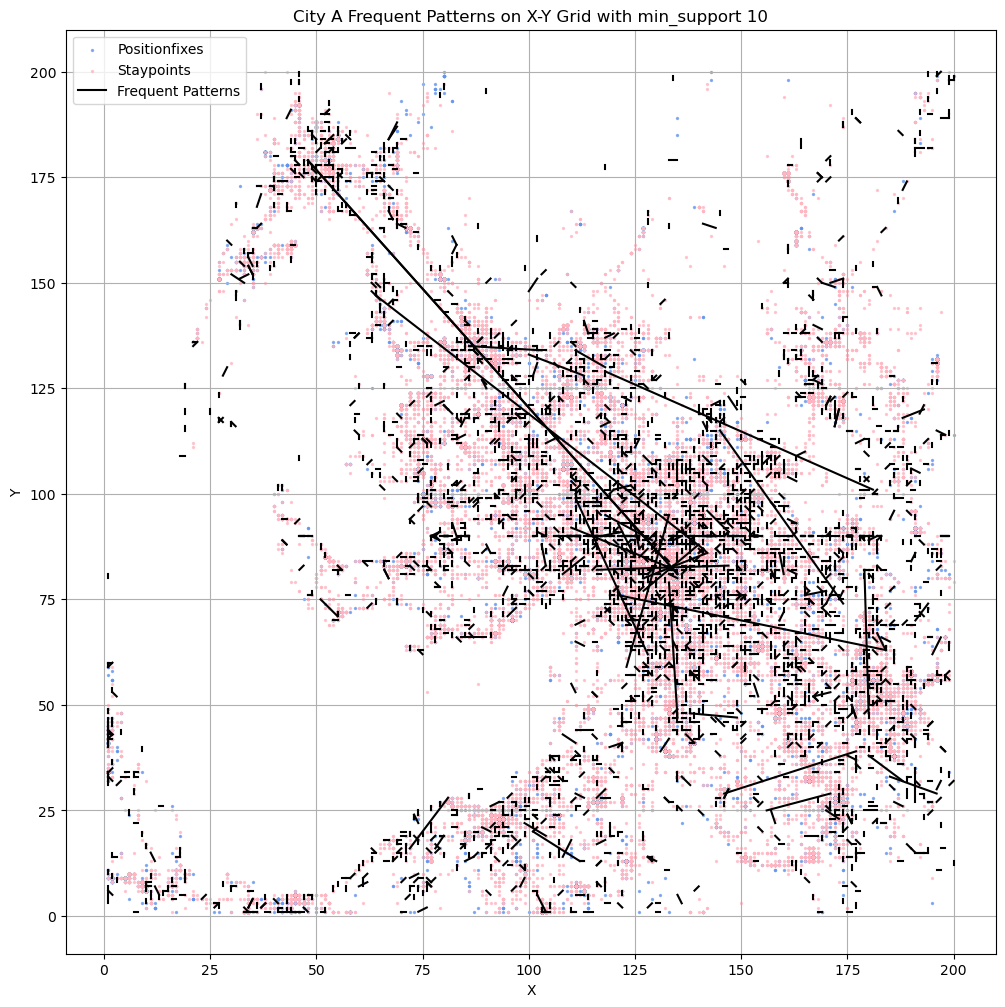

In [33]:
# Visualize top patterns
# Extract positionfixes and staypoints from a subset of processed data for visualization
positionfixes = pfs_chunk[pfs_chunk['staypoint_id'].isna()][:500000]
staypoints = pfs_chunk.dropna(subset=['staypoint_id'])[:500000]

plt.figure(figsize=(12, 12))
plt.scatter(positionfixes['x'], positionfixes['y'], label='Positionfixes', color='#6495ED', s=2, alpha=0.7)
plt.scatter(staypoints['x'], staypoints['y'], label='Staypoints', color='#FFB6C1', s=2, alpha=0.7)

# Plot each frequent pattern
for pattern, count in all_frequent_patterns.items():
    x_coords = [point[0] for point in pattern]
    y_coords = [point[1] for point in pattern]
    plt.plot(x_coords, y_coords, linestyle='-', alpha=1, linewidth=1.5, color='black')

# Add a legend entry for triplegs
plt.plot([], [], linestyle='-', color='black', label='Frequent Patterns')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'City A Frequent Patterns on X-Y Grid with min_support {min_support}')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Convert the frequent patterns to a DataFrame for easier saving
patterns_df = pd.DataFrame({
    'Pattern': [pattern for pattern in all_frequent_patterns.keys()],
    'Count': [count for count in all_frequent_patterns.values()]
})

In [34]:
patterns_df.head()

,Pattern,Count
0,"((141.0, 106.0),)",10
1,"((71.0, 163.0),)",10
2,"((44.0, 4.0),)",10
3,"((46.0, 199.0),)",10
4,"((116.0, 127.0),)",10


In [35]:
# Save the patterns to a CSV file
patterns_df.to_csv("CityA_frequent_patterns_minsup10.csv", index=False)

In [36]:
# Check for long patterns
long_patterns = patterns_df[patterns_df['Pattern'].apply(len) >= 5]

# Display the result
long_patterns

,Pattern,Count
2134,"((143.0, 90.0), (142.0, 90.0), (143.0, 90.0), ...",10
5844,"((176.0, 90.0), (175.0, 90.0), (176.0, 90.0), ...",10
5845,"((175.0, 90.0), (176.0, 90.0), (175.0, 90.0), ...",10
5846,"((175.0, 90.0), (176.0, 90.0), (175.0, 90.0), ...",10
5847,"((176.0, 90.0), (175.0, 90.0), (176.0, 90.0), ...",10
5848,"((176.0, 90.0), (175.0, 90.0), (176.0, 90.0), ...",10
5849,"((175.0, 90.0), (176.0, 90.0), (175.0, 90.0), ...",10
6107,"((154.0, 90.0), (153.0, 90.0), (154.0, 90.0), ...",10
6108,"((153.0, 90.0), (154.0, 90.0), (153.0, 90.0), ...",10
6109,"((154.0, 90.0), (153.0, 90.0), (154.0, 90.0), ...",10
